In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

****Libraries****

In [2]:
import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap



2025-08-19 19:24:04.078335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755631444.286367      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755631444.354266      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


****Device Settings****

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


****DATA SETTINGS****

In [4]:
SEED = 42
BATCH_SIZE_SSL = 64         # for SimCLR pairs
BATCH_SIZE_SUP = 64         # for supervised (linear eval / test)
EPOCHS_SSL = 2000             # SimCLR pretraining epochs
EPOCHS_LINEAR = 2000           # linear eval epochs
TEMPERATURE = 0.5           # NT-Xent temperature
FEATURE_DIM = 2048          # ResNet-50 penultimate layer output
PROJ_DIM = 128              # projection head output
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

****Utils****

In [5]:
def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


****SimCLR Transformation****

In [6]:
class SimCLRTransform:
    """
    Returns two augmented views for each image.
    """
    def __init__(self, size=224):
        s = 1.0
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        self.train_transform = T.Compose([
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

# For supervised loaders (linear eval / test)
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

****Contrastive Pair Dataset****

In [7]:
class ContrastivePairDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, transform_pair):
        self.imgs = image_folder.imgs
        self.loader = image_folder.loader
        self.transform_pair = transform_pair

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        path, _ = self.imgs[idx]
        img = self.loader(path)
        if not isinstance(img, Image.Image):
            img = Image.open(path).convert("RGB")
        v1, v2 = self.transform_pair(img)
        return v1, v2


In [8]:
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 90% for SSL train (unlabeled usage), 10% holdout test (for final testing)
n_total = len(full_dataset_supervised)
n_train_ssl = int(0.2 * n_total)
n_test = n_total - n_train_ssl
ssl_train_sup, test_sup = random_split(full_dataset_supervised, [n_train_ssl, n_test], generator=torch.Generator().manual_seed(SEED))

# SSL Contrastive dataset uses the same images but returns pairs
ssl_train_contrast = ContrastivePairDataset(
    ImageFolder(root=DATA_DIR),  # raw loader
    transform_pair=SimCLRTransform(size=IMG_SIZE)
)

ssl_train_indices = ssl_train_sup.indices if hasattr(ssl_train_sup, 'indices') else list(range(n_train_ssl))
ssl_train_subset = Subset(ssl_train_contrast, ssl_train_indices)

ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=2, drop_last=True)

# Supervised loaders for downstream / test
train_sup_loader = DataLoader(Subset(full_dataset_supervised, ssl_train_indices),
                              batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader = DataLoader(test_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | SSL Train: {len(ssl_train_subset)} | Test: {len(test_sup)}")

# For downstream we also want a val split from the SSL-train portion
val_ratio = 0.2
n_train_down = int((1 - val_ratio) * len(ssl_train_indices))
n_val_down = len(ssl_train_indices) - n_train_down
train_down_indices, val_down_indices = random_split(ssl_train_indices, [n_train_down, n_val_down],
                                                    generator=torch.Generator().manual_seed(SEED))
train_down_loader = DataLoader(Subset(full_dataset_supervised, train_down_indices),
                               batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
val_down_loader = DataLoader(Subset(full_dataset_supervised, val_down_indices),
                             batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | SSL Train: 638 | Test: 2554


In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=FEATURE_DIM, proj_dim=PROJ_DIM, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, proj_dim=PROJ_DIM):
        super().__init__()
        backbone = models.resnet50(weights=None)  # self-supervised from scratch
        backbone.fc = nn.Identity()               # take 2048-d features
        self.encoder = backbone
        self.projector = ProjectionHead(in_dim=FEATURE_DIM, proj_dim=proj_dim)

    def forward(self, x):
        h = self.encoder(x)            # [B, 2048]
        z = self.projector(h)          # [B, proj_dim]
        z = F.normalize(z, dim=1)
        return h, z

# NT-Xent (InfoNCE) loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    z_i, z_j: [B, D] normalized
    Returns: scalar loss
    """
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2B, D]
    sim = torch.matmul(z, z.T)        # [2B, 2B], cosine since z normalized

    # remove self-similarity
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -9e15)

    # positives: diagonal across halves
    positives = torch.cat([torch.arange(batch_size, 2*batch_size),
                           torch.arange(0, batch_size)]).to(z.device)
    numerator = torch.exp(sim[torch.arange(2*batch_size), positives] / temperature)

    denominator = torch.sum(torch.exp(sim / temperature), dim=1)
    loss = -torch.log(numerator / denominator).mean()
    return loss


In [10]:
simclr = SimCLR(proj_dim=PROJ_DIM).to(DEVICE)
opt_ssl = torch.optim.Adam(simclr.parameters(), lr=LR_SSL)

ssl_loss_history = []

print("Starting SimCLR pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    simclr.train()
    running = 0.0
    for v1, v2 in tqdm(ssl_train_loader, desc=f"SSL Epoch {epoch}/{EPOCHS_SSL}"):
        v1, v2 = v1.to(DEVICE), v2.to(DEVICE)
        _, z1 = simclr(v1)
        _, z2 = simclr(v2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        opt_ssl.zero_grad()
        loss.backward()
        opt_ssl.step()
        running += loss.item() * v1.size(0)
    epoch_loss = running / (len(ssl_train_loader.dataset))
    ssl_loss_history.append(epoch_loss)
    print(f"SSL Epoch {epoch}: loss={epoch_loss:.4f}")

# Save encoder weights
torch.save(simclr.encoder.state_dict(), os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"))
print("Saved SimCLR encoder to:", os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"))


Starting SimCLR pretraining...


SSL Epoch 1/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 1: loss=4.3659


SSL Epoch 2/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 2: loss=4.3381


SSL Epoch 3/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 3: loss=4.2852


SSL Epoch 4/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 4: loss=4.2610


SSL Epoch 5/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 5: loss=4.2503


SSL Epoch 6/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 6: loss=4.2637


SSL Epoch 7/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 7: loss=4.2786


SSL Epoch 8/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 8: loss=4.2324


SSL Epoch 9/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 9: loss=4.2633


SSL Epoch 10/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 10: loss=4.2685


SSL Epoch 11/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 11: loss=4.1820


SSL Epoch 12/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 12: loss=4.2306


SSL Epoch 13/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 13: loss=4.1918


SSL Epoch 14/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 14: loss=4.1710


SSL Epoch 15/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 15: loss=4.2294


SSL Epoch 16/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 16: loss=4.2042


SSL Epoch 17/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 17: loss=4.1968


SSL Epoch 18/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 18: loss=4.2188


SSL Epoch 19/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 19: loss=4.1880


SSL Epoch 20/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 20: loss=4.1717


SSL Epoch 21/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 21: loss=4.1509


SSL Epoch 22/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 22: loss=4.1502


SSL Epoch 23/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 23: loss=4.1612


SSL Epoch 24/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 24: loss=4.1720


SSL Epoch 25/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 25: loss=4.1324


SSL Epoch 26/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 26: loss=4.1700


SSL Epoch 27/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 27: loss=4.1695


SSL Epoch 28/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 28: loss=4.1390


SSL Epoch 29/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 29: loss=4.1426


SSL Epoch 30/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 30: loss=4.1097


SSL Epoch 31/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 31: loss=4.1235


SSL Epoch 32/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 32: loss=4.1104


SSL Epoch 33/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 33: loss=4.2132


SSL Epoch 34/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 34: loss=4.1702


SSL Epoch 35/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 35: loss=4.1610


SSL Epoch 36/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 36: loss=4.1359


SSL Epoch 37/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 37: loss=4.1087


SSL Epoch 38/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 38: loss=4.1100


SSL Epoch 39/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 39: loss=4.1195


SSL Epoch 40/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 40: loss=4.0237


SSL Epoch 41/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 41: loss=4.0546


SSL Epoch 42/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 42: loss=4.1385


SSL Epoch 43/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 43: loss=4.1527


SSL Epoch 44/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 44: loss=4.1131


SSL Epoch 45/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 45: loss=4.1084


SSL Epoch 46/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 46: loss=4.0922


SSL Epoch 47/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 47: loss=4.0825


SSL Epoch 48/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 48: loss=4.1477


SSL Epoch 49/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 49: loss=4.1416


SSL Epoch 50/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 50: loss=4.1310


SSL Epoch 51/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 51: loss=4.0630


SSL Epoch 52/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 52: loss=4.1301


SSL Epoch 53/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 53: loss=4.1240


SSL Epoch 54/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 54: loss=4.1193


SSL Epoch 55/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 55: loss=4.1431


SSL Epoch 56/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 56: loss=4.1335


SSL Epoch 57/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 57: loss=4.0814


SSL Epoch 58/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 58: loss=4.1015


SSL Epoch 59/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 59: loss=4.1076


SSL Epoch 60/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 60: loss=4.1728


SSL Epoch 61/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 61: loss=4.1611


SSL Epoch 62/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 62: loss=4.1289


SSL Epoch 63/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 63: loss=4.1256


SSL Epoch 64/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 64: loss=4.1085


SSL Epoch 65/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 65: loss=4.0614


SSL Epoch 66/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 66: loss=4.0807


SSL Epoch 67/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 67: loss=3.9740


SSL Epoch 68/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 68: loss=4.0115


SSL Epoch 69/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 69: loss=4.1147


SSL Epoch 70/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 70: loss=4.0656


SSL Epoch 71/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 71: loss=4.0621


SSL Epoch 72/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 72: loss=4.0292


SSL Epoch 73/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 73: loss=4.0250


SSL Epoch 74/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 74: loss=3.9981


SSL Epoch 75/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 75: loss=3.9507


SSL Epoch 76/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 76: loss=4.0595


SSL Epoch 77/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 77: loss=3.9458


SSL Epoch 78/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 78: loss=3.9879


SSL Epoch 79/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 79: loss=3.9338


SSL Epoch 80/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 80: loss=3.9505


SSL Epoch 81/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 81: loss=3.8294


SSL Epoch 82/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 82: loss=3.8714


SSL Epoch 83/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 83: loss=3.9257


SSL Epoch 84/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 84: loss=3.8566


SSL Epoch 85/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 85: loss=3.8652


SSL Epoch 86/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 86: loss=3.8512


SSL Epoch 87/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 87: loss=3.8573


SSL Epoch 88/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 88: loss=3.8177


SSL Epoch 89/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 89: loss=3.8992


SSL Epoch 90/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 90: loss=3.8835


SSL Epoch 91/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 91: loss=3.8614


SSL Epoch 92/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 92: loss=3.8227


SSL Epoch 93/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 93: loss=3.8545


SSL Epoch 94/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 94: loss=3.7705


SSL Epoch 95/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 95: loss=3.9430


SSL Epoch 96/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 96: loss=3.8962


SSL Epoch 97/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 97: loss=3.9052


SSL Epoch 98/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 98: loss=3.9352


SSL Epoch 99/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 99: loss=3.8674


SSL Epoch 100/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 100: loss=3.8112


SSL Epoch 101/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 101: loss=3.7884


SSL Epoch 102/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 102: loss=3.8166


SSL Epoch 103/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 103: loss=3.7534


SSL Epoch 104/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 104: loss=3.7291


SSL Epoch 105/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 105: loss=3.7588


SSL Epoch 106/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 106: loss=3.8139


SSL Epoch 107/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 107: loss=3.7581


SSL Epoch 108/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 108: loss=3.7690


SSL Epoch 109/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 109: loss=3.7350


SSL Epoch 110/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 110: loss=3.7318


SSL Epoch 111/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 111: loss=3.7310


SSL Epoch 112/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 112: loss=3.7516


SSL Epoch 113/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 113: loss=3.7601


SSL Epoch 114/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 114: loss=3.7318


SSL Epoch 115/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 115: loss=3.7326


SSL Epoch 116/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 116: loss=3.7238


SSL Epoch 117/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 117: loss=3.6964


SSL Epoch 118/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 118: loss=3.7016


SSL Epoch 119/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 119: loss=3.6975


SSL Epoch 120/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 120: loss=3.7447


SSL Epoch 121/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 121: loss=3.6618


SSL Epoch 122/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 122: loss=3.7201


SSL Epoch 123/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 123: loss=3.7056


SSL Epoch 124/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 124: loss=3.7053


SSL Epoch 125/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 125: loss=3.7452


SSL Epoch 126/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 126: loss=3.6432


SSL Epoch 127/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 127: loss=3.6394


SSL Epoch 128/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 128: loss=3.6868


SSL Epoch 129/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 129: loss=3.6826


SSL Epoch 130/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 130: loss=3.6492


SSL Epoch 131/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 131: loss=3.6410


SSL Epoch 132/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 132: loss=3.6241


SSL Epoch 133/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 133: loss=3.6143


SSL Epoch 134/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 134: loss=3.6486


SSL Epoch 135/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 135: loss=3.6455


SSL Epoch 136/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 136: loss=3.6057


SSL Epoch 137/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 137: loss=3.6396


SSL Epoch 138/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 138: loss=3.6087


SSL Epoch 139/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 139: loss=3.5863


SSL Epoch 140/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 140: loss=3.6157


SSL Epoch 141/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 141: loss=3.5792


SSL Epoch 142/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 142: loss=3.5794


SSL Epoch 143/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 143: loss=3.5723


SSL Epoch 144/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 144: loss=3.5457


SSL Epoch 145/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 145: loss=3.5342


SSL Epoch 146/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 146: loss=3.5284


SSL Epoch 147/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 147: loss=3.5667


SSL Epoch 148/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 148: loss=3.5299


SSL Epoch 149/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 149: loss=3.5831


SSL Epoch 150/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 150: loss=3.5449


SSL Epoch 151/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 151: loss=3.4892


SSL Epoch 152/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 152: loss=3.5447


SSL Epoch 153/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 153: loss=3.5523


SSL Epoch 154/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 154: loss=3.5619


SSL Epoch 155/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 155: loss=3.5015


SSL Epoch 156/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 156: loss=3.5572


SSL Epoch 157/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 157: loss=3.5551


SSL Epoch 158/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 158: loss=3.5062


SSL Epoch 159/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 159: loss=3.5132


SSL Epoch 160/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 160: loss=3.5672


SSL Epoch 161/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 161: loss=3.4575


SSL Epoch 162/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 162: loss=3.5401


SSL Epoch 163/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 163: loss=3.5427


SSL Epoch 164/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 164: loss=3.5115


SSL Epoch 165/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 165: loss=3.5228


SSL Epoch 166/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 166: loss=3.4935


SSL Epoch 167/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 167: loss=3.4344


SSL Epoch 168/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 168: loss=3.4395


SSL Epoch 169/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 169: loss=3.4719


SSL Epoch 170/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 170: loss=3.4143


SSL Epoch 171/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 171: loss=3.4258


SSL Epoch 172/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 172: loss=3.4579


SSL Epoch 173/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 173: loss=3.4316


SSL Epoch 174/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 174: loss=3.4054


SSL Epoch 175/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 175: loss=3.4246


SSL Epoch 176/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 176: loss=3.4069


SSL Epoch 177/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 177: loss=3.4658


SSL Epoch 178/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 178: loss=3.4598


SSL Epoch 179/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 179: loss=3.4623


SSL Epoch 180/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 180: loss=3.4502


SSL Epoch 181/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 181: loss=3.4214


SSL Epoch 182/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 182: loss=3.3872


SSL Epoch 183/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 183: loss=3.3803


SSL Epoch 184/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 184: loss=3.3826


SSL Epoch 185/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 185: loss=3.3902


SSL Epoch 186/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 186: loss=3.3876


SSL Epoch 187/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 187: loss=3.3770


SSL Epoch 188/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 188: loss=3.3886


SSL Epoch 189/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 189: loss=3.3755


SSL Epoch 190/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 190: loss=3.3772


SSL Epoch 191/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 191: loss=3.3844


SSL Epoch 192/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 192: loss=3.3761


SSL Epoch 193/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 193: loss=3.3417


SSL Epoch 194/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 194: loss=3.3533


SSL Epoch 195/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 195: loss=3.3603


SSL Epoch 196/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 196: loss=3.3630


SSL Epoch 197/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 197: loss=3.3319


SSL Epoch 198/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 198: loss=3.3349


SSL Epoch 199/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 199: loss=3.3518


SSL Epoch 200/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 200: loss=3.3043


SSL Epoch 201/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 201: loss=3.3220


SSL Epoch 202/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 202: loss=3.3297


SSL Epoch 203/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 203: loss=3.3156


SSL Epoch 204/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 204: loss=3.3363


SSL Epoch 205/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 205: loss=3.3395


SSL Epoch 206/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 206: loss=3.2969


SSL Epoch 207/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 207: loss=3.3018


SSL Epoch 208/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 208: loss=3.2909


SSL Epoch 209/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 209: loss=3.2995


SSL Epoch 210/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 210: loss=3.2735


SSL Epoch 211/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 211: loss=3.3019


SSL Epoch 212/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 212: loss=3.2682


SSL Epoch 213/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 213: loss=3.2985


SSL Epoch 214/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 214: loss=3.3038


SSL Epoch 215/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 215: loss=3.2830


SSL Epoch 216/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 216: loss=3.2986


SSL Epoch 217/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 217: loss=3.2729


SSL Epoch 218/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 218: loss=3.2802


SSL Epoch 219/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 219: loss=3.2738


SSL Epoch 220/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 220: loss=3.2811


SSL Epoch 221/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 221: loss=3.2570


SSL Epoch 222/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 222: loss=3.2960


SSL Epoch 223/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 223: loss=3.2645


SSL Epoch 224/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 224: loss=3.2622


SSL Epoch 225/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 225: loss=3.2904


SSL Epoch 226/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 226: loss=3.2336


SSL Epoch 227/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 227: loss=3.2466


SSL Epoch 228/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 228: loss=3.2481


SSL Epoch 229/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 229: loss=3.2837


SSL Epoch 230/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 230: loss=3.2555


SSL Epoch 231/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 231: loss=3.2491


SSL Epoch 232/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 232: loss=3.2394


SSL Epoch 233/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 233: loss=3.2628


SSL Epoch 234/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 234: loss=3.2501


SSL Epoch 235/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 235: loss=3.2464


SSL Epoch 236/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 236: loss=3.2431


SSL Epoch 237/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 237: loss=3.2609


SSL Epoch 238/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 238: loss=3.2306


SSL Epoch 239/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 239: loss=3.2410


SSL Epoch 240/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 240: loss=3.2194


SSL Epoch 241/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 241: loss=3.2500


SSL Epoch 242/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 242: loss=3.2350


SSL Epoch 243/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 243: loss=3.2321


SSL Epoch 244/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 244: loss=3.2429


SSL Epoch 245/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 245: loss=3.2201


SSL Epoch 246/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 246: loss=3.2151


SSL Epoch 247/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 247: loss=3.2448


SSL Epoch 248/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 248: loss=3.2423


SSL Epoch 249/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 249: loss=3.2294


SSL Epoch 250/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 250: loss=3.2145


SSL Epoch 251/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 251: loss=3.2102


SSL Epoch 252/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 252: loss=3.2231


SSL Epoch 253/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 253: loss=3.2241


SSL Epoch 254/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 254: loss=3.2075


SSL Epoch 255/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 255: loss=3.2141


SSL Epoch 256/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 256: loss=3.2265


SSL Epoch 257/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 257: loss=3.2265


SSL Epoch 258/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 258: loss=3.2308


SSL Epoch 259/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 259: loss=3.2038


SSL Epoch 260/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 260: loss=3.1926


SSL Epoch 261/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 261: loss=3.1875


SSL Epoch 262/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 262: loss=3.1805


SSL Epoch 263/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 263: loss=3.2020


SSL Epoch 264/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 264: loss=3.1929


SSL Epoch 265/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 265: loss=3.2076


SSL Epoch 266/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 266: loss=3.1843


SSL Epoch 267/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 267: loss=3.1770


SSL Epoch 268/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 268: loss=3.1625


SSL Epoch 269/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 269: loss=3.1588


SSL Epoch 270/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 270: loss=3.1543


SSL Epoch 271/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 271: loss=3.1652


SSL Epoch 272/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 272: loss=3.1713


SSL Epoch 273/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 273: loss=3.1805


SSL Epoch 274/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 274: loss=3.1653


SSL Epoch 275/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 275: loss=3.1368


SSL Epoch 276/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 276: loss=3.1496


SSL Epoch 277/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 277: loss=3.1519


SSL Epoch 278/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 278: loss=3.1654


SSL Epoch 279/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 279: loss=3.1744


SSL Epoch 280/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 280: loss=3.1519


SSL Epoch 281/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 281: loss=3.1701


SSL Epoch 282/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 282: loss=3.1804


SSL Epoch 283/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 283: loss=3.1652


SSL Epoch 284/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 284: loss=3.1862


SSL Epoch 285/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 285: loss=3.1870


SSL Epoch 286/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 286: loss=3.1879


SSL Epoch 287/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 287: loss=3.1253


SSL Epoch 288/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 288: loss=3.1767


SSL Epoch 289/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 289: loss=3.1453


SSL Epoch 290/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 290: loss=3.1372


SSL Epoch 291/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 291: loss=3.1361


SSL Epoch 292/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 292: loss=3.1604


SSL Epoch 293/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 293: loss=3.1599


SSL Epoch 294/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 294: loss=3.1435


SSL Epoch 295/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 295: loss=3.1513


SSL Epoch 296/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 296: loss=3.1723


SSL Epoch 297/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 297: loss=3.1201


SSL Epoch 298/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 298: loss=3.1410


SSL Epoch 299/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 299: loss=3.1318


SSL Epoch 300/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 300: loss=3.1302


SSL Epoch 301/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 301: loss=3.1507


SSL Epoch 302/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 302: loss=3.1396


SSL Epoch 303/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 303: loss=3.1398


SSL Epoch 304/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 304: loss=3.1494


SSL Epoch 305/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 305: loss=3.1224


SSL Epoch 306/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 306: loss=3.1322


SSL Epoch 307/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 307: loss=3.1434


SSL Epoch 308/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 308: loss=3.1240


SSL Epoch 309/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 309: loss=3.1150


SSL Epoch 310/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 310: loss=3.1136


SSL Epoch 311/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 311: loss=3.1408


SSL Epoch 312/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 312: loss=3.1277


SSL Epoch 313/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 313: loss=3.1095


SSL Epoch 314/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 314: loss=3.1249


SSL Epoch 315/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 315: loss=3.1247


SSL Epoch 316/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 316: loss=3.1294


SSL Epoch 317/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 317: loss=3.1218


SSL Epoch 318/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 318: loss=3.1360


SSL Epoch 319/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 319: loss=3.1196


SSL Epoch 320/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 320: loss=3.0897


SSL Epoch 321/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 321: loss=3.1202


SSL Epoch 322/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 322: loss=3.1322


SSL Epoch 323/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 323: loss=3.1261


SSL Epoch 324/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 324: loss=3.1172


SSL Epoch 325/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 325: loss=3.1170


SSL Epoch 326/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 326: loss=3.1238


SSL Epoch 327/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 327: loss=3.1065


SSL Epoch 328/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 328: loss=3.1012


SSL Epoch 329/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 329: loss=3.1037


SSL Epoch 330/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 330: loss=3.1015


SSL Epoch 331/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 331: loss=3.1202


SSL Epoch 332/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 332: loss=3.1243


SSL Epoch 333/2000: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


SSL Epoch 333: loss=3.1224


SSL Epoch 334/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 334: loss=3.1180


SSL Epoch 335/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 335: loss=3.1151


SSL Epoch 336/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 336: loss=3.0992


SSL Epoch 337/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 337: loss=3.0812


SSL Epoch 338/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 338: loss=3.1380


SSL Epoch 339/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 339: loss=3.0828


SSL Epoch 340/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 340: loss=3.1051


SSL Epoch 341/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 341: loss=3.1049


SSL Epoch 342/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 342: loss=3.1171


SSL Epoch 343/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 343: loss=3.0895


SSL Epoch 344/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 344: loss=3.0705


SSL Epoch 345/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 345: loss=3.0894


SSL Epoch 346/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 346: loss=3.0944


SSL Epoch 347/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 347: loss=3.1215


SSL Epoch 348/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 348: loss=3.0994


SSL Epoch 349/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 349: loss=3.1087


SSL Epoch 350/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 350: loss=3.0996


SSL Epoch 351/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 351: loss=3.1020


SSL Epoch 352/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 352: loss=3.0812


SSL Epoch 353/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 353: loss=3.1067


SSL Epoch 354/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 354: loss=3.0917


SSL Epoch 355/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 355: loss=3.0705


SSL Epoch 356/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 356: loss=3.1078


SSL Epoch 357/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 357: loss=3.0750


SSL Epoch 358/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 358: loss=3.0917


SSL Epoch 359/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 359: loss=3.0927


SSL Epoch 360/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 360: loss=3.0736


SSL Epoch 361/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 361: loss=3.1218


SSL Epoch 362/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 362: loss=3.0662


SSL Epoch 363/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 363: loss=3.0796


SSL Epoch 364/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 364: loss=3.0942


SSL Epoch 365/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 365: loss=3.0565


SSL Epoch 366/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 366: loss=3.0739


SSL Epoch 367/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 367: loss=3.0899


SSL Epoch 368/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 368: loss=3.0601


SSL Epoch 369/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 369: loss=3.0670


SSL Epoch 370/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 370: loss=3.0542


SSL Epoch 371/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 371: loss=3.0609


SSL Epoch 372/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 372: loss=3.0668


SSL Epoch 373/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 373: loss=3.0947


SSL Epoch 374/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 374: loss=3.0728


SSL Epoch 375/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 375: loss=3.0873


SSL Epoch 376/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 376: loss=3.0722


SSL Epoch 377/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 377: loss=3.0598


SSL Epoch 378/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 378: loss=3.0845


SSL Epoch 379/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 379: loss=3.0635


SSL Epoch 380/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 380: loss=3.0688


SSL Epoch 381/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 381: loss=3.0704


SSL Epoch 382/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 382: loss=3.0831


SSL Epoch 383/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 383: loss=3.0613


SSL Epoch 384/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 384: loss=3.0309


SSL Epoch 385/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 385: loss=3.0709


SSL Epoch 386/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 386: loss=3.0549


SSL Epoch 387/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 387: loss=3.0684


SSL Epoch 388/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 388: loss=3.0852


SSL Epoch 389/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 389: loss=3.0601


SSL Epoch 390/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 390: loss=3.0837


SSL Epoch 391/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 391: loss=3.0576


SSL Epoch 392/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 392: loss=3.0592


SSL Epoch 393/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 393: loss=3.0802


SSL Epoch 394/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 394: loss=3.0603


SSL Epoch 395/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 395: loss=3.0609


SSL Epoch 396/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 396: loss=3.0487


SSL Epoch 397/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 397: loss=3.0648


SSL Epoch 398/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 398: loss=3.0284


SSL Epoch 399/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 399: loss=3.0326


SSL Epoch 400/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 400: loss=3.0415


SSL Epoch 401/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 401: loss=3.0524


SSL Epoch 402/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 402: loss=3.0532


SSL Epoch 403/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 403: loss=3.0694


SSL Epoch 404/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 404: loss=3.0557


SSL Epoch 405/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 405: loss=3.0404


SSL Epoch 406/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 406: loss=3.0571


SSL Epoch 407/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 407: loss=3.0550


SSL Epoch 408/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 408: loss=3.0622


SSL Epoch 409/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 409: loss=3.0306


SSL Epoch 410/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 410: loss=3.0565


SSL Epoch 411/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 411: loss=3.0567


SSL Epoch 412/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 412: loss=3.0354


SSL Epoch 413/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 413: loss=3.0573


SSL Epoch 414/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 414: loss=3.0551


SSL Epoch 415/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 415: loss=3.0489


SSL Epoch 416/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 416: loss=3.0390


SSL Epoch 417/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 417: loss=3.0507


SSL Epoch 418/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 418: loss=3.0558


SSL Epoch 419/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 419: loss=3.0472


SSL Epoch 420/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 420: loss=3.0563


SSL Epoch 421/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 421: loss=3.0320


SSL Epoch 422/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 422: loss=3.0400


SSL Epoch 423/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 423: loss=3.0315


SSL Epoch 424/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 424: loss=3.0373


SSL Epoch 425/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 425: loss=3.0603


SSL Epoch 426/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 426: loss=3.0687


SSL Epoch 427/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 427: loss=3.0352


SSL Epoch 428/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 428: loss=3.0341


SSL Epoch 429/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 429: loss=3.0249


SSL Epoch 430/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 430: loss=3.0601


SSL Epoch 431/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 431: loss=3.0294


SSL Epoch 432/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 432: loss=3.0427


SSL Epoch 433/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 433: loss=3.0457


SSL Epoch 434/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 434: loss=3.0319


SSL Epoch 435/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 435: loss=3.0427


SSL Epoch 436/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 436: loss=3.0493


SSL Epoch 437/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 437: loss=3.0243


SSL Epoch 438/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 438: loss=3.0396


SSL Epoch 439/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 439: loss=3.0303


SSL Epoch 440/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 440: loss=3.0217


SSL Epoch 441/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 441: loss=3.0253


SSL Epoch 442/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 442: loss=3.0136


SSL Epoch 443/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 443: loss=3.0367


SSL Epoch 444/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 444: loss=3.0384


SSL Epoch 445/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 445: loss=3.0309


SSL Epoch 446/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 446: loss=3.0216


SSL Epoch 447/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 447: loss=3.0417


SSL Epoch 448/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 448: loss=3.0346


SSL Epoch 449/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 449: loss=3.0285


SSL Epoch 450/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 450: loss=3.0458


SSL Epoch 451/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 451: loss=3.0261


SSL Epoch 452/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 452: loss=3.0299


SSL Epoch 453/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 453: loss=3.0509


SSL Epoch 454/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 454: loss=3.0274


SSL Epoch 455/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 455: loss=3.0085


SSL Epoch 456/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 456: loss=3.0293


SSL Epoch 457/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 457: loss=3.0022


SSL Epoch 458/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 458: loss=3.0052


SSL Epoch 459/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 459: loss=3.0273


SSL Epoch 460/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 460: loss=3.0103


SSL Epoch 461/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 461: loss=3.0179


SSL Epoch 462/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 462: loss=3.0094


SSL Epoch 463/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 463: loss=3.0246


SSL Epoch 464/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 464: loss=3.0239


SSL Epoch 465/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 465: loss=3.0120


SSL Epoch 466/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 466: loss=3.0297


SSL Epoch 467/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 467: loss=3.0220


SSL Epoch 468/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 468: loss=3.0192


SSL Epoch 469/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 469: loss=3.0248


SSL Epoch 470/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 470: loss=3.0185


SSL Epoch 471/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 471: loss=2.9979


SSL Epoch 472/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 472: loss=3.0358


SSL Epoch 473/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 473: loss=2.9958


SSL Epoch 474/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 474: loss=3.0344


SSL Epoch 475/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 475: loss=3.0072


SSL Epoch 476/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 476: loss=3.0115


SSL Epoch 477/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 477: loss=3.0328


SSL Epoch 478/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 478: loss=3.0131


SSL Epoch 479/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 479: loss=2.9929


SSL Epoch 480/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 480: loss=2.9973


SSL Epoch 481/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 481: loss=2.9865


SSL Epoch 482/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 482: loss=3.0051


SSL Epoch 483/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 483: loss=3.0276


SSL Epoch 484/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 484: loss=3.0033


SSL Epoch 485/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 485: loss=2.9808


SSL Epoch 486/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 486: loss=3.0077


SSL Epoch 487/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 487: loss=2.9934


SSL Epoch 488/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 488: loss=2.9865


SSL Epoch 489/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 489: loss=3.0099


SSL Epoch 490/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 490: loss=3.0105


SSL Epoch 491/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 491: loss=2.9959


SSL Epoch 492/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 492: loss=2.9979


SSL Epoch 493/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 493: loss=3.0107


SSL Epoch 494/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 494: loss=3.0021


SSL Epoch 495/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 495: loss=2.9962


SSL Epoch 496/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 496: loss=3.0025


SSL Epoch 497/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 497: loss=2.9970


SSL Epoch 498/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 498: loss=2.9901


SSL Epoch 499/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 499: loss=3.0306


SSL Epoch 500/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 500: loss=3.0231


SSL Epoch 501/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 501: loss=3.0039


SSL Epoch 502/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 502: loss=3.0195


SSL Epoch 503/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 503: loss=2.9966


SSL Epoch 504/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 504: loss=3.0011


SSL Epoch 505/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 505: loss=2.9821


SSL Epoch 506/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 506: loss=2.9956


SSL Epoch 507/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 507: loss=2.9950


SSL Epoch 508/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 508: loss=2.9860


SSL Epoch 509/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 509: loss=2.9987


SSL Epoch 510/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 510: loss=2.9945


SSL Epoch 511/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 511: loss=2.9982


SSL Epoch 512/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 512: loss=2.9850


SSL Epoch 513/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 513: loss=2.9861


SSL Epoch 514/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 514: loss=2.9682


SSL Epoch 515/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 515: loss=2.9847


SSL Epoch 516/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 516: loss=2.9916


SSL Epoch 517/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 517: loss=2.9934


SSL Epoch 518/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 518: loss=3.0041


SSL Epoch 519/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 519: loss=2.9849


SSL Epoch 520/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 520: loss=3.0020


SSL Epoch 521/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 521: loss=2.9880


SSL Epoch 522/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 522: loss=2.9968


SSL Epoch 523/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 523: loss=3.0071


SSL Epoch 524/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 524: loss=2.9982


SSL Epoch 525/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 525: loss=2.9893


SSL Epoch 526/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 526: loss=2.9913


SSL Epoch 527/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 527: loss=3.0175


SSL Epoch 528/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 528: loss=2.9667


SSL Epoch 529/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 529: loss=3.0196


SSL Epoch 530/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 530: loss=2.9974


SSL Epoch 531/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 531: loss=2.9777


SSL Epoch 532/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 532: loss=2.9962


SSL Epoch 533/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 533: loss=2.9966


SSL Epoch 534/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 534: loss=2.9864


SSL Epoch 535/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 535: loss=2.9996


SSL Epoch 536/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 536: loss=2.9873


SSL Epoch 537/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 537: loss=2.9805


SSL Epoch 538/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 538: loss=2.9839


SSL Epoch 539/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 539: loss=2.9828


SSL Epoch 540/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 540: loss=2.9829


SSL Epoch 541/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 541: loss=2.9780


SSL Epoch 542/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 542: loss=2.9742


SSL Epoch 543/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 543: loss=2.9663


SSL Epoch 544/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 544: loss=3.0024


SSL Epoch 545/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 545: loss=3.0089


SSL Epoch 546/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 546: loss=2.9942


SSL Epoch 547/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 547: loss=3.0014


SSL Epoch 548/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 548: loss=2.9757


SSL Epoch 549/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 549: loss=2.9779


SSL Epoch 550/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 550: loss=2.9871


SSL Epoch 551/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 551: loss=2.9815


SSL Epoch 552/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 552: loss=2.9856


SSL Epoch 553/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 553: loss=2.9659


SSL Epoch 554/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 554: loss=2.9550


SSL Epoch 555/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 555: loss=2.9661


SSL Epoch 556/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 556: loss=2.9544


SSL Epoch 557/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 557: loss=2.9859


SSL Epoch 558/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 558: loss=2.9883


SSL Epoch 559/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 559: loss=2.9918


SSL Epoch 560/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 560: loss=2.9578


SSL Epoch 561/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 561: loss=2.9706


SSL Epoch 562/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 562: loss=2.9364


SSL Epoch 563/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 563: loss=2.9797


SSL Epoch 564/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 564: loss=2.9935


SSL Epoch 565/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 565: loss=2.9602


SSL Epoch 566/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 566: loss=2.9750


SSL Epoch 567/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 567: loss=2.9943


SSL Epoch 568/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 568: loss=2.9756


SSL Epoch 569/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 569: loss=2.9836


SSL Epoch 570/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 570: loss=2.9848


SSL Epoch 571/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 571: loss=2.9596


SSL Epoch 572/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 572: loss=2.9669


SSL Epoch 573/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 573: loss=2.9712


SSL Epoch 574/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 574: loss=2.9740


SSL Epoch 575/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 575: loss=2.9679


SSL Epoch 576/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 576: loss=3.0013


SSL Epoch 577/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 577: loss=2.9742


SSL Epoch 578/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 578: loss=2.9837


SSL Epoch 579/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 579: loss=2.9442


SSL Epoch 580/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 580: loss=2.9689


SSL Epoch 581/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 581: loss=2.9703


SSL Epoch 582/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 582: loss=2.9693


SSL Epoch 583/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 583: loss=2.9742


SSL Epoch 584/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 584: loss=2.9757


SSL Epoch 585/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 585: loss=2.9783


SSL Epoch 586/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 586: loss=2.9692


SSL Epoch 587/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 587: loss=2.9663


SSL Epoch 588/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 588: loss=2.9460


SSL Epoch 589/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 589: loss=2.9783


SSL Epoch 590/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 590: loss=2.9435


SSL Epoch 591/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 591: loss=2.9554


SSL Epoch 592/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 592: loss=2.9726


SSL Epoch 593/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 593: loss=2.9530


SSL Epoch 594/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 594: loss=2.9599


SSL Epoch 595/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 595: loss=2.9509


SSL Epoch 596/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 596: loss=2.9442


SSL Epoch 597/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 597: loss=2.9618


SSL Epoch 598/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 598: loss=2.9423


SSL Epoch 599/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 599: loss=2.9616


SSL Epoch 600/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 600: loss=2.9404


SSL Epoch 601/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 601: loss=2.9255


SSL Epoch 602/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 602: loss=2.9445


SSL Epoch 603/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


SSL Epoch 603: loss=2.9386


SSL Epoch 604/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 604: loss=2.9489


SSL Epoch 605/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 605: loss=2.9464


SSL Epoch 606/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 606: loss=2.9499


SSL Epoch 607/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 607: loss=2.9563


SSL Epoch 608/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 608: loss=2.9466


SSL Epoch 609/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 609: loss=2.9522


SSL Epoch 610/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 610: loss=2.9576


SSL Epoch 611/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 611: loss=2.9405


SSL Epoch 612/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 612: loss=2.9537


SSL Epoch 613/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 613: loss=2.9453


SSL Epoch 614/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 614: loss=2.9461


SSL Epoch 615/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 615: loss=2.9624


SSL Epoch 616/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 616: loss=2.9723


SSL Epoch 617/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 617: loss=2.9388


SSL Epoch 618/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 618: loss=2.9404


SSL Epoch 619/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 619: loss=2.9298


SSL Epoch 620/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 620: loss=2.9504


SSL Epoch 621/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 621: loss=2.9380


SSL Epoch 622/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 622: loss=2.9539


SSL Epoch 623/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 623: loss=2.9418


SSL Epoch 624/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 624: loss=2.9385


SSL Epoch 625/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 625: loss=2.9404


SSL Epoch 626/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 626: loss=2.9493


SSL Epoch 627/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 627: loss=2.9681


SSL Epoch 628/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 628: loss=2.9445


SSL Epoch 629/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 629: loss=2.9256


SSL Epoch 630/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 630: loss=2.9406


SSL Epoch 631/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 631: loss=2.9533


SSL Epoch 632/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 632: loss=2.9345


SSL Epoch 633/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 633: loss=2.9550


SSL Epoch 634/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 634: loss=2.9654


SSL Epoch 635/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 635: loss=2.9330


SSL Epoch 636/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 636: loss=2.9571


SSL Epoch 637/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 637: loss=2.9424


SSL Epoch 638/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 638: loss=2.9700


SSL Epoch 639/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 639: loss=2.9335


SSL Epoch 640/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 640: loss=2.9407


SSL Epoch 641/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 641: loss=2.9770


SSL Epoch 642/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 642: loss=2.9571


SSL Epoch 643/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 643: loss=2.9280


SSL Epoch 644/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 644: loss=2.9243


SSL Epoch 645/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 645: loss=2.9304


SSL Epoch 646/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 646: loss=2.9439


SSL Epoch 647/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 647: loss=2.9296


SSL Epoch 648/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 648: loss=2.9373


SSL Epoch 649/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 649: loss=2.9260


SSL Epoch 650/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 650: loss=2.9613


SSL Epoch 651/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 651: loss=2.9366


SSL Epoch 652/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 652: loss=2.9343


SSL Epoch 653/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 653: loss=2.9407


SSL Epoch 654/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 654: loss=2.9423


SSL Epoch 655/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 655: loss=2.9382


SSL Epoch 656/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 656: loss=2.9446


SSL Epoch 657/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 657: loss=2.9297


SSL Epoch 658/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 658: loss=2.9325


SSL Epoch 659/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 659: loss=2.9462


SSL Epoch 660/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 660: loss=2.9527


SSL Epoch 661/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 661: loss=2.9328


SSL Epoch 662/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 662: loss=2.9406


SSL Epoch 663/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 663: loss=2.9183


SSL Epoch 664/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 664: loss=2.9270


SSL Epoch 665/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 665: loss=2.9198


SSL Epoch 666/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 666: loss=2.9224


SSL Epoch 667/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 667: loss=2.9665


SSL Epoch 668/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 668: loss=2.9287


SSL Epoch 669/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 669: loss=2.9236


SSL Epoch 670/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 670: loss=2.9255


SSL Epoch 671/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 671: loss=2.9407


SSL Epoch 672/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 672: loss=2.9485


SSL Epoch 673/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 673: loss=2.9536


SSL Epoch 674/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 674: loss=2.9309


SSL Epoch 675/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 675: loss=2.9286


SSL Epoch 676/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 676: loss=2.9312


SSL Epoch 677/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 677: loss=2.9321


SSL Epoch 678/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 678: loss=2.9172


SSL Epoch 679/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 679: loss=2.9096


SSL Epoch 680/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 680: loss=2.9357


SSL Epoch 681/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 681: loss=2.9207


SSL Epoch 682/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 682: loss=2.9160


SSL Epoch 683/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 683: loss=2.9082


SSL Epoch 684/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 684: loss=2.9323


SSL Epoch 685/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 685: loss=2.9202


SSL Epoch 686/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 686: loss=2.9283


SSL Epoch 687/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 687: loss=2.9192


SSL Epoch 688/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 688: loss=2.9099


SSL Epoch 689/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 689: loss=2.9286


SSL Epoch 690/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 690: loss=2.9403


SSL Epoch 691/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 691: loss=2.9167


SSL Epoch 692/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 692: loss=2.9128


SSL Epoch 693/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 693: loss=2.9154


SSL Epoch 694/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 694: loss=2.9224


SSL Epoch 695/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 695: loss=2.9247


SSL Epoch 696/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 696: loss=2.9287


SSL Epoch 697/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 697: loss=2.9418


SSL Epoch 698/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 698: loss=2.9197


SSL Epoch 699/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 699: loss=2.9134


SSL Epoch 700/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 700: loss=2.8899


SSL Epoch 701/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 701: loss=2.9172


SSL Epoch 702/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 702: loss=2.9310


SSL Epoch 703/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 703: loss=2.9029


SSL Epoch 704/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 704: loss=2.9150


SSL Epoch 705/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 705: loss=2.9131


SSL Epoch 706/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 706: loss=2.8970


SSL Epoch 707/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 707: loss=2.9067


SSL Epoch 708/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 708: loss=2.9588


SSL Epoch 709/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 709: loss=2.9347


SSL Epoch 710/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 710: loss=2.9335


SSL Epoch 711/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 711: loss=2.9320


SSL Epoch 712/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 712: loss=2.9113


SSL Epoch 713/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 713: loss=2.8980


SSL Epoch 714/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 714: loss=2.9062


SSL Epoch 715/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 715: loss=2.9125


SSL Epoch 716/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 716: loss=2.9106


SSL Epoch 717/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 717: loss=2.9093


SSL Epoch 718/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 718: loss=2.9259


SSL Epoch 719/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 719: loss=2.9101


SSL Epoch 720/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 720: loss=2.9171


SSL Epoch 721/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 721: loss=2.8979


SSL Epoch 722/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 722: loss=2.8897


SSL Epoch 723/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 723: loss=2.9235


SSL Epoch 724/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 724: loss=2.9333


SSL Epoch 725/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 725: loss=2.9358


SSL Epoch 726/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 726: loss=2.9272


SSL Epoch 727/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 727: loss=2.9233


SSL Epoch 728/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 728: loss=2.9134


SSL Epoch 729/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 729: loss=2.9044


SSL Epoch 730/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 730: loss=2.9026


SSL Epoch 731/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 731: loss=2.9159


SSL Epoch 732/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 732: loss=2.8983


SSL Epoch 733/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 733: loss=2.9019


SSL Epoch 734/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 734: loss=2.8891


SSL Epoch 735/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 735: loss=2.9189


SSL Epoch 736/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 736: loss=2.8954


SSL Epoch 737/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 737: loss=2.8963


SSL Epoch 738/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 738: loss=2.9262


SSL Epoch 739/2000: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


SSL Epoch 739: loss=2.8934


SSL Epoch 740/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 740: loss=2.9031


SSL Epoch 741/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 741: loss=2.9310


SSL Epoch 742/2000: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


SSL Epoch 742: loss=2.8993


SSL Epoch 743/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 743: loss=2.9144


SSL Epoch 744/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 744: loss=2.9122


SSL Epoch 745/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 745: loss=2.8942


SSL Epoch 746/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 746: loss=2.9080


SSL Epoch 747/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 747: loss=2.9119


SSL Epoch 748/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 748: loss=2.9083


SSL Epoch 749/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 749: loss=2.8976


SSL Epoch 750/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 750: loss=2.9041


SSL Epoch 751/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 751: loss=2.8914


SSL Epoch 752/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 752: loss=2.9252


SSL Epoch 753/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 753: loss=2.8925


SSL Epoch 754/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 754: loss=2.8946


SSL Epoch 755/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 755: loss=2.9143


SSL Epoch 756/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 756: loss=2.8941


SSL Epoch 757/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 757: loss=2.8922


SSL Epoch 758/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 758: loss=2.8959


SSL Epoch 759/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 759: loss=2.8905


SSL Epoch 760/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 760: loss=2.8897


SSL Epoch 761/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 761: loss=2.8996


SSL Epoch 762/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 762: loss=2.9024


SSL Epoch 763/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 763: loss=2.8817


SSL Epoch 764/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 764: loss=2.9039


SSL Epoch 765/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 765: loss=2.9059


SSL Epoch 766/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 766: loss=2.9027


SSL Epoch 767/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 767: loss=2.8878


SSL Epoch 768/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 768: loss=2.9041


SSL Epoch 769/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 769: loss=2.8946


SSL Epoch 770/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 770: loss=2.9213


SSL Epoch 771/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 771: loss=2.8718


SSL Epoch 772/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 772: loss=2.8829


SSL Epoch 773/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 773: loss=2.8832


SSL Epoch 774/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 774: loss=2.8925


SSL Epoch 775/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 775: loss=2.9006


SSL Epoch 776/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 776: loss=2.9014


SSL Epoch 777/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 777: loss=2.8875


SSL Epoch 778/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 778: loss=2.9042


SSL Epoch 779/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 779: loss=2.9017


SSL Epoch 780/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 780: loss=2.9157


SSL Epoch 781/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 781: loss=2.8861


SSL Epoch 782/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 782: loss=2.9006


SSL Epoch 783/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 783: loss=2.9093


SSL Epoch 784/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 784: loss=2.9139


SSL Epoch 785/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 785: loss=2.9041


SSL Epoch 786/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 786: loss=2.9122


SSL Epoch 787/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 787: loss=2.8892


SSL Epoch 788/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 788: loss=2.9204


SSL Epoch 789/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 789: loss=2.8828


SSL Epoch 790/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 790: loss=2.8990


SSL Epoch 791/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 791: loss=2.8990


SSL Epoch 792/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 792: loss=2.8808


SSL Epoch 793/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 793: loss=2.9018


SSL Epoch 794/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 794: loss=2.9053


SSL Epoch 795/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 795: loss=2.9095


SSL Epoch 796/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 796: loss=2.8973


SSL Epoch 797/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 797: loss=2.8941


SSL Epoch 798/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 798: loss=2.8978


SSL Epoch 799/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 799: loss=2.9165


SSL Epoch 800/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 800: loss=2.8924


SSL Epoch 801/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 801: loss=2.8944


SSL Epoch 802/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 802: loss=2.8930


SSL Epoch 803/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 803: loss=2.8955


SSL Epoch 804/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 804: loss=2.8978


SSL Epoch 805/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 805: loss=2.8847


SSL Epoch 806/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 806: loss=2.8730


SSL Epoch 807/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 807: loss=2.8873


SSL Epoch 808/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 808: loss=2.8942


SSL Epoch 809/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 809: loss=2.9030


SSL Epoch 810/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 810: loss=2.8940


SSL Epoch 811/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 811: loss=2.8715


SSL Epoch 812/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 812: loss=2.8846


SSL Epoch 813/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 813: loss=2.8852


SSL Epoch 814/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 814: loss=2.8836


SSL Epoch 815/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 815: loss=2.8980


SSL Epoch 816/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 816: loss=2.8888


SSL Epoch 817/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 817: loss=2.8818


SSL Epoch 818/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 818: loss=2.8788


SSL Epoch 819/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 819: loss=2.8933


SSL Epoch 820/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 820: loss=2.9123


SSL Epoch 821/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 821: loss=2.9050


SSL Epoch 822/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 822: loss=2.8843


SSL Epoch 823/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 823: loss=2.9085


SSL Epoch 824/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 824: loss=2.8927


SSL Epoch 825/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 825: loss=2.8860


SSL Epoch 826/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 826: loss=2.8765


SSL Epoch 827/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 827: loss=2.8731


SSL Epoch 828/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 828: loss=2.8869


SSL Epoch 829/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 829: loss=2.8871


SSL Epoch 830/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 830: loss=2.8734


SSL Epoch 831/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 831: loss=2.8692


SSL Epoch 832/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 832: loss=2.8898


SSL Epoch 833/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 833: loss=2.8718


SSL Epoch 834/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 834: loss=2.9017


SSL Epoch 835/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 835: loss=2.9128


SSL Epoch 836/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 836: loss=2.8703


SSL Epoch 837/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 837: loss=2.8757


SSL Epoch 838/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 838: loss=2.8909


SSL Epoch 839/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 839: loss=2.8779


SSL Epoch 840/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 840: loss=2.8866


SSL Epoch 841/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 841: loss=2.8961


SSL Epoch 842/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 842: loss=2.8967


SSL Epoch 843/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 843: loss=2.8803


SSL Epoch 844/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 844: loss=2.8856


SSL Epoch 845/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 845: loss=2.9128


SSL Epoch 846/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 846: loss=2.8616


SSL Epoch 847/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 847: loss=2.8882


SSL Epoch 848/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 848: loss=2.8861


SSL Epoch 849/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 849: loss=2.8936


SSL Epoch 850/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 850: loss=2.8783


SSL Epoch 851/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 851: loss=2.8586


SSL Epoch 852/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 852: loss=2.8825


SSL Epoch 853/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 853: loss=2.8702


SSL Epoch 854/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 854: loss=2.8656


SSL Epoch 855/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 855: loss=2.8713


SSL Epoch 856/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 856: loss=2.9019


SSL Epoch 857/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 857: loss=2.8830


SSL Epoch 858/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 858: loss=2.8785


SSL Epoch 859/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 859: loss=2.8839


SSL Epoch 860/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 860: loss=2.8777


SSL Epoch 861/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 861: loss=2.8721


SSL Epoch 862/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 862: loss=2.8657


SSL Epoch 863/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 863: loss=2.8730


SSL Epoch 864/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 864: loss=2.8781


SSL Epoch 865/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 865: loss=2.8746


SSL Epoch 866/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 866: loss=2.8709


SSL Epoch 867/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 867: loss=2.8802


SSL Epoch 868/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 868: loss=2.8835


SSL Epoch 869/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 869: loss=2.8754


SSL Epoch 870/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 870: loss=2.8894


SSL Epoch 871/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 871: loss=2.8711


SSL Epoch 872/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 872: loss=2.8491


SSL Epoch 873/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 873: loss=2.8707


SSL Epoch 874/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 874: loss=2.8729


SSL Epoch 875/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 875: loss=2.8804


SSL Epoch 876/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 876: loss=2.9054


SSL Epoch 877/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 877: loss=2.8966


SSL Epoch 878/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 878: loss=2.8881


SSL Epoch 879/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 879: loss=2.8872


SSL Epoch 880/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 880: loss=2.8946


SSL Epoch 881/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 881: loss=2.8879


SSL Epoch 882/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 882: loss=2.8739


SSL Epoch 883/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 883: loss=2.8734


SSL Epoch 884/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 884: loss=2.8687


SSL Epoch 885/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 885: loss=2.8896


SSL Epoch 886/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 886: loss=2.8998


SSL Epoch 887/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 887: loss=2.8625


SSL Epoch 888/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 888: loss=2.8565


SSL Epoch 889/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 889: loss=2.8506


SSL Epoch 890/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 890: loss=2.8608


SSL Epoch 891/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 891: loss=2.8503


SSL Epoch 892/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 892: loss=2.8530


SSL Epoch 893/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 893: loss=2.8684


SSL Epoch 894/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 894: loss=2.8615


SSL Epoch 895/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 895: loss=2.8493


SSL Epoch 896/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 896: loss=2.8617


SSL Epoch 897/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 897: loss=2.8829


SSL Epoch 898/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 898: loss=2.8580


SSL Epoch 899/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 899: loss=2.8837


SSL Epoch 900/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 900: loss=2.8823


SSL Epoch 901/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 901: loss=2.8574


SSL Epoch 902/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 902: loss=2.8658


SSL Epoch 903/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 903: loss=2.8673


SSL Epoch 904/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 904: loss=2.8723


SSL Epoch 905/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 905: loss=2.8667


SSL Epoch 906/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 906: loss=2.8694


SSL Epoch 907/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 907: loss=2.8789


SSL Epoch 908/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 908: loss=2.8685


SSL Epoch 909/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 909: loss=2.8595


SSL Epoch 910/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 910: loss=2.8619


SSL Epoch 911/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 911: loss=2.8641


SSL Epoch 912/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 912: loss=2.8628


SSL Epoch 913/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 913: loss=2.8480


SSL Epoch 914/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 914: loss=2.8840


SSL Epoch 915/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 915: loss=2.9005


SSL Epoch 916/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 916: loss=2.8566


SSL Epoch 917/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 917: loss=2.8654


SSL Epoch 918/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 918: loss=2.8787


SSL Epoch 919/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 919: loss=2.8556


SSL Epoch 920/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 920: loss=2.8791


SSL Epoch 921/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 921: loss=2.8623


SSL Epoch 922/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 922: loss=2.8510


SSL Epoch 923/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 923: loss=2.8521


SSL Epoch 924/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 924: loss=2.8577


SSL Epoch 925/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 925: loss=2.8664


SSL Epoch 926/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 926: loss=2.8651


SSL Epoch 927/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 927: loss=2.8513


SSL Epoch 928/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 928: loss=2.8708


SSL Epoch 929/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 929: loss=2.8465


SSL Epoch 930/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 930: loss=2.8704


SSL Epoch 931/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 931: loss=2.8541


SSL Epoch 932/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 932: loss=2.8835


SSL Epoch 933/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 933: loss=2.8630


SSL Epoch 934/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 934: loss=2.8515


SSL Epoch 935/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 935: loss=2.8565


SSL Epoch 936/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 936: loss=2.8608


SSL Epoch 937/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 937: loss=2.8550


SSL Epoch 938/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 938: loss=2.8837


SSL Epoch 939/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 939: loss=2.8831


SSL Epoch 940/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 940: loss=2.8700


SSL Epoch 941/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 941: loss=2.8609


SSL Epoch 942/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 942: loss=2.8522


SSL Epoch 943/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 943: loss=2.8678


SSL Epoch 944/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 944: loss=2.8607


SSL Epoch 945/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 945: loss=2.8455


SSL Epoch 946/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 946: loss=2.8435


SSL Epoch 947/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 947: loss=2.8835


SSL Epoch 948/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 948: loss=2.8385


SSL Epoch 949/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 949: loss=2.8517


SSL Epoch 950/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 950: loss=2.8726


SSL Epoch 951/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 951: loss=2.8644


SSL Epoch 952/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 952: loss=2.8725


SSL Epoch 953/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 953: loss=2.8802


SSL Epoch 954/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 954: loss=2.8359


SSL Epoch 955/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 955: loss=2.8530


SSL Epoch 956/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 956: loss=2.8638


SSL Epoch 957/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 957: loss=2.8542


SSL Epoch 958/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 958: loss=2.8677


SSL Epoch 959/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 959: loss=2.8660


SSL Epoch 960/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 960: loss=2.8575


SSL Epoch 961/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 961: loss=2.8564


SSL Epoch 962/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 962: loss=2.8423


SSL Epoch 963/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 963: loss=2.8609


SSL Epoch 964/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 964: loss=2.8441


SSL Epoch 965/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 965: loss=2.8443


SSL Epoch 966/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 966: loss=2.8327


SSL Epoch 967/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 967: loss=2.8610


SSL Epoch 968/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 968: loss=2.8587


SSL Epoch 969/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 969: loss=2.8503


SSL Epoch 970/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 970: loss=2.8722


SSL Epoch 971/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 971: loss=2.8455


SSL Epoch 972/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 972: loss=2.8674


SSL Epoch 973/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 973: loss=2.8567


SSL Epoch 974/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 974: loss=2.8419


SSL Epoch 975/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 975: loss=2.8467


SSL Epoch 976/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 976: loss=2.8786


SSL Epoch 977/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 977: loss=2.8353


SSL Epoch 978/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 978: loss=2.8554


SSL Epoch 979/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 979: loss=2.8392


SSL Epoch 980/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 980: loss=2.8363


SSL Epoch 981/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 981: loss=2.8471


SSL Epoch 982/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 982: loss=2.8564


SSL Epoch 983/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 983: loss=2.8381


SSL Epoch 984/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 984: loss=2.8311


SSL Epoch 985/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 985: loss=2.8414


SSL Epoch 986/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 986: loss=2.8471


SSL Epoch 987/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 987: loss=2.8429


SSL Epoch 988/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 988: loss=2.8414


SSL Epoch 989/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 989: loss=2.8112


SSL Epoch 990/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 990: loss=2.8328


SSL Epoch 991/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 991: loss=2.8655


SSL Epoch 992/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 992: loss=2.8646


SSL Epoch 993/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 993: loss=2.8553


SSL Epoch 994/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 994: loss=2.8471


SSL Epoch 995/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 995: loss=2.8682


SSL Epoch 996/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 996: loss=2.8338


SSL Epoch 997/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 997: loss=2.8449


SSL Epoch 998/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 998: loss=2.8422


SSL Epoch 999/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 999: loss=2.8452


SSL Epoch 1000/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1000: loss=2.8719


SSL Epoch 1001/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1001: loss=2.8596


SSL Epoch 1002/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1002: loss=2.8475


SSL Epoch 1003/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1003: loss=2.8875


SSL Epoch 1004/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1004: loss=2.8804


SSL Epoch 1005/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1005: loss=2.8689


SSL Epoch 1006/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1006: loss=2.8392


SSL Epoch 1007/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1007: loss=2.8684


SSL Epoch 1008/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1008: loss=2.8442


SSL Epoch 1009/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1009: loss=2.8572


SSL Epoch 1010/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1010: loss=2.8325


SSL Epoch 1011/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1011: loss=2.8353


SSL Epoch 1012/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1012: loss=2.8450


SSL Epoch 1013/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1013: loss=2.8805


SSL Epoch 1014/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1014: loss=2.8552


SSL Epoch 1015/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1015: loss=2.8617


SSL Epoch 1016/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1016: loss=2.8296


SSL Epoch 1017/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1017: loss=2.8394


SSL Epoch 1018/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1018: loss=2.8602


SSL Epoch 1019/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1019: loss=2.8398


SSL Epoch 1020/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1020: loss=2.8388


SSL Epoch 1021/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1021: loss=2.8433


SSL Epoch 1022/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1022: loss=2.8279


SSL Epoch 1023/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1023: loss=2.8632


SSL Epoch 1024/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1024: loss=2.8720


SSL Epoch 1025/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1025: loss=2.8447


SSL Epoch 1026/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1026: loss=2.8656


SSL Epoch 1027/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1027: loss=2.8586


SSL Epoch 1028/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1028: loss=2.8436


SSL Epoch 1029/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1029: loss=2.8431


SSL Epoch 1030/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1030: loss=2.8484


SSL Epoch 1031/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1031: loss=2.8500


SSL Epoch 1032/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1032: loss=2.8521


SSL Epoch 1033/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1033: loss=2.8430


SSL Epoch 1034/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1034: loss=2.8591


SSL Epoch 1035/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1035: loss=2.8587


SSL Epoch 1036/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1036: loss=2.8320


SSL Epoch 1037/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1037: loss=2.8135


SSL Epoch 1038/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1038: loss=2.8320


SSL Epoch 1039/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1039: loss=2.8409


SSL Epoch 1040/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1040: loss=2.8328


SSL Epoch 1041/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1041: loss=2.8617


SSL Epoch 1042/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1042: loss=2.8474


SSL Epoch 1043/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1043: loss=2.8354


SSL Epoch 1044/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1044: loss=2.8381


SSL Epoch 1045/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1045: loss=2.8505


SSL Epoch 1046/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1046: loss=2.8529


SSL Epoch 1047/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1047: loss=2.8244


SSL Epoch 1048/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1048: loss=2.8497


SSL Epoch 1049/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1049: loss=2.8386


SSL Epoch 1050/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1050: loss=2.8349


SSL Epoch 1051/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1051: loss=2.8471


SSL Epoch 1052/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1052: loss=2.8274


SSL Epoch 1053/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1053: loss=2.8376


SSL Epoch 1054/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1054: loss=2.8301


SSL Epoch 1055/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1055: loss=2.8439


SSL Epoch 1056/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1056: loss=2.8363


SSL Epoch 1057/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1057: loss=2.8357


SSL Epoch 1058/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1058: loss=2.8531


SSL Epoch 1059/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1059: loss=2.8436


SSL Epoch 1060/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1060: loss=2.8308


SSL Epoch 1061/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1061: loss=2.8524


SSL Epoch 1062/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1062: loss=2.8346


SSL Epoch 1063/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1063: loss=2.8380


SSL Epoch 1064/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1064: loss=2.8312


SSL Epoch 1065/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1065: loss=2.8443


SSL Epoch 1066/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1066: loss=2.8322


SSL Epoch 1067/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1067: loss=2.8212


SSL Epoch 1068/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1068: loss=2.8337


SSL Epoch 1069/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1069: loss=2.8263


SSL Epoch 1070/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1070: loss=2.8376


SSL Epoch 1071/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1071: loss=2.8085


SSL Epoch 1072/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1072: loss=2.8305


SSL Epoch 1073/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1073: loss=2.8446


SSL Epoch 1074/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1074: loss=2.8234


SSL Epoch 1075/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1075: loss=2.8298


SSL Epoch 1076/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1076: loss=2.8231


SSL Epoch 1077/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1077: loss=2.8479


SSL Epoch 1078/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1078: loss=2.8484


SSL Epoch 1079/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1079: loss=2.8301


SSL Epoch 1080/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1080: loss=2.8802


SSL Epoch 1081/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1081: loss=2.8671


SSL Epoch 1082/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1082: loss=2.8801


SSL Epoch 1083/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1083: loss=2.8421


SSL Epoch 1084/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1084: loss=2.8639


SSL Epoch 1085/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1085: loss=2.8435


SSL Epoch 1086/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1086: loss=2.8388


SSL Epoch 1087/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1087: loss=2.8210


SSL Epoch 1088/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1088: loss=2.8245


SSL Epoch 1089/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1089: loss=2.8144


SSL Epoch 1090/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1090: loss=2.8260


SSL Epoch 1091/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1091: loss=2.8459


SSL Epoch 1092/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1092: loss=2.8429


SSL Epoch 1093/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1093: loss=2.8519


SSL Epoch 1094/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1094: loss=2.8241


SSL Epoch 1095/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1095: loss=2.8466


SSL Epoch 1096/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1096: loss=2.8352


SSL Epoch 1097/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1097: loss=2.8309


SSL Epoch 1098/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1098: loss=2.8064


SSL Epoch 1099/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1099: loss=2.8141


SSL Epoch 1100/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1100: loss=2.8111


SSL Epoch 1101/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1101: loss=2.8097


SSL Epoch 1102/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1102: loss=2.8176


SSL Epoch 1103/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1103: loss=2.8203


SSL Epoch 1104/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1104: loss=2.8201


SSL Epoch 1105/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1105: loss=2.8238


SSL Epoch 1106/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1106: loss=2.8463


SSL Epoch 1107/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1107: loss=2.8286


SSL Epoch 1108/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1108: loss=2.8183


SSL Epoch 1109/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1109: loss=2.8189


SSL Epoch 1110/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1110: loss=2.8359


SSL Epoch 1111/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1111: loss=2.8181


SSL Epoch 1112/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1112: loss=2.8198


SSL Epoch 1113/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1113: loss=2.8232


SSL Epoch 1114/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1114: loss=2.8054


SSL Epoch 1115/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1115: loss=2.8284


SSL Epoch 1116/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1116: loss=2.8243


SSL Epoch 1117/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1117: loss=2.8442


SSL Epoch 1118/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1118: loss=2.8403


SSL Epoch 1119/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1119: loss=2.8657


SSL Epoch 1120/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1120: loss=2.8440


SSL Epoch 1121/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1121: loss=2.8354


SSL Epoch 1122/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1122: loss=2.8337


SSL Epoch 1123/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1123: loss=2.8583


SSL Epoch 1124/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1124: loss=2.8430


SSL Epoch 1125/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1125: loss=2.8483


SSL Epoch 1126/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1126: loss=2.8365


SSL Epoch 1127/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1127: loss=2.8397


SSL Epoch 1128/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1128: loss=2.8300


SSL Epoch 1129/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1129: loss=2.8519


SSL Epoch 1130/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1130: loss=2.8261


SSL Epoch 1131/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1131: loss=2.8199


SSL Epoch 1132/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1132: loss=2.8114


SSL Epoch 1133/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1133: loss=2.8384


SSL Epoch 1134/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1134: loss=2.8152


SSL Epoch 1135/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1135: loss=2.8187


SSL Epoch 1136/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1136: loss=2.8265


SSL Epoch 1137/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1137: loss=2.8315


SSL Epoch 1138/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1138: loss=2.8176


SSL Epoch 1139/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1139: loss=2.8117


SSL Epoch 1140/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1140: loss=2.8146


SSL Epoch 1141/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1141: loss=2.8092


SSL Epoch 1142/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1142: loss=2.8412


SSL Epoch 1143/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1143: loss=2.8090


SSL Epoch 1144/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1144: loss=2.8636


SSL Epoch 1145/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1145: loss=2.8234


SSL Epoch 1146/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1146: loss=2.8297


SSL Epoch 1147/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1147: loss=2.8433


SSL Epoch 1148/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1148: loss=2.8261


SSL Epoch 1149/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1149: loss=2.8199


SSL Epoch 1150/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1150: loss=2.8349


SSL Epoch 1151/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1151: loss=2.8108


SSL Epoch 1152/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1152: loss=2.8323


SSL Epoch 1153/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1153: loss=2.8225


SSL Epoch 1154/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1154: loss=2.8230


SSL Epoch 1155/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1155: loss=2.8318


SSL Epoch 1156/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1156: loss=2.8225


SSL Epoch 1157/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1157: loss=2.8469


SSL Epoch 1158/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1158: loss=2.8216


SSL Epoch 1159/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1159: loss=2.7967


SSL Epoch 1160/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1160: loss=2.7914


SSL Epoch 1161/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1161: loss=2.8095


SSL Epoch 1162/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1162: loss=2.8213


SSL Epoch 1163/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1163: loss=2.8204


SSL Epoch 1164/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1164: loss=2.8440


SSL Epoch 1165/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1165: loss=2.8420


SSL Epoch 1166/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1166: loss=2.8270


SSL Epoch 1167/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1167: loss=2.8198


SSL Epoch 1168/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1168: loss=2.8068


SSL Epoch 1169/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1169: loss=2.8170


SSL Epoch 1170/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1170: loss=2.8282


SSL Epoch 1171/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1171: loss=2.8295


SSL Epoch 1172/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1172: loss=2.8219


SSL Epoch 1173/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1173: loss=2.8151


SSL Epoch 1174/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1174: loss=2.8034


SSL Epoch 1175/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1175: loss=2.8109


SSL Epoch 1176/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1176: loss=2.8060


SSL Epoch 1177/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1177: loss=2.8335


SSL Epoch 1178/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1178: loss=2.8109


SSL Epoch 1179/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1179: loss=2.7978


SSL Epoch 1180/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1180: loss=2.8059


SSL Epoch 1181/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1181: loss=2.8073


SSL Epoch 1182/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1182: loss=2.8240


SSL Epoch 1183/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1183: loss=2.8304


SSL Epoch 1184/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1184: loss=2.8285


SSL Epoch 1185/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1185: loss=2.8027


SSL Epoch 1186/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1186: loss=2.7972


SSL Epoch 1187/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1187: loss=2.8185


SSL Epoch 1188/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1188: loss=2.8226


SSL Epoch 1189/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1189: loss=2.8348


SSL Epoch 1190/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1190: loss=2.8037


SSL Epoch 1191/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1191: loss=2.7955


SSL Epoch 1192/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1192: loss=2.8141


SSL Epoch 1193/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1193: loss=2.8168


SSL Epoch 1194/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1194: loss=2.8323


SSL Epoch 1195/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1195: loss=2.8187


SSL Epoch 1196/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1196: loss=2.8344


SSL Epoch 1197/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1197: loss=2.8111


SSL Epoch 1198/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1198: loss=2.8228


SSL Epoch 1199/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1199: loss=2.8336


SSL Epoch 1200/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1200: loss=2.7989


SSL Epoch 1201/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1201: loss=2.8215


SSL Epoch 1202/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 1202: loss=2.8056


SSL Epoch 1203/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1203: loss=2.8189


SSL Epoch 1204/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1204: loss=2.8373


SSL Epoch 1205/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1205: loss=2.8341


SSL Epoch 1206/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1206: loss=2.8043


SSL Epoch 1207/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1207: loss=2.8259


SSL Epoch 1208/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1208: loss=2.8274


SSL Epoch 1209/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1209: loss=2.8070


SSL Epoch 1210/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1210: loss=2.8094


SSL Epoch 1211/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1211: loss=2.8316


SSL Epoch 1212/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1212: loss=2.8084


SSL Epoch 1213/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1213: loss=2.8206


SSL Epoch 1214/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1214: loss=2.8216


SSL Epoch 1215/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1215: loss=2.8226


SSL Epoch 1216/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1216: loss=2.8178


SSL Epoch 1217/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1217: loss=2.8181


SSL Epoch 1218/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1218: loss=2.8108


SSL Epoch 1219/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1219: loss=2.7990


SSL Epoch 1220/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1220: loss=2.8238


SSL Epoch 1221/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1221: loss=2.8088


SSL Epoch 1222/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1222: loss=2.8142


SSL Epoch 1223/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1223: loss=2.7947


SSL Epoch 1224/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1224: loss=2.7987


SSL Epoch 1225/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1225: loss=2.8077


SSL Epoch 1226/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1226: loss=2.8056


SSL Epoch 1227/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1227: loss=2.8143


SSL Epoch 1228/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1228: loss=2.8007


SSL Epoch 1229/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1229: loss=2.8195


SSL Epoch 1230/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1230: loss=2.8142


SSL Epoch 1231/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1231: loss=2.8071


SSL Epoch 1232/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1232: loss=2.8291


SSL Epoch 1233/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1233: loss=2.8067


SSL Epoch 1234/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1234: loss=2.8179


SSL Epoch 1235/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1235: loss=2.8088


SSL Epoch 1236/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1236: loss=2.8419


SSL Epoch 1237/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1237: loss=2.8259


SSL Epoch 1238/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1238: loss=2.8293


SSL Epoch 1239/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1239: loss=2.8280


SSL Epoch 1240/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1240: loss=2.8078


SSL Epoch 1241/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1241: loss=2.8062


SSL Epoch 1242/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1242: loss=2.8292


SSL Epoch 1243/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1243: loss=2.8043


SSL Epoch 1244/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1244: loss=2.7937


SSL Epoch 1245/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1245: loss=2.7989


SSL Epoch 1246/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1246: loss=2.8056


SSL Epoch 1247/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1247: loss=2.8034


SSL Epoch 1248/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1248: loss=2.8207


SSL Epoch 1249/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 1249: loss=2.8124


SSL Epoch 1250/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1250: loss=2.8111


SSL Epoch 1251/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1251: loss=2.8242


SSL Epoch 1252/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1252: loss=2.7974


SSL Epoch 1253/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1253: loss=2.8119


SSL Epoch 1254/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1254: loss=2.7987


SSL Epoch 1255/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1255: loss=2.8242


SSL Epoch 1256/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1256: loss=2.7858


SSL Epoch 1257/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1257: loss=2.7948


SSL Epoch 1258/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1258: loss=2.7918


SSL Epoch 1259/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1259: loss=2.8207


SSL Epoch 1260/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1260: loss=2.8124


SSL Epoch 1261/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1261: loss=2.8168


SSL Epoch 1262/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1262: loss=2.8254


SSL Epoch 1263/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1263: loss=2.7944


SSL Epoch 1264/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1264: loss=2.8297


SSL Epoch 1265/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1265: loss=2.8104


SSL Epoch 1266/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1266: loss=2.8040


SSL Epoch 1267/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1267: loss=2.7937


SSL Epoch 1268/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1268: loss=2.8119


SSL Epoch 1269/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1269: loss=2.7999


SSL Epoch 1270/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1270: loss=2.8061


SSL Epoch 1271/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1271: loss=2.8285


SSL Epoch 1272/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1272: loss=2.8150


SSL Epoch 1273/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1273: loss=2.8299


SSL Epoch 1274/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1274: loss=2.8126


SSL Epoch 1275/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1275: loss=2.8154


SSL Epoch 1276/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1276: loss=2.8059


SSL Epoch 1277/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1277: loss=2.8207


SSL Epoch 1278/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1278: loss=2.8175


SSL Epoch 1279/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1279: loss=2.8150


SSL Epoch 1280/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1280: loss=2.8041


SSL Epoch 1281/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1281: loss=2.7958


SSL Epoch 1282/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1282: loss=2.8104


SSL Epoch 1283/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1283: loss=2.8113


SSL Epoch 1284/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1284: loss=2.8145


SSL Epoch 1285/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1285: loss=2.8152


SSL Epoch 1286/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1286: loss=2.8208


SSL Epoch 1287/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1287: loss=2.7937


SSL Epoch 1288/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1288: loss=2.8093


SSL Epoch 1289/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1289: loss=2.8162


SSL Epoch 1290/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1290: loss=2.8035


SSL Epoch 1291/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1291: loss=2.7956


SSL Epoch 1292/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1292: loss=2.7974


SSL Epoch 1293/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1293: loss=2.7968


SSL Epoch 1294/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1294: loss=2.8159


SSL Epoch 1295/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1295: loss=2.8093


SSL Epoch 1296/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1296: loss=2.8170


SSL Epoch 1297/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1297: loss=2.8103


SSL Epoch 1298/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1298: loss=2.7979


SSL Epoch 1299/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1299: loss=2.7990


SSL Epoch 1300/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1300: loss=2.8266


SSL Epoch 1301/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1301: loss=2.7953


SSL Epoch 1302/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1302: loss=2.8044


SSL Epoch 1303/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1303: loss=2.7962


SSL Epoch 1304/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1304: loss=2.8072


SSL Epoch 1305/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1305: loss=2.7836


SSL Epoch 1306/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1306: loss=2.7960


SSL Epoch 1307/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1307: loss=2.8035


SSL Epoch 1308/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 1308: loss=2.8028


SSL Epoch 1309/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1309: loss=2.8000


SSL Epoch 1310/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1310: loss=2.8114


SSL Epoch 1311/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1311: loss=2.7962


SSL Epoch 1312/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1312: loss=2.7905


SSL Epoch 1313/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1313: loss=2.7944


SSL Epoch 1314/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1314: loss=2.7785


SSL Epoch 1315/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1315: loss=2.7967


SSL Epoch 1316/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1316: loss=2.7916


SSL Epoch 1317/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 1317: loss=2.7929


SSL Epoch 1318/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1318: loss=2.7921


SSL Epoch 1319/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1319: loss=2.7998


SSL Epoch 1320/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1320: loss=2.7940


SSL Epoch 1321/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1321: loss=2.7959


SSL Epoch 1322/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1322: loss=2.7908


SSL Epoch 1323/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1323: loss=2.7988


SSL Epoch 1324/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1324: loss=2.7985


SSL Epoch 1325/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1325: loss=2.8061


SSL Epoch 1326/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1326: loss=2.8024


SSL Epoch 1327/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1327: loss=2.7953


SSL Epoch 1328/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1328: loss=2.8192


SSL Epoch 1329/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1329: loss=2.7995


SSL Epoch 1330/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1330: loss=2.8261


SSL Epoch 1331/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1331: loss=2.7976


SSL Epoch 1332/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1332: loss=2.8300


SSL Epoch 1333/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1333: loss=2.7858


SSL Epoch 1334/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1334: loss=2.7802


SSL Epoch 1335/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1335: loss=2.7715


SSL Epoch 1336/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1336: loss=2.8149


SSL Epoch 1337/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1337: loss=2.7994


SSL Epoch 1338/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1338: loss=2.8038


SSL Epoch 1339/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1339: loss=2.7822


SSL Epoch 1340/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1340: loss=2.7942


SSL Epoch 1341/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1341: loss=2.7925


SSL Epoch 1342/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1342: loss=2.8029


SSL Epoch 1343/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1343: loss=2.8059


SSL Epoch 1344/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1344: loss=2.8107


SSL Epoch 1345/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1345: loss=2.7941


SSL Epoch 1346/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1346: loss=2.7943


SSL Epoch 1347/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1347: loss=2.7867


SSL Epoch 1348/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1348: loss=2.7888


SSL Epoch 1349/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1349: loss=2.8245


SSL Epoch 1350/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1350: loss=2.8083


SSL Epoch 1351/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1351: loss=2.7925


SSL Epoch 1352/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1352: loss=2.7982


SSL Epoch 1353/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1353: loss=2.8050


SSL Epoch 1354/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1354: loss=2.7953


SSL Epoch 1355/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1355: loss=2.8025


SSL Epoch 1356/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1356: loss=2.7997


SSL Epoch 1357/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1357: loss=2.8033


SSL Epoch 1358/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1358: loss=2.8047


SSL Epoch 1359/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1359: loss=2.8023


SSL Epoch 1360/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1360: loss=2.7991


SSL Epoch 1361/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1361: loss=2.8025


SSL Epoch 1362/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1362: loss=2.7785


SSL Epoch 1363/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1363: loss=2.8030


SSL Epoch 1364/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1364: loss=2.7984


SSL Epoch 1365/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1365: loss=2.7838


SSL Epoch 1366/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1366: loss=2.8005


SSL Epoch 1367/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1367: loss=2.8122


SSL Epoch 1368/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1368: loss=2.8005


SSL Epoch 1369/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1369: loss=2.7915


SSL Epoch 1370/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1370: loss=2.7839


SSL Epoch 1371/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1371: loss=2.7996


SSL Epoch 1372/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1372: loss=2.8031


SSL Epoch 1373/2000: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


SSL Epoch 1373: loss=2.8072


SSL Epoch 1374/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1374: loss=2.8153


SSL Epoch 1375/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1375: loss=2.7865


SSL Epoch 1376/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1376: loss=2.7853


SSL Epoch 1377/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1377: loss=2.8020


SSL Epoch 1378/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1378: loss=2.8214


SSL Epoch 1379/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1379: loss=2.8067


SSL Epoch 1380/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1380: loss=2.8135


SSL Epoch 1381/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1381: loss=2.8012


SSL Epoch 1382/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1382: loss=2.8089


SSL Epoch 1383/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1383: loss=2.8291


SSL Epoch 1384/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1384: loss=2.8064


SSL Epoch 1385/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1385: loss=2.8007


SSL Epoch 1386/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1386: loss=2.7826


SSL Epoch 1387/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1387: loss=2.8086


SSL Epoch 1388/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1388: loss=2.7922


SSL Epoch 1389/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1389: loss=2.8053


SSL Epoch 1390/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1390: loss=2.7983


SSL Epoch 1391/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1391: loss=2.8081


SSL Epoch 1392/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1392: loss=2.8055


SSL Epoch 1393/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1393: loss=2.7969


SSL Epoch 1394/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1394: loss=2.7755


SSL Epoch 1395/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1395: loss=2.7972


SSL Epoch 1396/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1396: loss=2.8129


SSL Epoch 1397/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1397: loss=2.7914


SSL Epoch 1398/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1398: loss=2.8000


SSL Epoch 1399/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1399: loss=2.8188


SSL Epoch 1400/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1400: loss=2.8084


SSL Epoch 1401/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1401: loss=2.8027


SSL Epoch 1402/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1402: loss=2.8005


SSL Epoch 1403/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1403: loss=2.8183


SSL Epoch 1404/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1404: loss=2.7921


SSL Epoch 1405/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1405: loss=2.7941


SSL Epoch 1406/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1406: loss=2.8014


SSL Epoch 1407/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1407: loss=2.7930


SSL Epoch 1408/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1408: loss=2.7921


SSL Epoch 1409/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1409: loss=2.7890


SSL Epoch 1410/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1410: loss=2.8947


SSL Epoch 1411/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1411: loss=2.8779


SSL Epoch 1412/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1412: loss=2.8583


SSL Epoch 1413/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1413: loss=2.8259


SSL Epoch 1414/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1414: loss=2.8415


SSL Epoch 1415/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1415: loss=2.7984


SSL Epoch 1416/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1416: loss=2.8381


SSL Epoch 1417/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1417: loss=2.8074


SSL Epoch 1418/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1418: loss=2.8080


SSL Epoch 1419/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1419: loss=2.8016


SSL Epoch 1420/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1420: loss=2.8015


SSL Epoch 1421/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1421: loss=2.8026


SSL Epoch 1422/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1422: loss=2.8153


SSL Epoch 1423/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1423: loss=2.7979


SSL Epoch 1424/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1424: loss=2.7982


SSL Epoch 1425/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1425: loss=2.8123


SSL Epoch 1426/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1426: loss=2.7844


SSL Epoch 1427/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1427: loss=2.7806


SSL Epoch 1428/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1428: loss=2.8047


SSL Epoch 1429/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1429: loss=2.8006


SSL Epoch 1430/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1430: loss=2.8009


SSL Epoch 1431/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1431: loss=2.7857


SSL Epoch 1432/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1432: loss=2.7917


SSL Epoch 1433/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1433: loss=2.8016


SSL Epoch 1434/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1434: loss=2.7968


SSL Epoch 1435/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1435: loss=2.8207


SSL Epoch 1436/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1436: loss=2.7849


SSL Epoch 1437/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1437: loss=2.8216


SSL Epoch 1438/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1438: loss=2.8080


SSL Epoch 1439/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1439: loss=2.7931


SSL Epoch 1440/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1440: loss=2.7729


SSL Epoch 1441/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1441: loss=2.8142


SSL Epoch 1442/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1442: loss=2.7726


SSL Epoch 1443/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1443: loss=2.7993


SSL Epoch 1444/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1444: loss=2.8090


SSL Epoch 1445/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1445: loss=2.8097


SSL Epoch 1446/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1446: loss=2.8237


SSL Epoch 1447/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1447: loss=2.8099


SSL Epoch 1448/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1448: loss=2.8008


SSL Epoch 1449/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1449: loss=2.7624


SSL Epoch 1450/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1450: loss=2.8004


SSL Epoch 1451/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1451: loss=2.7731


SSL Epoch 1452/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1452: loss=2.7992


SSL Epoch 1453/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1453: loss=2.8054


SSL Epoch 1454/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1454: loss=2.8056


SSL Epoch 1455/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1455: loss=2.7588


SSL Epoch 1456/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1456: loss=2.7908


SSL Epoch 1457/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1457: loss=2.7874


SSL Epoch 1458/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1458: loss=2.7839


SSL Epoch 1459/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1459: loss=2.7849


SSL Epoch 1460/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1460: loss=2.7847


SSL Epoch 1461/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1461: loss=2.7815


SSL Epoch 1462/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1462: loss=2.7998


SSL Epoch 1463/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1463: loss=2.7929


SSL Epoch 1464/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1464: loss=2.7796


SSL Epoch 1465/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1465: loss=2.7818


SSL Epoch 1466/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1466: loss=2.7849


SSL Epoch 1467/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1467: loss=2.7830


SSL Epoch 1468/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1468: loss=2.7855


SSL Epoch 1469/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1469: loss=2.7923


SSL Epoch 1470/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1470: loss=2.7818


SSL Epoch 1471/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1471: loss=2.7731


SSL Epoch 1472/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1472: loss=2.7785


SSL Epoch 1473/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1473: loss=2.7832


SSL Epoch 1474/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1474: loss=2.7944


SSL Epoch 1475/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1475: loss=2.7794


SSL Epoch 1476/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1476: loss=2.7924


SSL Epoch 1477/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1477: loss=2.7933


SSL Epoch 1478/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1478: loss=2.7728


SSL Epoch 1479/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1479: loss=2.7824


SSL Epoch 1480/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1480: loss=2.7878


SSL Epoch 1481/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1481: loss=2.7739


SSL Epoch 1482/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1482: loss=2.7719


SSL Epoch 1483/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1483: loss=2.7853


SSL Epoch 1484/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1484: loss=2.7526


SSL Epoch 1485/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1485: loss=2.7796


SSL Epoch 1486/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1486: loss=2.7789


SSL Epoch 1487/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1487: loss=2.7811


SSL Epoch 1488/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1488: loss=2.7932


SSL Epoch 1489/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1489: loss=2.7812


SSL Epoch 1490/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1490: loss=2.7864


SSL Epoch 1491/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1491: loss=2.8009


SSL Epoch 1492/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1492: loss=2.8010


SSL Epoch 1493/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1493: loss=2.8236


SSL Epoch 1494/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1494: loss=2.7764


SSL Epoch 1495/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1495: loss=2.7894


SSL Epoch 1496/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1496: loss=2.7733


SSL Epoch 1497/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1497: loss=2.7888


SSL Epoch 1498/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1498: loss=2.7859


SSL Epoch 1499/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1499: loss=2.7719


SSL Epoch 1500/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1500: loss=2.7779


SSL Epoch 1501/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1501: loss=2.7889


SSL Epoch 1502/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1502: loss=2.7870


SSL Epoch 1503/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1503: loss=2.7725


SSL Epoch 1504/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1504: loss=2.7895


SSL Epoch 1505/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1505: loss=2.7987


SSL Epoch 1506/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1506: loss=2.7753


SSL Epoch 1507/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1507: loss=2.7786


SSL Epoch 1508/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1508: loss=2.7825


SSL Epoch 1509/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1509: loss=2.7909


SSL Epoch 1510/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1510: loss=2.7926


SSL Epoch 1511/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1511: loss=2.8078


SSL Epoch 1512/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1512: loss=2.7902


SSL Epoch 1513/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1513: loss=2.8055


SSL Epoch 1514/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1514: loss=2.7762


SSL Epoch 1515/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1515: loss=2.7904


SSL Epoch 1516/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1516: loss=2.7854


SSL Epoch 1517/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1517: loss=2.7898


SSL Epoch 1518/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1518: loss=2.7944


SSL Epoch 1519/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1519: loss=2.7961


SSL Epoch 1520/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1520: loss=2.7634


SSL Epoch 1521/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1521: loss=2.7881


SSL Epoch 1522/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1522: loss=2.7947


SSL Epoch 1523/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1523: loss=2.7717


SSL Epoch 1524/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1524: loss=2.7739


SSL Epoch 1525/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1525: loss=2.7824


SSL Epoch 1526/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1526: loss=2.7887


SSL Epoch 1527/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1527: loss=2.7573


SSL Epoch 1528/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1528: loss=2.7790


SSL Epoch 1529/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1529: loss=2.7797


SSL Epoch 1530/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1530: loss=2.7830


SSL Epoch 1531/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1531: loss=2.7761


SSL Epoch 1532/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1532: loss=2.7699


SSL Epoch 1533/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1533: loss=2.7728


SSL Epoch 1534/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1534: loss=2.7706


SSL Epoch 1535/2000: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


SSL Epoch 1535: loss=2.7781


SSL Epoch 1536/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1536: loss=2.7785


SSL Epoch 1537/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1537: loss=2.7874


SSL Epoch 1538/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1538: loss=2.7625


SSL Epoch 1539/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1539: loss=2.7984


SSL Epoch 1540/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1540: loss=2.7796


SSL Epoch 1541/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1541: loss=2.7691


SSL Epoch 1542/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1542: loss=2.7694


SSL Epoch 1543/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1543: loss=2.7993


SSL Epoch 1544/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1544: loss=2.7767


SSL Epoch 1545/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1545: loss=2.7915


SSL Epoch 1546/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1546: loss=2.7742


SSL Epoch 1547/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1547: loss=2.7940


SSL Epoch 1548/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1548: loss=2.7820


SSL Epoch 1549/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 1549: loss=2.7930


SSL Epoch 1550/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1550: loss=2.7753


SSL Epoch 1551/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1551: loss=2.7845


SSL Epoch 1552/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1552: loss=2.7795


SSL Epoch 1553/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1553: loss=2.7792


SSL Epoch 1554/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1554: loss=2.7622


SSL Epoch 1555/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1555: loss=2.7798


SSL Epoch 1556/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1556: loss=2.7763


SSL Epoch 1557/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1557: loss=2.7722


SSL Epoch 1558/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1558: loss=2.7785


SSL Epoch 1559/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1559: loss=2.7826


SSL Epoch 1560/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1560: loss=2.7828


SSL Epoch 1561/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1561: loss=2.7745


SSL Epoch 1562/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1562: loss=2.7907


SSL Epoch 1563/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1563: loss=2.7740


SSL Epoch 1564/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1564: loss=2.7650


SSL Epoch 1565/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1565: loss=2.7825


SSL Epoch 1566/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1566: loss=2.7760


SSL Epoch 1567/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1567: loss=2.7753


SSL Epoch 1568/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1568: loss=2.7890


SSL Epoch 1569/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1569: loss=2.7840


SSL Epoch 1570/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1570: loss=2.7885


SSL Epoch 1571/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1571: loss=2.7714


SSL Epoch 1572/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1572: loss=2.7733


SSL Epoch 1573/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1573: loss=2.7926


SSL Epoch 1574/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1574: loss=2.7772


SSL Epoch 1575/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1575: loss=2.7886


SSL Epoch 1576/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1576: loss=2.7861


SSL Epoch 1577/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1577: loss=2.7814


SSL Epoch 1578/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1578: loss=2.7866


SSL Epoch 1579/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1579: loss=2.8073


SSL Epoch 1580/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1580: loss=2.7667


SSL Epoch 1581/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1581: loss=2.7664


SSL Epoch 1582/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1582: loss=2.7746


SSL Epoch 1583/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1583: loss=2.7780


SSL Epoch 1584/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1584: loss=2.7730


SSL Epoch 1585/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1585: loss=2.7648


SSL Epoch 1586/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1586: loss=2.7917


SSL Epoch 1587/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1587: loss=2.7600


SSL Epoch 1588/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1588: loss=2.7738


SSL Epoch 1589/2000: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


SSL Epoch 1589: loss=2.7704


SSL Epoch 1590/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1590: loss=2.7675


SSL Epoch 1591/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1591: loss=2.7755


SSL Epoch 1592/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1592: loss=2.7931


SSL Epoch 1593/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1593: loss=2.7580


SSL Epoch 1594/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1594: loss=2.7806


SSL Epoch 1595/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1595: loss=2.7724


SSL Epoch 1596/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1596: loss=2.7985


SSL Epoch 1597/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1597: loss=2.7811


SSL Epoch 1598/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1598: loss=2.7932


SSL Epoch 1599/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1599: loss=2.7696


SSL Epoch 1600/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1600: loss=2.7882


SSL Epoch 1601/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1601: loss=2.7663


SSL Epoch 1602/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1602: loss=2.7982


SSL Epoch 1603/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1603: loss=2.7782


SSL Epoch 1604/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1604: loss=2.7833


SSL Epoch 1605/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1605: loss=2.7656


SSL Epoch 1606/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1606: loss=2.7716


SSL Epoch 1607/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1607: loss=2.7952


SSL Epoch 1608/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1608: loss=2.7785


SSL Epoch 1609/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1609: loss=2.7851


SSL Epoch 1610/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1610: loss=2.7737


SSL Epoch 1611/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1611: loss=2.7724


SSL Epoch 1612/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1612: loss=2.7586


SSL Epoch 1613/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1613: loss=2.7746


SSL Epoch 1614/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1614: loss=2.7629


SSL Epoch 1615/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1615: loss=2.7760


SSL Epoch 1616/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1616: loss=2.7676


SSL Epoch 1617/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1617: loss=2.7695


SSL Epoch 1618/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1618: loss=2.7694


SSL Epoch 1619/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1619: loss=2.7741


SSL Epoch 1620/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1620: loss=2.7929


SSL Epoch 1621/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1621: loss=2.7887


SSL Epoch 1622/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1622: loss=2.8552


SSL Epoch 1623/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1623: loss=2.8517


SSL Epoch 1624/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1624: loss=2.8345


SSL Epoch 1625/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1625: loss=2.8254


SSL Epoch 1626/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1626: loss=2.8125


SSL Epoch 1627/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1627: loss=2.7884


SSL Epoch 1628/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1628: loss=2.7907


SSL Epoch 1629/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1629: loss=2.7960


SSL Epoch 1630/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1630: loss=2.7628


SSL Epoch 1631/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1631: loss=2.7907


SSL Epoch 1632/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1632: loss=2.7908


SSL Epoch 1633/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1633: loss=2.7867


SSL Epoch 1634/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1634: loss=2.7832


SSL Epoch 1635/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1635: loss=2.7802


SSL Epoch 1636/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1636: loss=2.7721


SSL Epoch 1637/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1637: loss=2.7584


SSL Epoch 1638/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1638: loss=2.7680


SSL Epoch 1639/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1639: loss=2.7872


SSL Epoch 1640/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1640: loss=2.7655


SSL Epoch 1641/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1641: loss=2.7748


SSL Epoch 1642/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1642: loss=2.7807


SSL Epoch 1643/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1643: loss=2.7870


SSL Epoch 1644/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1644: loss=2.7813


SSL Epoch 1645/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1645: loss=2.7864


SSL Epoch 1646/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1646: loss=2.7889


SSL Epoch 1647/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1647: loss=2.7894


SSL Epoch 1648/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1648: loss=2.7850


SSL Epoch 1649/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1649: loss=2.7836


SSL Epoch 1650/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1650: loss=2.7794


SSL Epoch 1651/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 1651: loss=2.8034


SSL Epoch 1652/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1652: loss=2.7737


SSL Epoch 1653/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1653: loss=2.7761


SSL Epoch 1654/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1654: loss=2.7913


SSL Epoch 1655/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 1655: loss=2.7793


SSL Epoch 1656/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1656: loss=2.7725


SSL Epoch 1657/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1657: loss=2.7678


SSL Epoch 1658/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1658: loss=2.7777


SSL Epoch 1659/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1659: loss=2.7792


SSL Epoch 1660/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1660: loss=2.7709


SSL Epoch 1661/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1661: loss=2.7607


SSL Epoch 1662/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1662: loss=2.7643


SSL Epoch 1663/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1663: loss=2.7827


SSL Epoch 1664/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1664: loss=2.7629


SSL Epoch 1665/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1665: loss=2.7675


SSL Epoch 1666/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1666: loss=2.7842


SSL Epoch 1667/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1667: loss=2.7789


SSL Epoch 1668/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1668: loss=2.7663


SSL Epoch 1669/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1669: loss=2.7589


SSL Epoch 1670/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1670: loss=2.7545


SSL Epoch 1671/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1671: loss=2.7830


SSL Epoch 1672/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1672: loss=2.7670


SSL Epoch 1673/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1673: loss=2.7631


SSL Epoch 1674/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1674: loss=2.7642


SSL Epoch 1675/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1675: loss=2.7694


SSL Epoch 1676/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1676: loss=2.7591


SSL Epoch 1677/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1677: loss=2.7639


SSL Epoch 1678/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1678: loss=2.7751


SSL Epoch 1679/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1679: loss=2.7795


SSL Epoch 1680/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1680: loss=2.7628


SSL Epoch 1681/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1681: loss=2.7663


SSL Epoch 1682/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1682: loss=2.7922


SSL Epoch 1683/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1683: loss=2.7888


SSL Epoch 1684/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1684: loss=2.7908


SSL Epoch 1685/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1685: loss=2.7737


SSL Epoch 1686/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1686: loss=2.7654


SSL Epoch 1687/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1687: loss=2.7747


SSL Epoch 1688/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1688: loss=2.7625


SSL Epoch 1689/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1689: loss=2.7613


SSL Epoch 1690/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1690: loss=2.7504


SSL Epoch 1691/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1691: loss=2.7760


SSL Epoch 1692/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1692: loss=2.7587


SSL Epoch 1693/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1693: loss=2.7777


SSL Epoch 1694/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1694: loss=2.7670


SSL Epoch 1695/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1695: loss=2.7711


SSL Epoch 1696/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1696: loss=2.7826


SSL Epoch 1697/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1697: loss=2.7626


SSL Epoch 1698/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1698: loss=2.7784


SSL Epoch 1699/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1699: loss=2.7691


SSL Epoch 1700/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1700: loss=2.7815


SSL Epoch 1701/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1701: loss=2.7834


SSL Epoch 1702/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1702: loss=2.7618


SSL Epoch 1703/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1703: loss=2.7805


SSL Epoch 1704/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1704: loss=2.7617


SSL Epoch 1705/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1705: loss=2.7740


SSL Epoch 1706/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1706: loss=2.7637


SSL Epoch 1707/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1707: loss=2.7657


SSL Epoch 1708/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1708: loss=2.7760


SSL Epoch 1709/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1709: loss=2.7554


SSL Epoch 1710/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1710: loss=2.7732


SSL Epoch 1711/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1711: loss=2.7640


SSL Epoch 1712/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1712: loss=2.7576


SSL Epoch 1713/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1713: loss=2.7579


SSL Epoch 1714/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1714: loss=2.7770


SSL Epoch 1715/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1715: loss=2.7570


SSL Epoch 1716/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1716: loss=2.7791


SSL Epoch 1717/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1717: loss=2.7808


SSL Epoch 1718/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1718: loss=2.7785


SSL Epoch 1719/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1719: loss=2.7782


SSL Epoch 1720/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1720: loss=2.7859


SSL Epoch 1721/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1721: loss=2.7669


SSL Epoch 1722/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1722: loss=2.7752


SSL Epoch 1723/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1723: loss=2.7648


SSL Epoch 1724/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1724: loss=2.7611


SSL Epoch 1725/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1725: loss=2.7510


SSL Epoch 1726/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1726: loss=2.7535


SSL Epoch 1727/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1727: loss=2.7702


SSL Epoch 1728/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1728: loss=2.7620


SSL Epoch 1729/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1729: loss=2.7687


SSL Epoch 1730/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1730: loss=2.7439


SSL Epoch 1731/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1731: loss=2.7796


SSL Epoch 1732/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1732: loss=2.7626


SSL Epoch 1733/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1733: loss=2.7847


SSL Epoch 1734/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1734: loss=2.7655


SSL Epoch 1735/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1735: loss=2.7867


SSL Epoch 1736/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1736: loss=2.7546


SSL Epoch 1737/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1737: loss=2.7811


SSL Epoch 1738/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1738: loss=2.7785


SSL Epoch 1739/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1739: loss=2.7539


SSL Epoch 1740/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1740: loss=2.7813


SSL Epoch 1741/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1741: loss=2.7547


SSL Epoch 1742/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1742: loss=2.7629


SSL Epoch 1743/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1743: loss=2.7562


SSL Epoch 1744/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1744: loss=2.7712


SSL Epoch 1745/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1745: loss=2.7895


SSL Epoch 1746/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1746: loss=2.7599


SSL Epoch 1747/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1747: loss=2.7433


SSL Epoch 1748/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1748: loss=2.7550


SSL Epoch 1749/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1749: loss=2.7823


SSL Epoch 1750/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1750: loss=2.7845


SSL Epoch 1751/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1751: loss=2.7566


SSL Epoch 1752/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1752: loss=2.7612


SSL Epoch 1753/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1753: loss=2.7830


SSL Epoch 1754/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1754: loss=2.7802


SSL Epoch 1755/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1755: loss=2.7724


SSL Epoch 1756/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1756: loss=2.7606


SSL Epoch 1757/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1757: loss=2.7645


SSL Epoch 1758/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1758: loss=2.7613


SSL Epoch 1759/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1759: loss=2.7730


SSL Epoch 1760/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1760: loss=2.7572


SSL Epoch 1761/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1761: loss=2.7622


SSL Epoch 1762/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1762: loss=2.7704


SSL Epoch 1763/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1763: loss=2.7591


SSL Epoch 1764/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1764: loss=2.7720


SSL Epoch 1765/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1765: loss=2.7593


SSL Epoch 1766/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1766: loss=2.7620


SSL Epoch 1767/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1767: loss=2.7742


SSL Epoch 1768/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1768: loss=2.7624


SSL Epoch 1769/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1769: loss=2.7640


SSL Epoch 1770/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1770: loss=2.7772


SSL Epoch 1771/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1771: loss=2.7672


SSL Epoch 1772/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1772: loss=2.7642


SSL Epoch 1773/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1773: loss=2.7740


SSL Epoch 1774/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1774: loss=2.7514


SSL Epoch 1775/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1775: loss=2.7425


SSL Epoch 1776/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1776: loss=2.7507


SSL Epoch 1777/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1777: loss=2.7654


SSL Epoch 1778/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1778: loss=2.7652


SSL Epoch 1779/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1779: loss=2.7994


SSL Epoch 1780/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1780: loss=2.7938


SSL Epoch 1781/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1781: loss=2.7972


SSL Epoch 1782/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1782: loss=2.7753


SSL Epoch 1783/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1783: loss=2.7649


SSL Epoch 1784/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1784: loss=2.7736


SSL Epoch 1785/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1785: loss=2.7629


SSL Epoch 1786/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1786: loss=2.7707


SSL Epoch 1787/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1787: loss=2.7588


SSL Epoch 1788/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1788: loss=2.7715


SSL Epoch 1789/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1789: loss=2.7668


SSL Epoch 1790/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1790: loss=2.7790


SSL Epoch 1791/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1791: loss=2.7766


SSL Epoch 1792/2000: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


SSL Epoch 1792: loss=2.7490


SSL Epoch 1793/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1793: loss=2.7630


SSL Epoch 1794/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1794: loss=2.7604


SSL Epoch 1795/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1795: loss=2.7673


SSL Epoch 1796/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1796: loss=2.7694


SSL Epoch 1797/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1797: loss=2.7703


SSL Epoch 1798/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1798: loss=2.7712


SSL Epoch 1799/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1799: loss=2.7787


SSL Epoch 1800/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1800: loss=2.7886


SSL Epoch 1801/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1801: loss=2.7967


SSL Epoch 1802/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1802: loss=2.7800


SSL Epoch 1803/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1803: loss=2.7753


SSL Epoch 1804/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1804: loss=2.7721


SSL Epoch 1805/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1805: loss=2.7584


SSL Epoch 1806/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1806: loss=2.7728


SSL Epoch 1807/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1807: loss=2.7508


SSL Epoch 1808/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1808: loss=2.7605


SSL Epoch 1809/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1809: loss=2.7614


SSL Epoch 1810/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1810: loss=2.7538


SSL Epoch 1811/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1811: loss=2.7537


SSL Epoch 1812/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1812: loss=2.7432


SSL Epoch 1813/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1813: loss=2.7588


SSL Epoch 1814/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


SSL Epoch 1814: loss=2.7736


SSL Epoch 1815/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1815: loss=2.7566


SSL Epoch 1816/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1816: loss=2.7590


SSL Epoch 1817/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1817: loss=2.7737


SSL Epoch 1818/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1818: loss=2.7604


SSL Epoch 1819/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1819: loss=2.7630


SSL Epoch 1820/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1820: loss=2.7624


SSL Epoch 1821/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1821: loss=2.7650


SSL Epoch 1822/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1822: loss=2.7453


SSL Epoch 1823/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1823: loss=2.7679


SSL Epoch 1824/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1824: loss=2.7509


SSL Epoch 1825/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1825: loss=2.7572


SSL Epoch 1826/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1826: loss=2.7516


SSL Epoch 1827/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1827: loss=2.7769


SSL Epoch 1828/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1828: loss=2.7681


SSL Epoch 1829/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1829: loss=2.7536


SSL Epoch 1830/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1830: loss=2.7614


SSL Epoch 1831/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1831: loss=2.7743


SSL Epoch 1832/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1832: loss=2.7506


SSL Epoch 1833/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1833: loss=2.7613


SSL Epoch 1834/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1834: loss=2.7574


SSL Epoch 1835/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1835: loss=2.7754


SSL Epoch 1836/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1836: loss=2.7571


SSL Epoch 1837/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1837: loss=2.7519


SSL Epoch 1838/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1838: loss=2.7622


SSL Epoch 1839/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1839: loss=2.7568


SSL Epoch 1840/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1840: loss=2.7649


SSL Epoch 1841/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1841: loss=2.7544


SSL Epoch 1842/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1842: loss=2.7679


SSL Epoch 1843/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1843: loss=2.7597


SSL Epoch 1844/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1844: loss=2.7728


SSL Epoch 1845/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1845: loss=2.7663


SSL Epoch 1846/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1846: loss=2.7484


SSL Epoch 1847/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1847: loss=2.7555


SSL Epoch 1848/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1848: loss=2.7599


SSL Epoch 1849/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1849: loss=2.7744


SSL Epoch 1850/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1850: loss=2.7528


SSL Epoch 1851/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1851: loss=2.7661


SSL Epoch 1852/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1852: loss=2.7615


SSL Epoch 1853/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1853: loss=2.7562


SSL Epoch 1854/2000: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


SSL Epoch 1854: loss=2.7482


SSL Epoch 1855/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1855: loss=2.7399


SSL Epoch 1856/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1856: loss=2.7663


SSL Epoch 1857/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1857: loss=2.7496


SSL Epoch 1858/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1858: loss=2.7669


SSL Epoch 1859/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1859: loss=2.7582


SSL Epoch 1860/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1860: loss=2.7510


SSL Epoch 1861/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1861: loss=2.7490


SSL Epoch 1862/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1862: loss=2.7537


SSL Epoch 1863/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1863: loss=2.7436


SSL Epoch 1864/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1864: loss=2.7608


SSL Epoch 1865/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1865: loss=2.7581


SSL Epoch 1866/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1866: loss=2.7595


SSL Epoch 1867/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1867: loss=2.7575


SSL Epoch 1868/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1868: loss=2.7624


SSL Epoch 1869/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1869: loss=2.7498


SSL Epoch 1870/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1870: loss=2.7478


SSL Epoch 1871/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1871: loss=2.7642


SSL Epoch 1872/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1872: loss=2.7364


SSL Epoch 1873/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1873: loss=2.7449


SSL Epoch 1874/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1874: loss=2.7737


SSL Epoch 1875/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1875: loss=2.7638


SSL Epoch 1876/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1876: loss=2.7535


SSL Epoch 1877/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1877: loss=2.7375


SSL Epoch 1878/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1878: loss=2.7539


SSL Epoch 1879/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1879: loss=2.7534


SSL Epoch 1880/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1880: loss=2.7462


SSL Epoch 1881/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1881: loss=2.7664


SSL Epoch 1882/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


SSL Epoch 1882: loss=2.7666


SSL Epoch 1883/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1883: loss=2.7715


SSL Epoch 1884/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


SSL Epoch 1884: loss=2.7643


SSL Epoch 1885/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1885: loss=2.7486


SSL Epoch 1886/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1886: loss=2.7393


SSL Epoch 1887/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1887: loss=2.7551


SSL Epoch 1888/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1888: loss=2.7555


SSL Epoch 1889/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1889: loss=2.7592


SSL Epoch 1890/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1890: loss=2.7449


SSL Epoch 1891/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1891: loss=2.7477


SSL Epoch 1892/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1892: loss=2.7500


SSL Epoch 1893/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1893: loss=2.7447


SSL Epoch 1894/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1894: loss=2.7511


SSL Epoch 1895/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1895: loss=2.7575


SSL Epoch 1896/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1896: loss=2.7604


SSL Epoch 1897/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1897: loss=2.7616


SSL Epoch 1898/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1898: loss=2.7355


SSL Epoch 1899/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1899: loss=2.7501


SSL Epoch 1900/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1900: loss=2.7664


SSL Epoch 1901/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1901: loss=2.7686


SSL Epoch 1902/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1902: loss=2.7362


SSL Epoch 1903/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1903: loss=2.7509


SSL Epoch 1904/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1904: loss=2.7418


SSL Epoch 1905/2000: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


SSL Epoch 1905: loss=2.7557


SSL Epoch 1906/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1906: loss=2.7648


SSL Epoch 1907/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1907: loss=2.7641


SSL Epoch 1908/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1908: loss=2.7550


SSL Epoch 1909/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1909: loss=2.7783


SSL Epoch 1910/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1910: loss=2.7462


SSL Epoch 1911/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1911: loss=2.7646


SSL Epoch 1912/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1912: loss=2.7525


SSL Epoch 1913/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1913: loss=2.7503


SSL Epoch 1914/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1914: loss=2.7778


SSL Epoch 1915/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1915: loss=2.7533


SSL Epoch 1916/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1916: loss=2.7570


SSL Epoch 1917/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1917: loss=2.7487


SSL Epoch 1918/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1918: loss=2.7487


SSL Epoch 1919/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1919: loss=2.7369


SSL Epoch 1920/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1920: loss=2.7426


SSL Epoch 1921/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1921: loss=2.7680


SSL Epoch 1922/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1922: loss=2.7485


SSL Epoch 1923/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1923: loss=2.7386


SSL Epoch 1924/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1924: loss=2.7679


SSL Epoch 1925/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1925: loss=2.7726


SSL Epoch 1926/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1926: loss=2.7737


SSL Epoch 1927/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1927: loss=2.7838


SSL Epoch 1928/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1928: loss=2.7738


SSL Epoch 1929/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1929: loss=2.7628


SSL Epoch 1930/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1930: loss=2.7739


SSL Epoch 1931/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1931: loss=2.7633


SSL Epoch 1932/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1932: loss=2.7468


SSL Epoch 1933/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1933: loss=2.7620


SSL Epoch 1934/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1934: loss=2.7668


SSL Epoch 1935/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1935: loss=2.7787


SSL Epoch 1936/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1936: loss=2.7650


SSL Epoch 1937/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1937: loss=2.7641


SSL Epoch 1938/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1938: loss=2.7558


SSL Epoch 1939/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1939: loss=2.7666


SSL Epoch 1940/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1940: loss=2.7689


SSL Epoch 1941/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1941: loss=2.7554


SSL Epoch 1942/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1942: loss=2.7558


SSL Epoch 1943/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1943: loss=2.7582


SSL Epoch 1944/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1944: loss=2.7513


SSL Epoch 1945/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1945: loss=2.7442


SSL Epoch 1946/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1946: loss=2.7531


SSL Epoch 1947/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


SSL Epoch 1947: loss=2.7797


SSL Epoch 1948/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1948: loss=2.7810


SSL Epoch 1949/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1949: loss=2.7512


SSL Epoch 1950/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1950: loss=2.7869


SSL Epoch 1951/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1951: loss=2.7512


SSL Epoch 1952/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


SSL Epoch 1952: loss=2.7618


SSL Epoch 1953/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1953: loss=2.7739


SSL Epoch 1954/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1954: loss=2.7771


SSL Epoch 1955/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1955: loss=2.7562


SSL Epoch 1956/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1956: loss=2.7690


SSL Epoch 1957/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1957: loss=2.7734


SSL Epoch 1958/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1958: loss=2.7614


SSL Epoch 1959/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1959: loss=2.7645


SSL Epoch 1960/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1960: loss=2.7745


SSL Epoch 1961/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1961: loss=2.7422


SSL Epoch 1962/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1962: loss=2.7607


SSL Epoch 1963/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1963: loss=2.7509


SSL Epoch 1964/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1964: loss=2.7585


SSL Epoch 1965/2000: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


SSL Epoch 1965: loss=2.7592


SSL Epoch 1966/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1966: loss=2.7538


SSL Epoch 1967/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1967: loss=2.7739


SSL Epoch 1968/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1968: loss=2.7793


SSL Epoch 1969/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1969: loss=2.7873


SSL Epoch 1970/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1970: loss=2.7843


SSL Epoch 1971/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1971: loss=2.7590


SSL Epoch 1972/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1972: loss=2.7765


SSL Epoch 1973/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1973: loss=2.7853


SSL Epoch 1974/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1974: loss=2.7634


SSL Epoch 1975/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1975: loss=2.7744


SSL Epoch 1976/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1976: loss=2.7665


SSL Epoch 1977/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1977: loss=2.7556


SSL Epoch 1978/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


SSL Epoch 1978: loss=2.7592


SSL Epoch 1979/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1979: loss=2.7583


SSL Epoch 1980/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1980: loss=2.7689


SSL Epoch 1981/2000: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


SSL Epoch 1981: loss=2.7705


SSL Epoch 1982/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1982: loss=2.7578


SSL Epoch 1983/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1983: loss=2.7484


SSL Epoch 1984/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1984: loss=2.7583


SSL Epoch 1985/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1985: loss=2.7614


SSL Epoch 1986/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1986: loss=2.7468


SSL Epoch 1987/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1987: loss=2.7526


SSL Epoch 1988/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1988: loss=2.7707


SSL Epoch 1989/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 1989: loss=2.7721


SSL Epoch 1990/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1990: loss=2.7620


SSL Epoch 1991/2000: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


SSL Epoch 1991: loss=2.7760


SSL Epoch 1992/2000: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


SSL Epoch 1992: loss=2.7395


SSL Epoch 1993/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1993: loss=2.7560


SSL Epoch 1994/2000: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


SSL Epoch 1994: loss=2.7576


SSL Epoch 1995/2000: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


SSL Epoch 1995: loss=2.7494


SSL Epoch 1996/2000: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


SSL Epoch 1996: loss=2.7929


SSL Epoch 1997/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


SSL Epoch 1997: loss=2.7798


SSL Epoch 1998/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


SSL Epoch 1998: loss=2.7593


SSL Epoch 1999/2000: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


SSL Epoch 1999: loss=2.7661


SSL Epoch 2000/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


SSL Epoch 2000: loss=2.7468
Saved SimCLR encoder to: /kaggle/working/simclr_resnet50_encoder.pth


Computing t-SNE on train features...


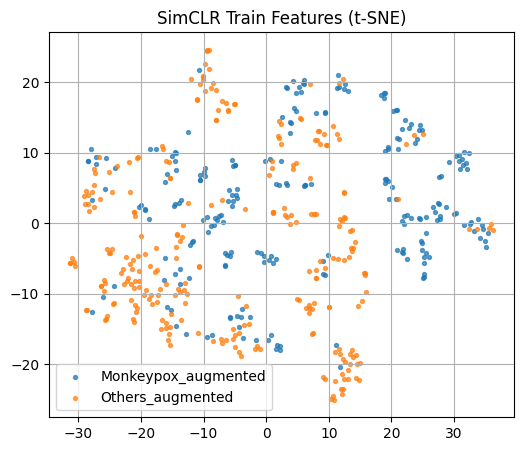

In [11]:
def extract_features(dataloader, encoder):
    encoder.eval()
    feats, labs = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            h = encoder(imgs)  # [B, 2048]
            feats.append(h.cpu().numpy())
            labs.append(labels.numpy())
    feats = np.concatenate(feats, axis=0)
    labs = np.concatenate(labs, axis=0)
    return feats, labs

def subset_for_vis(dataloader, max_samples=1000):
    xs, ys = [], []
    total = 0
    for imgs, labels in dataloader:
        if total >= max_samples:
            break
        take = min(imgs.size(0), max_samples - total)
        xs.append(imgs[:take])
        ys.append(labels[:take])
        total += take
    X = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    return DataLoader(list(zip(X, y)), batch_size=BATCH_SIZE_SUP, shuffle=False)

# Build a small vis set from the train_down set
vis_loader = subset_for_vis(train_down_loader, max_samples=1000)

# Reload a plain ResNet50 encoder and load weights (ensures clean .eval() model)
encoder_vis = models.resnet50(weights=None)
encoder_vis.fc = nn.Identity()
encoder_vis.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"), map_location=DEVICE))
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

# t-SNE (2D)
print("Computing t-SNE on train features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (t-SNE)")
plt.grid(True)
plt.show()

Computing UMAP on train features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


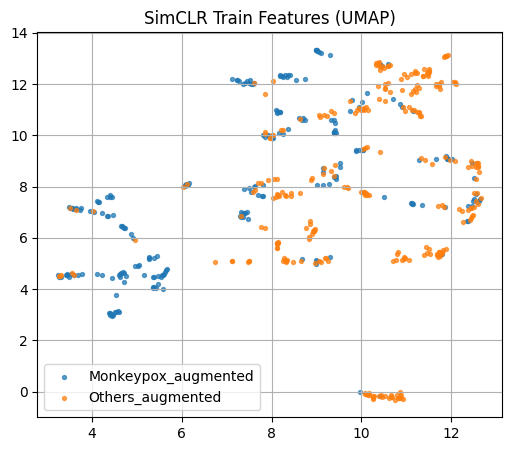

In [12]:
print("Computing UMAP on train features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (UMAP)")
plt.grid(True)
plt.show()

****SSL Loss Curve****

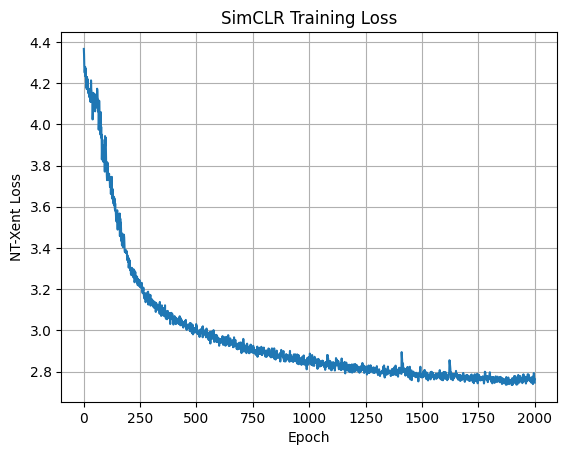

In [13]:
plot_curve(ssl_loss_history, "SimCLR Training Loss", "Epoch", "NT-Xent Loss")


****Downstream Linear Evaluation****

In [14]:
# Freeze encoder, train linear classifier on train_down, validate on val_down
encoder_linear = models.resnet50(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet50_encoder.pth"), map_location=DEVICE))
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    # Train classifier
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_down_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)
        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    # Validate
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_down_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feats = encoder_linear(imgs)
            logits = classifier(feats)
            loss = criterion_ce(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    lin_val_losses.append(val_loss)
    lin_val_accs.append(val_acc)
    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f} | ValLoss={val_loss:.4f} Acc={val_acc:.3f}")


Starting linear evaluation...


Linear Epoch 1/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1: TrainLoss=0.6790 Acc=0.618 | ValLoss=0.5469 Acc=0.727


Linear Epoch 2/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 2: TrainLoss=0.5161 Acc=0.765 | ValLoss=0.4787 Acc=0.766


Linear Epoch 3/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 3: TrainLoss=0.4676 Acc=0.792 | ValLoss=0.4578 Acc=0.781


Linear Epoch 4/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 4: TrainLoss=0.4551 Acc=0.800 | ValLoss=0.4480 Acc=0.797


Linear Epoch 5/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 5: TrainLoss=0.4419 Acc=0.812 | ValLoss=0.4276 Acc=0.789


Linear Epoch 6/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 6: TrainLoss=0.4322 Acc=0.822 | ValLoss=0.4195 Acc=0.797


Linear Epoch 7/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 7: TrainLoss=0.4155 Acc=0.822 | ValLoss=0.4132 Acc=0.812


Linear Epoch 8/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 8: TrainLoss=0.4078 Acc=0.831 | ValLoss=0.4106 Acc=0.812


Linear Epoch 9/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 9: TrainLoss=0.4018 Acc=0.833 | ValLoss=0.4119 Acc=0.812


Linear Epoch 10/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 10: TrainLoss=0.3997 Acc=0.829 | ValLoss=0.4108 Acc=0.828


Linear Epoch 11/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 11: TrainLoss=0.3999 Acc=0.835 | ValLoss=0.4142 Acc=0.797


Linear Epoch 12/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 12: TrainLoss=0.3976 Acc=0.835 | ValLoss=0.4026 Acc=0.812


Linear Epoch 13/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 13: TrainLoss=0.3883 Acc=0.827 | ValLoss=0.4031 Acc=0.836


Linear Epoch 14/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 14: TrainLoss=0.3854 Acc=0.839 | ValLoss=0.4027 Acc=0.805


Linear Epoch 15/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 15: TrainLoss=0.3790 Acc=0.847 | ValLoss=0.3968 Acc=0.820


Linear Epoch 16/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 16: TrainLoss=0.3754 Acc=0.831 | ValLoss=0.3959 Acc=0.820


Linear Epoch 17/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 17: TrainLoss=0.3707 Acc=0.845 | ValLoss=0.3925 Acc=0.828


Linear Epoch 18/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 18: TrainLoss=0.3693 Acc=0.851 | ValLoss=0.3961 Acc=0.820


Linear Epoch 19/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 19: TrainLoss=0.3699 Acc=0.841 | ValLoss=0.3931 Acc=0.828


Linear Epoch 20/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 20: TrainLoss=0.3699 Acc=0.837 | ValLoss=0.3876 Acc=0.820


Linear Epoch 21/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 21: TrainLoss=0.3708 Acc=0.847 | ValLoss=0.3948 Acc=0.812


Linear Epoch 22/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 22: TrainLoss=0.3661 Acc=0.839 | ValLoss=0.3891 Acc=0.844


Linear Epoch 23/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 23: TrainLoss=0.3649 Acc=0.839 | ValLoss=0.3851 Acc=0.828


Linear Epoch 24/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 24: TrainLoss=0.3608 Acc=0.851 | ValLoss=0.3985 Acc=0.836


Linear Epoch 25/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 25: TrainLoss=0.3579 Acc=0.847 | ValLoss=0.4080 Acc=0.844


Linear Epoch 26/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 26: TrainLoss=0.3655 Acc=0.837 | ValLoss=0.3907 Acc=0.820


Linear Epoch 27/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 27: TrainLoss=0.3568 Acc=0.855 | ValLoss=0.3804 Acc=0.828


Linear Epoch 28/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 28: TrainLoss=0.3578 Acc=0.855 | ValLoss=0.3883 Acc=0.836


Linear Epoch 29/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 29: TrainLoss=0.3475 Acc=0.857 | ValLoss=0.3831 Acc=0.836


Linear Epoch 30/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 30: TrainLoss=0.3462 Acc=0.843 | ValLoss=0.3779 Acc=0.844


Linear Epoch 31/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 31: TrainLoss=0.3423 Acc=0.865 | ValLoss=0.3769 Acc=0.836


Linear Epoch 32/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 32: TrainLoss=0.3354 Acc=0.863 | ValLoss=0.3765 Acc=0.836


Linear Epoch 33/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 33: TrainLoss=0.3357 Acc=0.851 | ValLoss=0.3743 Acc=0.836


Linear Epoch 34/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 34: TrainLoss=0.3384 Acc=0.863 | ValLoss=0.3738 Acc=0.836


Linear Epoch 35/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 35: TrainLoss=0.3313 Acc=0.859 | ValLoss=0.3690 Acc=0.836


Linear Epoch 36/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 36: TrainLoss=0.3341 Acc=0.853 | ValLoss=0.3683 Acc=0.836


Linear Epoch 37/2000: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


Linear Epoch 37: TrainLoss=0.3332 Acc=0.853 | ValLoss=0.3806 Acc=0.836


Linear Epoch 38/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 38: TrainLoss=0.3312 Acc=0.863 | ValLoss=0.3791 Acc=0.859


Linear Epoch 39/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 39: TrainLoss=0.3267 Acc=0.865 | ValLoss=0.3749 Acc=0.836


Linear Epoch 40/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 40: TrainLoss=0.3234 Acc=0.863 | ValLoss=0.3693 Acc=0.844


Linear Epoch 41/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 41: TrainLoss=0.3348 Acc=0.865 | ValLoss=0.3694 Acc=0.836


Linear Epoch 42/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 42: TrainLoss=0.3189 Acc=0.863 | ValLoss=0.3649 Acc=0.844


Linear Epoch 43/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 43: TrainLoss=0.3208 Acc=0.873 | ValLoss=0.3644 Acc=0.852


Linear Epoch 44/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 44: TrainLoss=0.3207 Acc=0.871 | ValLoss=0.3653 Acc=0.844


Linear Epoch 45/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 45: TrainLoss=0.3183 Acc=0.867 | ValLoss=0.3605 Acc=0.852


Linear Epoch 46/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 46: TrainLoss=0.3169 Acc=0.873 | ValLoss=0.3611 Acc=0.852


Linear Epoch 47/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 47: TrainLoss=0.3144 Acc=0.875 | ValLoss=0.3592 Acc=0.852


Linear Epoch 48/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 48: TrainLoss=0.3125 Acc=0.871 | ValLoss=0.3600 Acc=0.852


Linear Epoch 49/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 49: TrainLoss=0.3113 Acc=0.875 | ValLoss=0.3641 Acc=0.844


Linear Epoch 50/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 50: TrainLoss=0.3081 Acc=0.865 | ValLoss=0.3622 Acc=0.852


Linear Epoch 51/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 51: TrainLoss=0.3148 Acc=0.876 | ValLoss=0.3628 Acc=0.844


Linear Epoch 52/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 52: TrainLoss=0.3086 Acc=0.867 | ValLoss=0.3550 Acc=0.852


Linear Epoch 53/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 53: TrainLoss=0.3070 Acc=0.869 | ValLoss=0.3563 Acc=0.852


Linear Epoch 54/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 54: TrainLoss=0.3161 Acc=0.873 | ValLoss=0.3612 Acc=0.852


Linear Epoch 55/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 55: TrainLoss=0.3067 Acc=0.878 | ValLoss=0.3536 Acc=0.844


Linear Epoch 56/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 56: TrainLoss=0.3051 Acc=0.871 | ValLoss=0.3561 Acc=0.852


Linear Epoch 57/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 57: TrainLoss=0.3007 Acc=0.880 | ValLoss=0.3617 Acc=0.844


Linear Epoch 58/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 58: TrainLoss=0.3061 Acc=0.878 | ValLoss=0.3674 Acc=0.867


Linear Epoch 59/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 59: TrainLoss=0.3078 Acc=0.880 | ValLoss=0.3534 Acc=0.852


Linear Epoch 60/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 60: TrainLoss=0.3000 Acc=0.875 | ValLoss=0.3501 Acc=0.852


Linear Epoch 61/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 61: TrainLoss=0.2969 Acc=0.875 | ValLoss=0.3493 Acc=0.852


Linear Epoch 62/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 62: TrainLoss=0.2949 Acc=0.876 | ValLoss=0.3499 Acc=0.852


Linear Epoch 63/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 63: TrainLoss=0.2950 Acc=0.880 | ValLoss=0.3482 Acc=0.852


Linear Epoch 64/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 64: TrainLoss=0.2927 Acc=0.873 | ValLoss=0.3472 Acc=0.852


Linear Epoch 65/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 65: TrainLoss=0.2919 Acc=0.886 | ValLoss=0.3564 Acc=0.852


Linear Epoch 66/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 66: TrainLoss=0.2903 Acc=0.873 | ValLoss=0.3579 Acc=0.859


Linear Epoch 67/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 67: TrainLoss=0.3039 Acc=0.882 | ValLoss=0.4153 Acc=0.797


Linear Epoch 68/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 68: TrainLoss=0.3381 Acc=0.855 | ValLoss=0.3736 Acc=0.859


Linear Epoch 69/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 69: TrainLoss=0.3053 Acc=0.873 | ValLoss=0.3613 Acc=0.836


Linear Epoch 70/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 70: TrainLoss=0.2964 Acc=0.878 | ValLoss=0.3458 Acc=0.852


Linear Epoch 71/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 71: TrainLoss=0.2883 Acc=0.876 | ValLoss=0.3429 Acc=0.852


Linear Epoch 72/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 72: TrainLoss=0.2908 Acc=0.876 | ValLoss=0.3518 Acc=0.844


Linear Epoch 73/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 73: TrainLoss=0.2865 Acc=0.884 | ValLoss=0.3479 Acc=0.875


Linear Epoch 74/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 74: TrainLoss=0.2942 Acc=0.880 | ValLoss=0.3435 Acc=0.852


Linear Epoch 75/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 75: TrainLoss=0.2936 Acc=0.884 | ValLoss=0.3452 Acc=0.852


Linear Epoch 76/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 76: TrainLoss=0.2825 Acc=0.878 | ValLoss=0.3385 Acc=0.859


Linear Epoch 77/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 77: TrainLoss=0.2785 Acc=0.888 | ValLoss=0.3387 Acc=0.852


Linear Epoch 78/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 78: TrainLoss=0.2785 Acc=0.890 | ValLoss=0.3404 Acc=0.852


Linear Epoch 79/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 79: TrainLoss=0.2793 Acc=0.888 | ValLoss=0.3409 Acc=0.852


Linear Epoch 80/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 80: TrainLoss=0.2757 Acc=0.882 | ValLoss=0.3378 Acc=0.852


Linear Epoch 81/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 81: TrainLoss=0.2751 Acc=0.890 | ValLoss=0.3382 Acc=0.852


Linear Epoch 82/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 82: TrainLoss=0.2742 Acc=0.894 | ValLoss=0.3390 Acc=0.852


Linear Epoch 83/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 83: TrainLoss=0.2731 Acc=0.886 | ValLoss=0.3364 Acc=0.859


Linear Epoch 84/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 84: TrainLoss=0.2738 Acc=0.890 | ValLoss=0.3446 Acc=0.859


Linear Epoch 85/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 85: TrainLoss=0.2751 Acc=0.886 | ValLoss=0.3385 Acc=0.867


Linear Epoch 86/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 86: TrainLoss=0.2762 Acc=0.884 | ValLoss=0.3378 Acc=0.859


Linear Epoch 87/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 87: TrainLoss=0.2721 Acc=0.894 | ValLoss=0.3356 Acc=0.867


Linear Epoch 88/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 88: TrainLoss=0.2725 Acc=0.888 | ValLoss=0.3341 Acc=0.852


Linear Epoch 89/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 89: TrainLoss=0.2697 Acc=0.888 | ValLoss=0.3332 Acc=0.852


Linear Epoch 90/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 90: TrainLoss=0.2671 Acc=0.888 | ValLoss=0.3312 Acc=0.859


Linear Epoch 91/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 91: TrainLoss=0.2663 Acc=0.898 | ValLoss=0.3307 Acc=0.852


Linear Epoch 92/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 92: TrainLoss=0.2681 Acc=0.896 | ValLoss=0.3313 Acc=0.852


Linear Epoch 93/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 93: TrainLoss=0.2702 Acc=0.890 | ValLoss=0.3340 Acc=0.875


Linear Epoch 94/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 94: TrainLoss=0.2691 Acc=0.894 | ValLoss=0.3300 Acc=0.859


Linear Epoch 95/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 95: TrainLoss=0.2671 Acc=0.894 | ValLoss=0.3298 Acc=0.859


Linear Epoch 96/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 96: TrainLoss=0.2648 Acc=0.894 | ValLoss=0.3274 Acc=0.859


Linear Epoch 97/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 97: TrainLoss=0.2653 Acc=0.904 | ValLoss=0.3271 Acc=0.859


Linear Epoch 98/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 98: TrainLoss=0.2648 Acc=0.888 | ValLoss=0.3290 Acc=0.867


Linear Epoch 99/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 99: TrainLoss=0.2648 Acc=0.896 | ValLoss=0.3271 Acc=0.859


Linear Epoch 100/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 100: TrainLoss=0.2616 Acc=0.894 | ValLoss=0.3265 Acc=0.859


Linear Epoch 101/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 101: TrainLoss=0.2606 Acc=0.906 | ValLoss=0.3272 Acc=0.867


Linear Epoch 102/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 102: TrainLoss=0.2583 Acc=0.900 | ValLoss=0.3289 Acc=0.859


Linear Epoch 103/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 103: TrainLoss=0.2606 Acc=0.900 | ValLoss=0.3252 Acc=0.859


Linear Epoch 104/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 104: TrainLoss=0.2547 Acc=0.900 | ValLoss=0.3246 Acc=0.859


Linear Epoch 105/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 105: TrainLoss=0.2617 Acc=0.896 | ValLoss=0.3311 Acc=0.852


Linear Epoch 106/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 106: TrainLoss=0.2563 Acc=0.904 | ValLoss=0.3265 Acc=0.875


Linear Epoch 107/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 107: TrainLoss=0.2555 Acc=0.906 | ValLoss=0.3308 Acc=0.867


Linear Epoch 108/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 108: TrainLoss=0.2557 Acc=0.896 | ValLoss=0.3194 Acc=0.867


Linear Epoch 109/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 109: TrainLoss=0.2532 Acc=0.892 | ValLoss=0.3194 Acc=0.867


Linear Epoch 110/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 110: TrainLoss=0.2516 Acc=0.896 | ValLoss=0.3188 Acc=0.859


Linear Epoch 111/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 111: TrainLoss=0.2508 Acc=0.896 | ValLoss=0.3184 Acc=0.859


Linear Epoch 112/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 112: TrainLoss=0.2505 Acc=0.904 | ValLoss=0.3175 Acc=0.867


Linear Epoch 113/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 113: TrainLoss=0.2482 Acc=0.902 | ValLoss=0.3189 Acc=0.859


Linear Epoch 114/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 114: TrainLoss=0.2470 Acc=0.904 | ValLoss=0.3215 Acc=0.875


Linear Epoch 115/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 115: TrainLoss=0.2491 Acc=0.904 | ValLoss=0.3212 Acc=0.875


Linear Epoch 116/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 116: TrainLoss=0.2496 Acc=0.910 | ValLoss=0.3178 Acc=0.867


Linear Epoch 117/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 117: TrainLoss=0.2454 Acc=0.896 | ValLoss=0.3188 Acc=0.867


Linear Epoch 118/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 118: TrainLoss=0.2513 Acc=0.902 | ValLoss=0.3153 Acc=0.875


Linear Epoch 119/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 119: TrainLoss=0.2467 Acc=0.902 | ValLoss=0.3130 Acc=0.859


Linear Epoch 120/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 120: TrainLoss=0.2436 Acc=0.908 | ValLoss=0.3129 Acc=0.867


Linear Epoch 121/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 121: TrainLoss=0.2443 Acc=0.908 | ValLoss=0.3145 Acc=0.867


Linear Epoch 122/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 122: TrainLoss=0.2438 Acc=0.904 | ValLoss=0.3155 Acc=0.859


Linear Epoch 123/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 123: TrainLoss=0.2443 Acc=0.898 | ValLoss=0.3222 Acc=0.867


Linear Epoch 124/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 124: TrainLoss=0.2451 Acc=0.908 | ValLoss=0.3203 Acc=0.883


Linear Epoch 125/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 125: TrainLoss=0.2470 Acc=0.908 | ValLoss=0.3108 Acc=0.875


Linear Epoch 126/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 126: TrainLoss=0.2414 Acc=0.908 | ValLoss=0.3143 Acc=0.867


Linear Epoch 127/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 127: TrainLoss=0.2407 Acc=0.906 | ValLoss=0.3110 Acc=0.883


Linear Epoch 128/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 128: TrainLoss=0.2420 Acc=0.906 | ValLoss=0.3108 Acc=0.875


Linear Epoch 129/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 129: TrainLoss=0.2376 Acc=0.916 | ValLoss=0.3066 Acc=0.875


Linear Epoch 130/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 130: TrainLoss=0.2406 Acc=0.904 | ValLoss=0.3159 Acc=0.867


Linear Epoch 131/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 131: TrainLoss=0.2423 Acc=0.908 | ValLoss=0.3087 Acc=0.875


Linear Epoch 132/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 132: TrainLoss=0.2461 Acc=0.902 | ValLoss=0.3103 Acc=0.891


Linear Epoch 133/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 133: TrainLoss=0.2367 Acc=0.910 | ValLoss=0.3076 Acc=0.875


Linear Epoch 134/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 134: TrainLoss=0.2415 Acc=0.908 | ValLoss=0.3191 Acc=0.875


Linear Epoch 135/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 135: TrainLoss=0.2500 Acc=0.904 | ValLoss=0.3173 Acc=0.875


Linear Epoch 136/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 136: TrainLoss=0.2400 Acc=0.912 | ValLoss=0.3052 Acc=0.875


Linear Epoch 137/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 137: TrainLoss=0.2364 Acc=0.910 | ValLoss=0.3046 Acc=0.875


Linear Epoch 138/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 138: TrainLoss=0.2424 Acc=0.900 | ValLoss=0.3135 Acc=0.875


Linear Epoch 139/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 139: TrainLoss=0.2455 Acc=0.906 | ValLoss=0.3122 Acc=0.891


Linear Epoch 140/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 140: TrainLoss=0.2311 Acc=0.914 | ValLoss=0.3346 Acc=0.836


Linear Epoch 141/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 141: TrainLoss=0.2394 Acc=0.908 | ValLoss=0.3143 Acc=0.883


Linear Epoch 142/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 142: TrainLoss=0.2346 Acc=0.908 | ValLoss=0.3102 Acc=0.875


Linear Epoch 143/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 143: TrainLoss=0.2320 Acc=0.912 | ValLoss=0.3035 Acc=0.875


Linear Epoch 144/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 144: TrainLoss=0.2360 Acc=0.910 | ValLoss=0.3071 Acc=0.891


Linear Epoch 145/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 145: TrainLoss=0.2356 Acc=0.916 | ValLoss=0.3256 Acc=0.844


Linear Epoch 146/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 146: TrainLoss=0.2496 Acc=0.894 | ValLoss=0.3129 Acc=0.891


Linear Epoch 147/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 147: TrainLoss=0.2417 Acc=0.906 | ValLoss=0.3073 Acc=0.875


Linear Epoch 148/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 148: TrainLoss=0.2343 Acc=0.906 | ValLoss=0.3038 Acc=0.875


Linear Epoch 149/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 149: TrainLoss=0.2321 Acc=0.914 | ValLoss=0.3041 Acc=0.883


Linear Epoch 150/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 150: TrainLoss=0.2277 Acc=0.916 | ValLoss=0.3137 Acc=0.867


Linear Epoch 151/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 151: TrainLoss=0.2464 Acc=0.908 | ValLoss=0.3267 Acc=0.883


Linear Epoch 152/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 152: TrainLoss=0.2475 Acc=0.890 | ValLoss=0.3078 Acc=0.875


Linear Epoch 153/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 153: TrainLoss=0.2270 Acc=0.910 | ValLoss=0.2985 Acc=0.883


Linear Epoch 154/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 154: TrainLoss=0.2262 Acc=0.918 | ValLoss=0.2980 Acc=0.883


Linear Epoch 155/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 155: TrainLoss=0.2269 Acc=0.910 | ValLoss=0.3067 Acc=0.875


Linear Epoch 156/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 156: TrainLoss=0.2270 Acc=0.916 | ValLoss=0.3073 Acc=0.891


Linear Epoch 157/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 157: TrainLoss=0.2330 Acc=0.906 | ValLoss=0.3079 Acc=0.867


Linear Epoch 158/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 158: TrainLoss=0.2202 Acc=0.918 | ValLoss=0.2993 Acc=0.891


Linear Epoch 159/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 159: TrainLoss=0.2223 Acc=0.924 | ValLoss=0.2965 Acc=0.883


Linear Epoch 160/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 160: TrainLoss=0.2186 Acc=0.920 | ValLoss=0.2964 Acc=0.883


Linear Epoch 161/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 161: TrainLoss=0.2206 Acc=0.918 | ValLoss=0.2993 Acc=0.875


Linear Epoch 162/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 162: TrainLoss=0.2200 Acc=0.929 | ValLoss=0.2951 Acc=0.891


Linear Epoch 163/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 163: TrainLoss=0.2182 Acc=0.918 | ValLoss=0.2935 Acc=0.891


Linear Epoch 164/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 164: TrainLoss=0.2161 Acc=0.922 | ValLoss=0.2936 Acc=0.883


Linear Epoch 165/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 165: TrainLoss=0.2158 Acc=0.924 | ValLoss=0.2925 Acc=0.891


Linear Epoch 166/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 166: TrainLoss=0.2157 Acc=0.924 | ValLoss=0.2917 Acc=0.898


Linear Epoch 167/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 167: TrainLoss=0.2150 Acc=0.924 | ValLoss=0.2918 Acc=0.891


Linear Epoch 168/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 168: TrainLoss=0.2147 Acc=0.929 | ValLoss=0.2905 Acc=0.898


Linear Epoch 169/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 169: TrainLoss=0.2175 Acc=0.920 | ValLoss=0.2917 Acc=0.891


Linear Epoch 170/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 170: TrainLoss=0.2187 Acc=0.914 | ValLoss=0.3022 Acc=0.867


Linear Epoch 171/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 171: TrainLoss=0.2229 Acc=0.918 | ValLoss=0.3060 Acc=0.891


Linear Epoch 172/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 172: TrainLoss=0.2289 Acc=0.916 | ValLoss=0.2993 Acc=0.875


Linear Epoch 173/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 173: TrainLoss=0.2193 Acc=0.914 | ValLoss=0.2908 Acc=0.883


Linear Epoch 174/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 174: TrainLoss=0.2135 Acc=0.924 | ValLoss=0.2914 Acc=0.875


Linear Epoch 175/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 175: TrainLoss=0.2142 Acc=0.925 | ValLoss=0.2921 Acc=0.875


Linear Epoch 176/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 176: TrainLoss=0.2107 Acc=0.925 | ValLoss=0.2877 Acc=0.898


Linear Epoch 177/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 177: TrainLoss=0.2094 Acc=0.927 | ValLoss=0.2891 Acc=0.891


Linear Epoch 178/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 178: TrainLoss=0.2109 Acc=0.927 | ValLoss=0.2867 Acc=0.898


Linear Epoch 179/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 179: TrainLoss=0.2116 Acc=0.929 | ValLoss=0.2907 Acc=0.875


Linear Epoch 180/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 180: TrainLoss=0.2077 Acc=0.916 | ValLoss=0.2882 Acc=0.898


Linear Epoch 181/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 181: TrainLoss=0.2089 Acc=0.925 | ValLoss=0.2876 Acc=0.875


Linear Epoch 182/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 182: TrainLoss=0.2097 Acc=0.922 | ValLoss=0.2907 Acc=0.867


Linear Epoch 183/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 183: TrainLoss=0.2093 Acc=0.929 | ValLoss=0.2884 Acc=0.891


Linear Epoch 184/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 184: TrainLoss=0.2078 Acc=0.933 | ValLoss=0.2917 Acc=0.875


Linear Epoch 185/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 185: TrainLoss=0.2139 Acc=0.924 | ValLoss=0.2838 Acc=0.891


Linear Epoch 186/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 186: TrainLoss=0.2202 Acc=0.925 | ValLoss=0.2921 Acc=0.891


Linear Epoch 187/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 187: TrainLoss=0.2150 Acc=0.929 | ValLoss=0.2854 Acc=0.891


Linear Epoch 188/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 188: TrainLoss=0.2064 Acc=0.929 | ValLoss=0.2838 Acc=0.898


Linear Epoch 189/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 189: TrainLoss=0.2070 Acc=0.925 | ValLoss=0.2829 Acc=0.898


Linear Epoch 190/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 190: TrainLoss=0.2057 Acc=0.929 | ValLoss=0.2867 Acc=0.867


Linear Epoch 191/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 191: TrainLoss=0.2060 Acc=0.931 | ValLoss=0.2824 Acc=0.891


Linear Epoch 192/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 192: TrainLoss=0.2038 Acc=0.933 | ValLoss=0.2800 Acc=0.891


Linear Epoch 193/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 193: TrainLoss=0.2036 Acc=0.931 | ValLoss=0.2801 Acc=0.898


Linear Epoch 194/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 194: TrainLoss=0.2053 Acc=0.931 | ValLoss=0.2827 Acc=0.898


Linear Epoch 195/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 195: TrainLoss=0.2012 Acc=0.935 | ValLoss=0.2861 Acc=0.883


Linear Epoch 196/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 196: TrainLoss=0.2074 Acc=0.922 | ValLoss=0.2843 Acc=0.891


Linear Epoch 197/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 197: TrainLoss=0.2064 Acc=0.931 | ValLoss=0.2802 Acc=0.891


Linear Epoch 198/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 198: TrainLoss=0.2007 Acc=0.929 | ValLoss=0.2798 Acc=0.891


Linear Epoch 199/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 199: TrainLoss=0.2018 Acc=0.922 | ValLoss=0.2796 Acc=0.891


Linear Epoch 200/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 200: TrainLoss=0.2090 Acc=0.918 | ValLoss=0.3046 Acc=0.875


Linear Epoch 201/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 201: TrainLoss=0.2153 Acc=0.925 | ValLoss=0.2958 Acc=0.891


Linear Epoch 202/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 202: TrainLoss=0.2340 Acc=0.888 | ValLoss=0.3042 Acc=0.867


Linear Epoch 203/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 203: TrainLoss=0.1979 Acc=0.933 | ValLoss=0.2897 Acc=0.891


Linear Epoch 204/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 204: TrainLoss=0.2047 Acc=0.918 | ValLoss=0.2837 Acc=0.867


Linear Epoch 205/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 205: TrainLoss=0.1960 Acc=0.931 | ValLoss=0.2780 Acc=0.898


Linear Epoch 206/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 206: TrainLoss=0.2015 Acc=0.935 | ValLoss=0.2790 Acc=0.891


Linear Epoch 207/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 207: TrainLoss=0.1997 Acc=0.927 | ValLoss=0.2788 Acc=0.883


Linear Epoch 208/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 208: TrainLoss=0.1955 Acc=0.937 | ValLoss=0.2774 Acc=0.898


Linear Epoch 209/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 209: TrainLoss=0.1976 Acc=0.937 | ValLoss=0.2774 Acc=0.883


Linear Epoch 210/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 210: TrainLoss=0.1948 Acc=0.945 | ValLoss=0.2771 Acc=0.898


Linear Epoch 211/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 211: TrainLoss=0.1938 Acc=0.935 | ValLoss=0.2804 Acc=0.883


Linear Epoch 212/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 212: TrainLoss=0.1959 Acc=0.929 | ValLoss=0.2769 Acc=0.898


Linear Epoch 213/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 213: TrainLoss=0.1950 Acc=0.941 | ValLoss=0.2786 Acc=0.883


Linear Epoch 214/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 214: TrainLoss=0.1930 Acc=0.933 | ValLoss=0.2752 Acc=0.898


Linear Epoch 215/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 215: TrainLoss=0.1943 Acc=0.935 | ValLoss=0.2758 Acc=0.898


Linear Epoch 216/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 216: TrainLoss=0.1926 Acc=0.937 | ValLoss=0.2753 Acc=0.883


Linear Epoch 217/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 217: TrainLoss=0.1963 Acc=0.937 | ValLoss=0.2787 Acc=0.891


Linear Epoch 218/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 218: TrainLoss=0.1918 Acc=0.947 | ValLoss=0.2786 Acc=0.867


Linear Epoch 219/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 219: TrainLoss=0.2000 Acc=0.937 | ValLoss=0.2734 Acc=0.898


Linear Epoch 220/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 220: TrainLoss=0.1982 Acc=0.927 | ValLoss=0.2723 Acc=0.898


Linear Epoch 221/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 221: TrainLoss=0.1988 Acc=0.920 | ValLoss=0.2799 Acc=0.883


Linear Epoch 222/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 222: TrainLoss=0.1931 Acc=0.937 | ValLoss=0.2743 Acc=0.898


Linear Epoch 223/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 223: TrainLoss=0.1881 Acc=0.945 | ValLoss=0.2768 Acc=0.883


Linear Epoch 224/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 224: TrainLoss=0.1906 Acc=0.943 | ValLoss=0.2745 Acc=0.898


Linear Epoch 225/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 225: TrainLoss=0.1875 Acc=0.939 | ValLoss=0.2717 Acc=0.898


Linear Epoch 226/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 226: TrainLoss=0.1891 Acc=0.939 | ValLoss=0.2700 Acc=0.891


Linear Epoch 227/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 227: TrainLoss=0.1902 Acc=0.941 | ValLoss=0.2773 Acc=0.875


Linear Epoch 228/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 228: TrainLoss=0.1892 Acc=0.939 | ValLoss=0.2727 Acc=0.891


Linear Epoch 229/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 229: TrainLoss=0.1885 Acc=0.945 | ValLoss=0.2762 Acc=0.883


Linear Epoch 230/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 230: TrainLoss=0.1873 Acc=0.941 | ValLoss=0.2696 Acc=0.891


Linear Epoch 231/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 231: TrainLoss=0.1877 Acc=0.939 | ValLoss=0.2691 Acc=0.898


Linear Epoch 232/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 232: TrainLoss=0.1880 Acc=0.945 | ValLoss=0.2694 Acc=0.891


Linear Epoch 233/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 233: TrainLoss=0.1865 Acc=0.941 | ValLoss=0.2736 Acc=0.891


Linear Epoch 234/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 234: TrainLoss=0.1863 Acc=0.937 | ValLoss=0.2690 Acc=0.898


Linear Epoch 235/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 235: TrainLoss=0.1864 Acc=0.933 | ValLoss=0.2796 Acc=0.883


Linear Epoch 236/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 236: TrainLoss=0.1912 Acc=0.933 | ValLoss=0.2786 Acc=0.898


Linear Epoch 237/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 237: TrainLoss=0.1863 Acc=0.935 | ValLoss=0.2814 Acc=0.875


Linear Epoch 238/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 238: TrainLoss=0.1882 Acc=0.931 | ValLoss=0.2753 Acc=0.898


Linear Epoch 239/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 239: TrainLoss=0.1889 Acc=0.929 | ValLoss=0.2722 Acc=0.898


Linear Epoch 240/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 240: TrainLoss=0.1821 Acc=0.945 | ValLoss=0.2704 Acc=0.898


Linear Epoch 241/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 241: TrainLoss=0.1856 Acc=0.941 | ValLoss=0.2692 Acc=0.891


Linear Epoch 242/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 242: TrainLoss=0.1837 Acc=0.947 | ValLoss=0.2670 Acc=0.898


Linear Epoch 243/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 243: TrainLoss=0.1821 Acc=0.951 | ValLoss=0.2676 Acc=0.891


Linear Epoch 244/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 244: TrainLoss=0.1808 Acc=0.947 | ValLoss=0.2694 Acc=0.898


Linear Epoch 245/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 245: TrainLoss=0.1854 Acc=0.941 | ValLoss=0.2665 Acc=0.898


Linear Epoch 246/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 246: TrainLoss=0.1792 Acc=0.947 | ValLoss=0.2641 Acc=0.898


Linear Epoch 247/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 247: TrainLoss=0.1808 Acc=0.955 | ValLoss=0.2639 Acc=0.898


Linear Epoch 248/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 248: TrainLoss=0.1796 Acc=0.945 | ValLoss=0.2639 Acc=0.891


Linear Epoch 249/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 249: TrainLoss=0.1786 Acc=0.945 | ValLoss=0.2653 Acc=0.898


Linear Epoch 250/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 250: TrainLoss=0.1842 Acc=0.933 | ValLoss=0.2691 Acc=0.891


Linear Epoch 251/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 251: TrainLoss=0.1793 Acc=0.941 | ValLoss=0.2633 Acc=0.898


Linear Epoch 252/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 252: TrainLoss=0.1820 Acc=0.949 | ValLoss=0.2631 Acc=0.891


Linear Epoch 253/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 253: TrainLoss=0.1802 Acc=0.951 | ValLoss=0.2661 Acc=0.898


Linear Epoch 254/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 254: TrainLoss=0.1772 Acc=0.947 | ValLoss=0.2648 Acc=0.891


Linear Epoch 255/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 255: TrainLoss=0.1784 Acc=0.947 | ValLoss=0.2679 Acc=0.891


Linear Epoch 256/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 256: TrainLoss=0.1760 Acc=0.945 | ValLoss=0.2604 Acc=0.898


Linear Epoch 257/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 257: TrainLoss=0.1788 Acc=0.943 | ValLoss=0.2620 Acc=0.898


Linear Epoch 258/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 258: TrainLoss=0.1771 Acc=0.945 | ValLoss=0.2633 Acc=0.898


Linear Epoch 259/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 259: TrainLoss=0.1760 Acc=0.951 | ValLoss=0.2614 Acc=0.898


Linear Epoch 260/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 260: TrainLoss=0.1745 Acc=0.953 | ValLoss=0.2594 Acc=0.898


Linear Epoch 261/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 261: TrainLoss=0.1764 Acc=0.951 | ValLoss=0.2599 Acc=0.891


Linear Epoch 262/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 262: TrainLoss=0.1753 Acc=0.949 | ValLoss=0.2596 Acc=0.891


Linear Epoch 263/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 263: TrainLoss=0.1745 Acc=0.955 | ValLoss=0.2610 Acc=0.891


Linear Epoch 264/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 264: TrainLoss=0.1760 Acc=0.951 | ValLoss=0.2623 Acc=0.898


Linear Epoch 265/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 265: TrainLoss=0.1792 Acc=0.941 | ValLoss=0.2665 Acc=0.898


Linear Epoch 266/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 266: TrainLoss=0.1808 Acc=0.933 | ValLoss=0.2780 Acc=0.875


Linear Epoch 267/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 267: TrainLoss=0.1875 Acc=0.929 | ValLoss=0.2631 Acc=0.898


Linear Epoch 268/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 268: TrainLoss=0.1854 Acc=0.937 | ValLoss=0.2573 Acc=0.898


Linear Epoch 269/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 269: TrainLoss=0.1747 Acc=0.947 | ValLoss=0.2582 Acc=0.898


Linear Epoch 270/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 270: TrainLoss=0.1732 Acc=0.945 | ValLoss=0.2591 Acc=0.898


Linear Epoch 271/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 271: TrainLoss=0.1784 Acc=0.939 | ValLoss=0.2655 Acc=0.891


Linear Epoch 272/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 272: TrainLoss=0.1737 Acc=0.953 | ValLoss=0.2578 Acc=0.891


Linear Epoch 273/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 273: TrainLoss=0.1725 Acc=0.955 | ValLoss=0.2576 Acc=0.898


Linear Epoch 274/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 274: TrainLoss=0.1749 Acc=0.945 | ValLoss=0.2651 Acc=0.891


Linear Epoch 275/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 275: TrainLoss=0.1805 Acc=0.943 | ValLoss=0.2560 Acc=0.898


Linear Epoch 276/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 276: TrainLoss=0.1688 Acc=0.955 | ValLoss=0.2554 Acc=0.898


Linear Epoch 277/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 277: TrainLoss=0.1686 Acc=0.957 | ValLoss=0.2534 Acc=0.898


Linear Epoch 278/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 278: TrainLoss=0.1678 Acc=0.957 | ValLoss=0.2539 Acc=0.898


Linear Epoch 279/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 279: TrainLoss=0.1683 Acc=0.957 | ValLoss=0.2547 Acc=0.898


Linear Epoch 280/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 280: TrainLoss=0.1696 Acc=0.947 | ValLoss=0.2639 Acc=0.891


Linear Epoch 281/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 281: TrainLoss=0.1762 Acc=0.945 | ValLoss=0.2565 Acc=0.898


Linear Epoch 282/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 282: TrainLoss=0.1767 Acc=0.951 | ValLoss=0.2573 Acc=0.906


Linear Epoch 283/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 283: TrainLoss=0.1698 Acc=0.941 | ValLoss=0.2679 Acc=0.883


Linear Epoch 284/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 284: TrainLoss=0.1726 Acc=0.947 | ValLoss=0.2539 Acc=0.906


Linear Epoch 285/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 285: TrainLoss=0.1668 Acc=0.953 | ValLoss=0.2580 Acc=0.906


Linear Epoch 286/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 286: TrainLoss=0.1704 Acc=0.951 | ValLoss=0.2533 Acc=0.898


Linear Epoch 287/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 287: TrainLoss=0.1746 Acc=0.945 | ValLoss=0.2552 Acc=0.906


Linear Epoch 288/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 288: TrainLoss=0.1758 Acc=0.941 | ValLoss=0.2579 Acc=0.891


Linear Epoch 289/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 289: TrainLoss=0.1634 Acc=0.957 | ValLoss=0.2539 Acc=0.906


Linear Epoch 290/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 290: TrainLoss=0.1662 Acc=0.955 | ValLoss=0.2563 Acc=0.891


Linear Epoch 291/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 291: TrainLoss=0.1649 Acc=0.953 | ValLoss=0.2537 Acc=0.898


Linear Epoch 292/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 292: TrainLoss=0.1663 Acc=0.953 | ValLoss=0.2541 Acc=0.898


Linear Epoch 293/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 293: TrainLoss=0.1677 Acc=0.943 | ValLoss=0.2636 Acc=0.891


Linear Epoch 294/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 294: TrainLoss=0.1642 Acc=0.965 | ValLoss=0.2526 Acc=0.898


Linear Epoch 295/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 295: TrainLoss=0.1642 Acc=0.955 | ValLoss=0.2616 Acc=0.891


Linear Epoch 296/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 296: TrainLoss=0.1668 Acc=0.959 | ValLoss=0.2542 Acc=0.898


Linear Epoch 297/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 297: TrainLoss=0.1610 Acc=0.955 | ValLoss=0.2583 Acc=0.898


Linear Epoch 298/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 298: TrainLoss=0.1629 Acc=0.957 | ValLoss=0.2508 Acc=0.891


Linear Epoch 299/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 299: TrainLoss=0.1642 Acc=0.959 | ValLoss=0.2503 Acc=0.898


Linear Epoch 300/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 300: TrainLoss=0.1662 Acc=0.957 | ValLoss=0.2585 Acc=0.898


Linear Epoch 301/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 301: TrainLoss=0.1645 Acc=0.963 | ValLoss=0.2515 Acc=0.898


Linear Epoch 302/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 302: TrainLoss=0.1671 Acc=0.951 | ValLoss=0.2484 Acc=0.898


Linear Epoch 303/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 303: TrainLoss=0.1644 Acc=0.953 | ValLoss=0.2547 Acc=0.891


Linear Epoch 304/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 304: TrainLoss=0.1614 Acc=0.961 | ValLoss=0.2525 Acc=0.914


Linear Epoch 305/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 305: TrainLoss=0.1649 Acc=0.949 | ValLoss=0.2596 Acc=0.898


Linear Epoch 306/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 306: TrainLoss=0.1645 Acc=0.951 | ValLoss=0.2565 Acc=0.906


Linear Epoch 307/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 307: TrainLoss=0.1689 Acc=0.945 | ValLoss=0.2546 Acc=0.898


Linear Epoch 308/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 308: TrainLoss=0.1647 Acc=0.953 | ValLoss=0.2522 Acc=0.898


Linear Epoch 309/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 309: TrainLoss=0.1589 Acc=0.957 | ValLoss=0.2495 Acc=0.898


Linear Epoch 310/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 310: TrainLoss=0.1584 Acc=0.953 | ValLoss=0.2476 Acc=0.898


Linear Epoch 311/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 311: TrainLoss=0.1587 Acc=0.961 | ValLoss=0.2489 Acc=0.898


Linear Epoch 312/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 312: TrainLoss=0.1579 Acc=0.957 | ValLoss=0.2486 Acc=0.898


Linear Epoch 313/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 313: TrainLoss=0.1570 Acc=0.961 | ValLoss=0.2479 Acc=0.906


Linear Epoch 314/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 314: TrainLoss=0.1579 Acc=0.961 | ValLoss=0.2526 Acc=0.898


Linear Epoch 315/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 315: TrainLoss=0.1619 Acc=0.951 | ValLoss=0.2463 Acc=0.898


Linear Epoch 316/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 316: TrainLoss=0.1583 Acc=0.963 | ValLoss=0.2453 Acc=0.906


Linear Epoch 317/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 317: TrainLoss=0.1570 Acc=0.963 | ValLoss=0.2450 Acc=0.898


Linear Epoch 318/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 318: TrainLoss=0.1558 Acc=0.961 | ValLoss=0.2460 Acc=0.898


Linear Epoch 319/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 319: TrainLoss=0.1562 Acc=0.963 | ValLoss=0.2456 Acc=0.898


Linear Epoch 320/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 320: TrainLoss=0.1537 Acc=0.963 | ValLoss=0.2454 Acc=0.898


Linear Epoch 321/2000: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s]


Linear Epoch 321: TrainLoss=0.1567 Acc=0.961 | ValLoss=0.2491 Acc=0.898


Linear Epoch 322/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 322: TrainLoss=0.1583 Acc=0.955 | ValLoss=0.2487 Acc=0.906


Linear Epoch 323/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 323: TrainLoss=0.1544 Acc=0.963 | ValLoss=0.2441 Acc=0.898


Linear Epoch 324/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 324: TrainLoss=0.1542 Acc=0.963 | ValLoss=0.2488 Acc=0.906


Linear Epoch 325/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 325: TrainLoss=0.1539 Acc=0.965 | ValLoss=0.2449 Acc=0.906


Linear Epoch 326/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 326: TrainLoss=0.1581 Acc=0.961 | ValLoss=0.2444 Acc=0.906


Linear Epoch 327/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 327: TrainLoss=0.1529 Acc=0.965 | ValLoss=0.2464 Acc=0.906


Linear Epoch 328/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 328: TrainLoss=0.1559 Acc=0.959 | ValLoss=0.2484 Acc=0.898


Linear Epoch 329/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 329: TrainLoss=0.1537 Acc=0.959 | ValLoss=0.2443 Acc=0.898


Linear Epoch 330/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 330: TrainLoss=0.1544 Acc=0.961 | ValLoss=0.2438 Acc=0.898


Linear Epoch 331/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 331: TrainLoss=0.1548 Acc=0.957 | ValLoss=0.2507 Acc=0.898


Linear Epoch 332/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 332: TrainLoss=0.1574 Acc=0.959 | ValLoss=0.2442 Acc=0.906


Linear Epoch 333/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 333: TrainLoss=0.1563 Acc=0.953 | ValLoss=0.2521 Acc=0.898


Linear Epoch 334/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 334: TrainLoss=0.1507 Acc=0.963 | ValLoss=0.2436 Acc=0.898


Linear Epoch 335/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 335: TrainLoss=0.1500 Acc=0.965 | ValLoss=0.2481 Acc=0.891


Linear Epoch 336/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 336: TrainLoss=0.1545 Acc=0.963 | ValLoss=0.2444 Acc=0.906


Linear Epoch 337/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 337: TrainLoss=0.1562 Acc=0.953 | ValLoss=0.2579 Acc=0.898


Linear Epoch 338/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 338: TrainLoss=0.1487 Acc=0.959 | ValLoss=0.2495 Acc=0.906


Linear Epoch 339/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 339: TrainLoss=0.1662 Acc=0.947 | ValLoss=0.2656 Acc=0.898


Linear Epoch 340/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 340: TrainLoss=0.1600 Acc=0.953 | ValLoss=0.2408 Acc=0.898


Linear Epoch 341/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 341: TrainLoss=0.1568 Acc=0.955 | ValLoss=0.2404 Acc=0.898


Linear Epoch 342/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 342: TrainLoss=0.1505 Acc=0.951 | ValLoss=0.2461 Acc=0.898


Linear Epoch 343/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 343: TrainLoss=0.1506 Acc=0.969 | ValLoss=0.2396 Acc=0.898


Linear Epoch 344/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 344: TrainLoss=0.1512 Acc=0.949 | ValLoss=0.2494 Acc=0.898


Linear Epoch 345/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 345: TrainLoss=0.1536 Acc=0.959 | ValLoss=0.2411 Acc=0.906


Linear Epoch 346/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 346: TrainLoss=0.1474 Acc=0.965 | ValLoss=0.2441 Acc=0.906


Linear Epoch 347/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 347: TrainLoss=0.1486 Acc=0.963 | ValLoss=0.2402 Acc=0.906


Linear Epoch 348/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 348: TrainLoss=0.1471 Acc=0.965 | ValLoss=0.2407 Acc=0.906


Linear Epoch 349/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 349: TrainLoss=0.1459 Acc=0.967 | ValLoss=0.2396 Acc=0.906


Linear Epoch 350/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 350: TrainLoss=0.1458 Acc=0.967 | ValLoss=0.2368 Acc=0.898


Linear Epoch 351/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 351: TrainLoss=0.1468 Acc=0.969 | ValLoss=0.2395 Acc=0.906


Linear Epoch 352/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 352: TrainLoss=0.1447 Acc=0.967 | ValLoss=0.2365 Acc=0.898


Linear Epoch 353/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 353: TrainLoss=0.1463 Acc=0.965 | ValLoss=0.2361 Acc=0.906


Linear Epoch 354/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 354: TrainLoss=0.1467 Acc=0.965 | ValLoss=0.2374 Acc=0.898


Linear Epoch 355/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 355: TrainLoss=0.1440 Acc=0.967 | ValLoss=0.2400 Acc=0.906


Linear Epoch 356/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 356: TrainLoss=0.1468 Acc=0.965 | ValLoss=0.2417 Acc=0.906


Linear Epoch 357/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 357: TrainLoss=0.1542 Acc=0.955 | ValLoss=0.2539 Acc=0.914


Linear Epoch 358/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 358: TrainLoss=0.1455 Acc=0.967 | ValLoss=0.2401 Acc=0.906


Linear Epoch 359/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 359: TrainLoss=0.1468 Acc=0.959 | ValLoss=0.2441 Acc=0.906


Linear Epoch 360/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 360: TrainLoss=0.1451 Acc=0.961 | ValLoss=0.2355 Acc=0.898


Linear Epoch 361/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 361: TrainLoss=0.1472 Acc=0.967 | ValLoss=0.2359 Acc=0.898


Linear Epoch 362/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 362: TrainLoss=0.1491 Acc=0.955 | ValLoss=0.2471 Acc=0.898


Linear Epoch 363/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 363: TrainLoss=0.1500 Acc=0.959 | ValLoss=0.2362 Acc=0.906


Linear Epoch 364/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 364: TrainLoss=0.1490 Acc=0.963 | ValLoss=0.2368 Acc=0.906


Linear Epoch 365/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 365: TrainLoss=0.1498 Acc=0.947 | ValLoss=0.2431 Acc=0.906


Linear Epoch 366/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 366: TrainLoss=0.1438 Acc=0.963 | ValLoss=0.2375 Acc=0.906


Linear Epoch 367/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 367: TrainLoss=0.1413 Acc=0.971 | ValLoss=0.2387 Acc=0.906


Linear Epoch 368/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 368: TrainLoss=0.1415 Acc=0.967 | ValLoss=0.2356 Acc=0.906


Linear Epoch 369/2000: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]


Linear Epoch 369: TrainLoss=0.1417 Acc=0.969 | ValLoss=0.2339 Acc=0.898


Linear Epoch 370/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 370: TrainLoss=0.1444 Acc=0.957 | ValLoss=0.2502 Acc=0.906


Linear Epoch 371/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 371: TrainLoss=0.1453 Acc=0.965 | ValLoss=0.2393 Acc=0.906


Linear Epoch 372/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 372: TrainLoss=0.1409 Acc=0.965 | ValLoss=0.2429 Acc=0.906


Linear Epoch 373/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 373: TrainLoss=0.1414 Acc=0.967 | ValLoss=0.2368 Acc=0.906


Linear Epoch 374/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 374: TrainLoss=0.1407 Acc=0.965 | ValLoss=0.2421 Acc=0.906


Linear Epoch 375/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 375: TrainLoss=0.1448 Acc=0.967 | ValLoss=0.2340 Acc=0.906


Linear Epoch 376/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 376: TrainLoss=0.1502 Acc=0.953 | ValLoss=0.2400 Acc=0.906


Linear Epoch 377/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 377: TrainLoss=0.1477 Acc=0.953 | ValLoss=0.2454 Acc=0.906


Linear Epoch 378/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 378: TrainLoss=0.1446 Acc=0.965 | ValLoss=0.2332 Acc=0.906


Linear Epoch 379/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 379: TrainLoss=0.1407 Acc=0.963 | ValLoss=0.2358 Acc=0.906


Linear Epoch 380/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 380: TrainLoss=0.1392 Acc=0.959 | ValLoss=0.2348 Acc=0.906


Linear Epoch 381/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 381: TrainLoss=0.1385 Acc=0.967 | ValLoss=0.2343 Acc=0.906


Linear Epoch 382/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 382: TrainLoss=0.1386 Acc=0.969 | ValLoss=0.2330 Acc=0.914


Linear Epoch 383/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 383: TrainLoss=0.1393 Acc=0.963 | ValLoss=0.2459 Acc=0.906


Linear Epoch 384/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 384: TrainLoss=0.1447 Acc=0.965 | ValLoss=0.2313 Acc=0.906


Linear Epoch 385/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 385: TrainLoss=0.1376 Acc=0.963 | ValLoss=0.2416 Acc=0.906


Linear Epoch 386/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 386: TrainLoss=0.1408 Acc=0.969 | ValLoss=0.2338 Acc=0.914


Linear Epoch 387/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 387: TrainLoss=0.1370 Acc=0.973 | ValLoss=0.2381 Acc=0.906


Linear Epoch 388/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 388: TrainLoss=0.1398 Acc=0.967 | ValLoss=0.2329 Acc=0.914


Linear Epoch 389/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 389: TrainLoss=0.1397 Acc=0.969 | ValLoss=0.2320 Acc=0.906


Linear Epoch 390/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 390: TrainLoss=0.1410 Acc=0.957 | ValLoss=0.2446 Acc=0.914


Linear Epoch 391/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 391: TrainLoss=0.1407 Acc=0.971 | ValLoss=0.2301 Acc=0.906


Linear Epoch 392/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 392: TrainLoss=0.1365 Acc=0.971 | ValLoss=0.2375 Acc=0.922


Linear Epoch 393/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 393: TrainLoss=0.1372 Acc=0.965 | ValLoss=0.2329 Acc=0.906


Linear Epoch 394/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 394: TrainLoss=0.1406 Acc=0.963 | ValLoss=0.2330 Acc=0.906


Linear Epoch 395/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 395: TrainLoss=0.1388 Acc=0.961 | ValLoss=0.2389 Acc=0.898


Linear Epoch 396/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 396: TrainLoss=0.1385 Acc=0.965 | ValLoss=0.2316 Acc=0.906


Linear Epoch 397/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 397: TrainLoss=0.1377 Acc=0.967 | ValLoss=0.2318 Acc=0.906


Linear Epoch 398/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 398: TrainLoss=0.1379 Acc=0.959 | ValLoss=0.2377 Acc=0.914


Linear Epoch 399/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 399: TrainLoss=0.1336 Acc=0.973 | ValLoss=0.2308 Acc=0.906


Linear Epoch 400/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 400: TrainLoss=0.1347 Acc=0.965 | ValLoss=0.2386 Acc=0.906


Linear Epoch 401/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 401: TrainLoss=0.1359 Acc=0.963 | ValLoss=0.2309 Acc=0.914


Linear Epoch 402/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 402: TrainLoss=0.1349 Acc=0.969 | ValLoss=0.2283 Acc=0.914


Linear Epoch 403/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 403: TrainLoss=0.1325 Acc=0.967 | ValLoss=0.2297 Acc=0.914


Linear Epoch 404/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 404: TrainLoss=0.1319 Acc=0.971 | ValLoss=0.2287 Acc=0.914


Linear Epoch 405/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 405: TrainLoss=0.1316 Acc=0.971 | ValLoss=0.2301 Acc=0.914


Linear Epoch 406/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 406: TrainLoss=0.1320 Acc=0.969 | ValLoss=0.2306 Acc=0.914


Linear Epoch 407/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 407: TrainLoss=0.1335 Acc=0.965 | ValLoss=0.2376 Acc=0.906


Linear Epoch 408/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 408: TrainLoss=0.1350 Acc=0.971 | ValLoss=0.2327 Acc=0.906


Linear Epoch 409/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 409: TrainLoss=0.1346 Acc=0.963 | ValLoss=0.2433 Acc=0.906


Linear Epoch 410/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 410: TrainLoss=0.1341 Acc=0.965 | ValLoss=0.2273 Acc=0.914


Linear Epoch 411/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 411: TrainLoss=0.1314 Acc=0.971 | ValLoss=0.2280 Acc=0.914


Linear Epoch 412/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 412: TrainLoss=0.1315 Acc=0.969 | ValLoss=0.2314 Acc=0.922


Linear Epoch 413/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 413: TrainLoss=0.1306 Acc=0.973 | ValLoss=0.2294 Acc=0.906


Linear Epoch 414/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 414: TrainLoss=0.1364 Acc=0.961 | ValLoss=0.2416 Acc=0.914


Linear Epoch 415/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 415: TrainLoss=0.1370 Acc=0.965 | ValLoss=0.2274 Acc=0.914


Linear Epoch 416/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 416: TrainLoss=0.1318 Acc=0.973 | ValLoss=0.2293 Acc=0.922


Linear Epoch 417/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 417: TrainLoss=0.1292 Acc=0.973 | ValLoss=0.2279 Acc=0.922


Linear Epoch 418/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 418: TrainLoss=0.1309 Acc=0.971 | ValLoss=0.2379 Acc=0.914


Linear Epoch 419/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 419: TrainLoss=0.1364 Acc=0.973 | ValLoss=0.2312 Acc=0.906


Linear Epoch 420/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 420: TrainLoss=0.1287 Acc=0.963 | ValLoss=0.2416 Acc=0.914


Linear Epoch 421/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 421: TrainLoss=0.1349 Acc=0.975 | ValLoss=0.2393 Acc=0.906


Linear Epoch 422/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 422: TrainLoss=0.1407 Acc=0.963 | ValLoss=0.2333 Acc=0.914


Linear Epoch 423/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 423: TrainLoss=0.1342 Acc=0.959 | ValLoss=0.2328 Acc=0.914


Linear Epoch 424/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 424: TrainLoss=0.1336 Acc=0.969 | ValLoss=0.2306 Acc=0.906


Linear Epoch 425/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 425: TrainLoss=0.1325 Acc=0.965 | ValLoss=0.2323 Acc=0.906


Linear Epoch 426/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 426: TrainLoss=0.1291 Acc=0.967 | ValLoss=0.2278 Acc=0.914


Linear Epoch 427/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 427: TrainLoss=0.1269 Acc=0.971 | ValLoss=0.2267 Acc=0.914


Linear Epoch 428/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 428: TrainLoss=0.1295 Acc=0.969 | ValLoss=0.2339 Acc=0.922


Linear Epoch 429/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 429: TrainLoss=0.1289 Acc=0.975 | ValLoss=0.2253 Acc=0.914


Linear Epoch 430/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 430: TrainLoss=0.1270 Acc=0.965 | ValLoss=0.2328 Acc=0.914


Linear Epoch 431/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 431: TrainLoss=0.1274 Acc=0.973 | ValLoss=0.2256 Acc=0.914


Linear Epoch 432/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 432: TrainLoss=0.1275 Acc=0.967 | ValLoss=0.2319 Acc=0.922


Linear Epoch 433/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 433: TrainLoss=0.1247 Acc=0.976 | ValLoss=0.2273 Acc=0.914


Linear Epoch 434/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 434: TrainLoss=0.1283 Acc=0.969 | ValLoss=0.2285 Acc=0.922


Linear Epoch 435/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 435: TrainLoss=0.1248 Acc=0.971 | ValLoss=0.2269 Acc=0.922


Linear Epoch 436/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 436: TrainLoss=0.1241 Acc=0.971 | ValLoss=0.2261 Acc=0.914


Linear Epoch 437/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 437: TrainLoss=0.1241 Acc=0.973 | ValLoss=0.2231 Acc=0.914


Linear Epoch 438/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 438: TrainLoss=0.1290 Acc=0.969 | ValLoss=0.2250 Acc=0.914


Linear Epoch 439/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 439: TrainLoss=0.1259 Acc=0.969 | ValLoss=0.2291 Acc=0.922


Linear Epoch 440/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 440: TrainLoss=0.1254 Acc=0.975 | ValLoss=0.2243 Acc=0.922


Linear Epoch 441/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 441: TrainLoss=0.1238 Acc=0.973 | ValLoss=0.2245 Acc=0.922


Linear Epoch 442/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 442: TrainLoss=0.1246 Acc=0.971 | ValLoss=0.2258 Acc=0.922


Linear Epoch 443/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 443: TrainLoss=0.1262 Acc=0.973 | ValLoss=0.2295 Acc=0.914


Linear Epoch 444/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 444: TrainLoss=0.1238 Acc=0.971 | ValLoss=0.2238 Acc=0.922


Linear Epoch 445/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 445: TrainLoss=0.1225 Acc=0.971 | ValLoss=0.2244 Acc=0.922


Linear Epoch 446/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 446: TrainLoss=0.1226 Acc=0.973 | ValLoss=0.2239 Acc=0.922


Linear Epoch 447/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 447: TrainLoss=0.1221 Acc=0.969 | ValLoss=0.2245 Acc=0.922


Linear Epoch 448/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 448: TrainLoss=0.1222 Acc=0.978 | ValLoss=0.2251 Acc=0.922


Linear Epoch 449/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 449: TrainLoss=0.1253 Acc=0.969 | ValLoss=0.2289 Acc=0.922


Linear Epoch 450/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 450: TrainLoss=0.1276 Acc=0.971 | ValLoss=0.2231 Acc=0.914


Linear Epoch 451/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 451: TrainLoss=0.1208 Acc=0.967 | ValLoss=0.2282 Acc=0.922


Linear Epoch 452/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 452: TrainLoss=0.1224 Acc=0.971 | ValLoss=0.2223 Acc=0.914


Linear Epoch 453/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 453: TrainLoss=0.1205 Acc=0.971 | ValLoss=0.2237 Acc=0.914


Linear Epoch 454/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 454: TrainLoss=0.1217 Acc=0.978 | ValLoss=0.2216 Acc=0.922


Linear Epoch 455/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 455: TrainLoss=0.1227 Acc=0.969 | ValLoss=0.2287 Acc=0.922


Linear Epoch 456/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 456: TrainLoss=0.1305 Acc=0.961 | ValLoss=0.2351 Acc=0.914


Linear Epoch 457/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 457: TrainLoss=0.1290 Acc=0.963 | ValLoss=0.2431 Acc=0.914


Linear Epoch 458/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 458: TrainLoss=0.1304 Acc=0.971 | ValLoss=0.2244 Acc=0.906


Linear Epoch 459/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 459: TrainLoss=0.1189 Acc=0.975 | ValLoss=0.2295 Acc=0.922


Linear Epoch 460/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 460: TrainLoss=0.1195 Acc=0.975 | ValLoss=0.2234 Acc=0.914


Linear Epoch 461/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 461: TrainLoss=0.1209 Acc=0.969 | ValLoss=0.2255 Acc=0.922


Linear Epoch 462/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 462: TrainLoss=0.1188 Acc=0.971 | ValLoss=0.2227 Acc=0.922


Linear Epoch 463/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 463: TrainLoss=0.1181 Acc=0.971 | ValLoss=0.2255 Acc=0.914


Linear Epoch 464/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 464: TrainLoss=0.1209 Acc=0.973 | ValLoss=0.2224 Acc=0.914


Linear Epoch 465/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 465: TrainLoss=0.1201 Acc=0.967 | ValLoss=0.2271 Acc=0.922


Linear Epoch 466/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 466: TrainLoss=0.1197 Acc=0.971 | ValLoss=0.2234 Acc=0.914


Linear Epoch 467/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 467: TrainLoss=0.1201 Acc=0.976 | ValLoss=0.2247 Acc=0.914


Linear Epoch 468/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 468: TrainLoss=0.1219 Acc=0.975 | ValLoss=0.2257 Acc=0.922


Linear Epoch 469/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 469: TrainLoss=0.1236 Acc=0.967 | ValLoss=0.2213 Acc=0.906


Linear Epoch 470/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 470: TrainLoss=0.1209 Acc=0.965 | ValLoss=0.2300 Acc=0.930


Linear Epoch 471/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 471: TrainLoss=0.1204 Acc=0.971 | ValLoss=0.2210 Acc=0.922


Linear Epoch 472/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 472: TrainLoss=0.1176 Acc=0.978 | ValLoss=0.2219 Acc=0.922


Linear Epoch 473/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 473: TrainLoss=0.1172 Acc=0.973 | ValLoss=0.2255 Acc=0.922


Linear Epoch 474/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 474: TrainLoss=0.1223 Acc=0.975 | ValLoss=0.2198 Acc=0.922


Linear Epoch 475/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 475: TrainLoss=0.1168 Acc=0.976 | ValLoss=0.2216 Acc=0.930


Linear Epoch 476/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 476: TrainLoss=0.1157 Acc=0.973 | ValLoss=0.2194 Acc=0.922


Linear Epoch 477/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 477: TrainLoss=0.1163 Acc=0.973 | ValLoss=0.2206 Acc=0.922


Linear Epoch 478/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 478: TrainLoss=0.1186 Acc=0.978 | ValLoss=0.2204 Acc=0.914


Linear Epoch 479/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 479: TrainLoss=0.1219 Acc=0.975 | ValLoss=0.2275 Acc=0.914


Linear Epoch 480/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 480: TrainLoss=0.1203 Acc=0.971 | ValLoss=0.2216 Acc=0.930


Linear Epoch 481/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 481: TrainLoss=0.1200 Acc=0.978 | ValLoss=0.2190 Acc=0.914


Linear Epoch 482/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 482: TrainLoss=0.1210 Acc=0.971 | ValLoss=0.2324 Acc=0.914


Linear Epoch 483/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 483: TrainLoss=0.1160 Acc=0.978 | ValLoss=0.2189 Acc=0.914


Linear Epoch 484/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 484: TrainLoss=0.1165 Acc=0.978 | ValLoss=0.2244 Acc=0.922


Linear Epoch 485/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 485: TrainLoss=0.1188 Acc=0.971 | ValLoss=0.2228 Acc=0.930


Linear Epoch 486/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 486: TrainLoss=0.1160 Acc=0.971 | ValLoss=0.2210 Acc=0.922


Linear Epoch 487/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 487: TrainLoss=0.1148 Acc=0.975 | ValLoss=0.2239 Acc=0.922


Linear Epoch 488/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 488: TrainLoss=0.1145 Acc=0.973 | ValLoss=0.2185 Acc=0.922


Linear Epoch 489/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 489: TrainLoss=0.1136 Acc=0.973 | ValLoss=0.2198 Acc=0.922


Linear Epoch 490/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 490: TrainLoss=0.1140 Acc=0.978 | ValLoss=0.2189 Acc=0.922


Linear Epoch 491/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 491: TrainLoss=0.1153 Acc=0.971 | ValLoss=0.2317 Acc=0.914


Linear Epoch 492/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 492: TrainLoss=0.1180 Acc=0.978 | ValLoss=0.2205 Acc=0.922


Linear Epoch 493/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 493: TrainLoss=0.1169 Acc=0.973 | ValLoss=0.2294 Acc=0.922


Linear Epoch 494/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 494: TrainLoss=0.1143 Acc=0.975 | ValLoss=0.2184 Acc=0.922


Linear Epoch 495/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 495: TrainLoss=0.1126 Acc=0.973 | ValLoss=0.2231 Acc=0.922


Linear Epoch 496/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 496: TrainLoss=0.1155 Acc=0.973 | ValLoss=0.2202 Acc=0.922


Linear Epoch 497/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 497: TrainLoss=0.1177 Acc=0.978 | ValLoss=0.2172 Acc=0.914


Linear Epoch 498/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 498: TrainLoss=0.1181 Acc=0.973 | ValLoss=0.2322 Acc=0.914


Linear Epoch 499/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 499: TrainLoss=0.1163 Acc=0.971 | ValLoss=0.2247 Acc=0.914


Linear Epoch 500/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 500: TrainLoss=0.1183 Acc=0.963 | ValLoss=0.2451 Acc=0.914


Linear Epoch 501/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 501: TrainLoss=0.1133 Acc=0.976 | ValLoss=0.2225 Acc=0.906


Linear Epoch 502/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 502: TrainLoss=0.1147 Acc=0.973 | ValLoss=0.2322 Acc=0.914


Linear Epoch 503/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 503: TrainLoss=0.1131 Acc=0.976 | ValLoss=0.2167 Acc=0.922


Linear Epoch 504/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 504: TrainLoss=0.1120 Acc=0.973 | ValLoss=0.2290 Acc=0.914


Linear Epoch 505/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 505: TrainLoss=0.1132 Acc=0.978 | ValLoss=0.2158 Acc=0.922


Linear Epoch 506/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 506: TrainLoss=0.1136 Acc=0.978 | ValLoss=0.2152 Acc=0.922


Linear Epoch 507/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 507: TrainLoss=0.1133 Acc=0.973 | ValLoss=0.2354 Acc=0.914


Linear Epoch 508/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 508: TrainLoss=0.1133 Acc=0.975 | ValLoss=0.2174 Acc=0.914


Linear Epoch 509/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 509: TrainLoss=0.1139 Acc=0.973 | ValLoss=0.2410 Acc=0.914


Linear Epoch 510/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 510: TrainLoss=0.1168 Acc=0.976 | ValLoss=0.2231 Acc=0.914


Linear Epoch 511/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 511: TrainLoss=0.1165 Acc=0.971 | ValLoss=0.2293 Acc=0.906


Linear Epoch 512/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 512: TrainLoss=0.1093 Acc=0.975 | ValLoss=0.2164 Acc=0.922


Linear Epoch 513/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 513: TrainLoss=0.1114 Acc=0.976 | ValLoss=0.2234 Acc=0.922


Linear Epoch 514/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 514: TrainLoss=0.1093 Acc=0.980 | ValLoss=0.2151 Acc=0.922


Linear Epoch 515/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 515: TrainLoss=0.1089 Acc=0.973 | ValLoss=0.2183 Acc=0.922


Linear Epoch 516/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 516: TrainLoss=0.1080 Acc=0.975 | ValLoss=0.2178 Acc=0.922


Linear Epoch 517/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 517: TrainLoss=0.1080 Acc=0.975 | ValLoss=0.2180 Acc=0.930


Linear Epoch 518/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 518: TrainLoss=0.1076 Acc=0.978 | ValLoss=0.2179 Acc=0.930


Linear Epoch 519/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 519: TrainLoss=0.1079 Acc=0.973 | ValLoss=0.2187 Acc=0.930


Linear Epoch 520/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 520: TrainLoss=0.1083 Acc=0.976 | ValLoss=0.2150 Acc=0.922


Linear Epoch 521/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 521: TrainLoss=0.1068 Acc=0.978 | ValLoss=0.2159 Acc=0.930


Linear Epoch 522/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 522: TrainLoss=0.1078 Acc=0.980 | ValLoss=0.2166 Acc=0.922


Linear Epoch 523/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 523: TrainLoss=0.1071 Acc=0.978 | ValLoss=0.2202 Acc=0.930


Linear Epoch 524/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 524: TrainLoss=0.1067 Acc=0.982 | ValLoss=0.2135 Acc=0.922


Linear Epoch 525/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 525: TrainLoss=0.1104 Acc=0.975 | ValLoss=0.2241 Acc=0.930


Linear Epoch 526/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 526: TrainLoss=0.1092 Acc=0.978 | ValLoss=0.2171 Acc=0.930


Linear Epoch 527/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 527: TrainLoss=0.1086 Acc=0.978 | ValLoss=0.2281 Acc=0.914


Linear Epoch 528/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 528: TrainLoss=0.1096 Acc=0.976 | ValLoss=0.2134 Acc=0.922


Linear Epoch 529/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 529: TrainLoss=0.1067 Acc=0.980 | ValLoss=0.2166 Acc=0.922


Linear Epoch 530/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 530: TrainLoss=0.1061 Acc=0.976 | ValLoss=0.2186 Acc=0.930


Linear Epoch 531/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 531: TrainLoss=0.1079 Acc=0.978 | ValLoss=0.2177 Acc=0.930


Linear Epoch 532/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 532: TrainLoss=0.1105 Acc=0.976 | ValLoss=0.2135 Acc=0.922


Linear Epoch 533/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 533: TrainLoss=0.1056 Acc=0.978 | ValLoss=0.2204 Acc=0.914


Linear Epoch 534/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 534: TrainLoss=0.1066 Acc=0.980 | ValLoss=0.2151 Acc=0.922


Linear Epoch 535/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 535: TrainLoss=0.1068 Acc=0.986 | ValLoss=0.2123 Acc=0.922


Linear Epoch 536/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 536: TrainLoss=0.1051 Acc=0.978 | ValLoss=0.2189 Acc=0.930


Linear Epoch 537/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 537: TrainLoss=0.1057 Acc=0.982 | ValLoss=0.2153 Acc=0.930


Linear Epoch 538/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 538: TrainLoss=0.1049 Acc=0.978 | ValLoss=0.2173 Acc=0.930


Linear Epoch 539/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 539: TrainLoss=0.1047 Acc=0.986 | ValLoss=0.2102 Acc=0.922


Linear Epoch 540/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 540: TrainLoss=0.1072 Acc=0.975 | ValLoss=0.2263 Acc=0.914


Linear Epoch 541/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 541: TrainLoss=0.1066 Acc=0.976 | ValLoss=0.2133 Acc=0.930


Linear Epoch 542/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 542: TrainLoss=0.1101 Acc=0.976 | ValLoss=0.2346 Acc=0.914


Linear Epoch 543/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 543: TrainLoss=0.1116 Acc=0.975 | ValLoss=0.2133 Acc=0.922


Linear Epoch 544/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 544: TrainLoss=0.1028 Acc=0.984 | ValLoss=0.2212 Acc=0.930


Linear Epoch 545/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 545: TrainLoss=0.1034 Acc=0.978 | ValLoss=0.2128 Acc=0.922


Linear Epoch 546/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 546: TrainLoss=0.1065 Acc=0.980 | ValLoss=0.2117 Acc=0.922


Linear Epoch 547/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 547: TrainLoss=0.1049 Acc=0.973 | ValLoss=0.2208 Acc=0.938


Linear Epoch 548/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 548: TrainLoss=0.1043 Acc=0.982 | ValLoss=0.2133 Acc=0.922


Linear Epoch 549/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 549: TrainLoss=0.1073 Acc=0.973 | ValLoss=0.2258 Acc=0.922


Linear Epoch 550/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 550: TrainLoss=0.1060 Acc=0.978 | ValLoss=0.2136 Acc=0.930


Linear Epoch 551/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 551: TrainLoss=0.1028 Acc=0.980 | ValLoss=0.2138 Acc=0.930


Linear Epoch 552/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 552: TrainLoss=0.1047 Acc=0.975 | ValLoss=0.2172 Acc=0.930


Linear Epoch 553/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 553: TrainLoss=0.1022 Acc=0.982 | ValLoss=0.2112 Acc=0.922


Linear Epoch 554/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 554: TrainLoss=0.1020 Acc=0.980 | ValLoss=0.2212 Acc=0.914


Linear Epoch 555/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 555: TrainLoss=0.1071 Acc=0.986 | ValLoss=0.2119 Acc=0.930


Linear Epoch 556/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 556: TrainLoss=0.1074 Acc=0.976 | ValLoss=0.2144 Acc=0.930


Linear Epoch 557/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 557: TrainLoss=0.1030 Acc=0.978 | ValLoss=0.2136 Acc=0.930


Linear Epoch 558/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 558: TrainLoss=0.1010 Acc=0.980 | ValLoss=0.2108 Acc=0.922


Linear Epoch 559/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 559: TrainLoss=0.1023 Acc=0.982 | ValLoss=0.2129 Acc=0.930


Linear Epoch 560/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 560: TrainLoss=0.0998 Acc=0.982 | ValLoss=0.2126 Acc=0.922


Linear Epoch 561/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 561: TrainLoss=0.1024 Acc=0.980 | ValLoss=0.2124 Acc=0.922


Linear Epoch 562/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 562: TrainLoss=0.1012 Acc=0.976 | ValLoss=0.2116 Acc=0.930


Linear Epoch 563/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 563: TrainLoss=0.1007 Acc=0.982 | ValLoss=0.2099 Acc=0.922


Linear Epoch 564/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 564: TrainLoss=0.1004 Acc=0.980 | ValLoss=0.2131 Acc=0.930


Linear Epoch 565/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 565: TrainLoss=0.1000 Acc=0.976 | ValLoss=0.2145 Acc=0.930


Linear Epoch 566/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 566: TrainLoss=0.0998 Acc=0.982 | ValLoss=0.2106 Acc=0.922


Linear Epoch 567/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 567: TrainLoss=0.0999 Acc=0.980 | ValLoss=0.2146 Acc=0.930


Linear Epoch 568/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 568: TrainLoss=0.0995 Acc=0.984 | ValLoss=0.2095 Acc=0.922


Linear Epoch 569/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 569: TrainLoss=0.0998 Acc=0.978 | ValLoss=0.2179 Acc=0.930


Linear Epoch 570/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 570: TrainLoss=0.0991 Acc=0.984 | ValLoss=0.2093 Acc=0.930


Linear Epoch 571/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 571: TrainLoss=0.0987 Acc=0.978 | ValLoss=0.2143 Acc=0.930


Linear Epoch 572/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 572: TrainLoss=0.0993 Acc=0.986 | ValLoss=0.2087 Acc=0.922


Linear Epoch 573/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 573: TrainLoss=0.1002 Acc=0.980 | ValLoss=0.2212 Acc=0.930


Linear Epoch 574/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 574: TrainLoss=0.1002 Acc=0.984 | ValLoss=0.2117 Acc=0.922


Linear Epoch 575/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 575: TrainLoss=0.0995 Acc=0.980 | ValLoss=0.2117 Acc=0.930


Linear Epoch 576/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 576: TrainLoss=0.0982 Acc=0.980 | ValLoss=0.2121 Acc=0.930


Linear Epoch 577/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 577: TrainLoss=0.0990 Acc=0.978 | ValLoss=0.2168 Acc=0.930


Linear Epoch 578/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 578: TrainLoss=0.0996 Acc=0.988 | ValLoss=0.2091 Acc=0.930


Linear Epoch 579/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 579: TrainLoss=0.0999 Acc=0.978 | ValLoss=0.2198 Acc=0.922


Linear Epoch 580/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 580: TrainLoss=0.0971 Acc=0.986 | ValLoss=0.2100 Acc=0.922


Linear Epoch 581/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 581: TrainLoss=0.0971 Acc=0.980 | ValLoss=0.2103 Acc=0.930


Linear Epoch 582/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 582: TrainLoss=0.0970 Acc=0.988 | ValLoss=0.2094 Acc=0.922


Linear Epoch 583/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 583: TrainLoss=0.0997 Acc=0.982 | ValLoss=0.2117 Acc=0.930


Linear Epoch 584/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 584: TrainLoss=0.0992 Acc=0.976 | ValLoss=0.2139 Acc=0.930


Linear Epoch 585/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 585: TrainLoss=0.1041 Acc=0.982 | ValLoss=0.2080 Acc=0.930


Linear Epoch 586/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 586: TrainLoss=0.0981 Acc=0.984 | ValLoss=0.2105 Acc=0.930


Linear Epoch 587/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 587: TrainLoss=0.0975 Acc=0.982 | ValLoss=0.2133 Acc=0.930


Linear Epoch 588/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 588: TrainLoss=0.0988 Acc=0.976 | ValLoss=0.2084 Acc=0.930


Linear Epoch 589/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 589: TrainLoss=0.0963 Acc=0.982 | ValLoss=0.2104 Acc=0.930


Linear Epoch 590/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 590: TrainLoss=0.0982 Acc=0.980 | ValLoss=0.2087 Acc=0.930


Linear Epoch 591/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 591: TrainLoss=0.0953 Acc=0.988 | ValLoss=0.2127 Acc=0.930


Linear Epoch 592/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 592: TrainLoss=0.0955 Acc=0.984 | ValLoss=0.2091 Acc=0.930


Linear Epoch 593/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 593: TrainLoss=0.0955 Acc=0.988 | ValLoss=0.2101 Acc=0.930


Linear Epoch 594/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 594: TrainLoss=0.0948 Acc=0.986 | ValLoss=0.2082 Acc=0.930


Linear Epoch 595/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 595: TrainLoss=0.0978 Acc=0.982 | ValLoss=0.2162 Acc=0.930


Linear Epoch 596/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 596: TrainLoss=0.0976 Acc=0.980 | ValLoss=0.2119 Acc=0.930


Linear Epoch 597/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 597: TrainLoss=0.0961 Acc=0.988 | ValLoss=0.2074 Acc=0.930


Linear Epoch 598/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 598: TrainLoss=0.0954 Acc=0.984 | ValLoss=0.2199 Acc=0.938


Linear Epoch 599/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 599: TrainLoss=0.0962 Acc=0.982 | ValLoss=0.2074 Acc=0.930


Linear Epoch 600/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 600: TrainLoss=0.0934 Acc=0.986 | ValLoss=0.2148 Acc=0.930


Linear Epoch 601/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 601: TrainLoss=0.0956 Acc=0.980 | ValLoss=0.2088 Acc=0.922


Linear Epoch 602/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 602: TrainLoss=0.0928 Acc=0.988 | ValLoss=0.2184 Acc=0.930


Linear Epoch 603/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 603: TrainLoss=0.0952 Acc=0.984 | ValLoss=0.2050 Acc=0.930


Linear Epoch 604/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 604: TrainLoss=0.0941 Acc=0.984 | ValLoss=0.2189 Acc=0.930


Linear Epoch 605/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 605: TrainLoss=0.0933 Acc=0.982 | ValLoss=0.2064 Acc=0.930


Linear Epoch 606/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 606: TrainLoss=0.0966 Acc=0.984 | ValLoss=0.2182 Acc=0.930


Linear Epoch 607/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 607: TrainLoss=0.0924 Acc=0.986 | ValLoss=0.2067 Acc=0.930


Linear Epoch 608/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 608: TrainLoss=0.0944 Acc=0.984 | ValLoss=0.2285 Acc=0.914


Linear Epoch 609/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 609: TrainLoss=0.0970 Acc=0.986 | ValLoss=0.2060 Acc=0.922


Linear Epoch 610/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 610: TrainLoss=0.0925 Acc=0.984 | ValLoss=0.2183 Acc=0.922


Linear Epoch 611/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 611: TrainLoss=0.0946 Acc=0.988 | ValLoss=0.2051 Acc=0.930


Linear Epoch 612/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 612: TrainLoss=0.0918 Acc=0.986 | ValLoss=0.2095 Acc=0.930


Linear Epoch 613/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 613: TrainLoss=0.0918 Acc=0.990 | ValLoss=0.2070 Acc=0.930


Linear Epoch 614/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 614: TrainLoss=0.0950 Acc=0.982 | ValLoss=0.2050 Acc=0.930


Linear Epoch 615/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 615: TrainLoss=0.0930 Acc=0.980 | ValLoss=0.2079 Acc=0.930


Linear Epoch 616/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 616: TrainLoss=0.0921 Acc=0.984 | ValLoss=0.2078 Acc=0.930


Linear Epoch 617/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 617: TrainLoss=0.0935 Acc=0.990 | ValLoss=0.2147 Acc=0.930


Linear Epoch 618/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 618: TrainLoss=0.0919 Acc=0.986 | ValLoss=0.2055 Acc=0.938


Linear Epoch 619/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 619: TrainLoss=0.0918 Acc=0.988 | ValLoss=0.2126 Acc=0.930


Linear Epoch 620/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 620: TrainLoss=0.0906 Acc=0.988 | ValLoss=0.2064 Acc=0.922


Linear Epoch 621/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 621: TrainLoss=0.0927 Acc=0.984 | ValLoss=0.2148 Acc=0.938


Linear Epoch 622/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 622: TrainLoss=0.0905 Acc=0.988 | ValLoss=0.2061 Acc=0.930


Linear Epoch 623/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 623: TrainLoss=0.0923 Acc=0.984 | ValLoss=0.2119 Acc=0.930


Linear Epoch 624/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 624: TrainLoss=0.0914 Acc=0.984 | ValLoss=0.2104 Acc=0.930


Linear Epoch 625/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 625: TrainLoss=0.0901 Acc=0.988 | ValLoss=0.2053 Acc=0.922


Linear Epoch 626/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 626: TrainLoss=0.0914 Acc=0.982 | ValLoss=0.2113 Acc=0.930


Linear Epoch 627/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 627: TrainLoss=0.0919 Acc=0.986 | ValLoss=0.2064 Acc=0.930


Linear Epoch 628/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 628: TrainLoss=0.0917 Acc=0.988 | ValLoss=0.2048 Acc=0.938


Linear Epoch 629/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 629: TrainLoss=0.0898 Acc=0.984 | ValLoss=0.2090 Acc=0.930


Linear Epoch 630/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 630: TrainLoss=0.0909 Acc=0.988 | ValLoss=0.2064 Acc=0.930


Linear Epoch 631/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 631: TrainLoss=0.0894 Acc=0.984 | ValLoss=0.2077 Acc=0.930


Linear Epoch 632/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 632: TrainLoss=0.0904 Acc=0.986 | ValLoss=0.2097 Acc=0.930


Linear Epoch 633/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 633: TrainLoss=0.0914 Acc=0.986 | ValLoss=0.2066 Acc=0.930


Linear Epoch 634/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 634: TrainLoss=0.0929 Acc=0.986 | ValLoss=0.2068 Acc=0.930


Linear Epoch 635/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 635: TrainLoss=0.0902 Acc=0.982 | ValLoss=0.2090 Acc=0.930


Linear Epoch 636/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 636: TrainLoss=0.0893 Acc=0.990 | ValLoss=0.2046 Acc=0.930


Linear Epoch 637/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 637: TrainLoss=0.0888 Acc=0.986 | ValLoss=0.2130 Acc=0.930


Linear Epoch 638/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 638: TrainLoss=0.0885 Acc=0.990 | ValLoss=0.2051 Acc=0.930


Linear Epoch 639/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 639: TrainLoss=0.0889 Acc=0.986 | ValLoss=0.2065 Acc=0.930


Linear Epoch 640/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 640: TrainLoss=0.0876 Acc=0.990 | ValLoss=0.2072 Acc=0.930


Linear Epoch 641/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 641: TrainLoss=0.0876 Acc=0.984 | ValLoss=0.2047 Acc=0.930


Linear Epoch 642/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 642: TrainLoss=0.0885 Acc=0.990 | ValLoss=0.2040 Acc=0.930


Linear Epoch 643/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 643: TrainLoss=0.0904 Acc=0.980 | ValLoss=0.2158 Acc=0.938


Linear Epoch 644/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 644: TrainLoss=0.0918 Acc=0.986 | ValLoss=0.2023 Acc=0.930


Linear Epoch 645/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 645: TrainLoss=0.0874 Acc=0.990 | ValLoss=0.2136 Acc=0.930


Linear Epoch 646/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 646: TrainLoss=0.0875 Acc=0.988 | ValLoss=0.2021 Acc=0.930


Linear Epoch 647/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 647: TrainLoss=0.0902 Acc=0.982 | ValLoss=0.2187 Acc=0.930


Linear Epoch 648/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 648: TrainLoss=0.0867 Acc=0.990 | ValLoss=0.2027 Acc=0.930


Linear Epoch 649/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 649: TrainLoss=0.0912 Acc=0.982 | ValLoss=0.2150 Acc=0.938


Linear Epoch 650/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 650: TrainLoss=0.0859 Acc=0.988 | ValLoss=0.2040 Acc=0.930


Linear Epoch 651/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 651: TrainLoss=0.0887 Acc=0.988 | ValLoss=0.2062 Acc=0.930


Linear Epoch 652/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 652: TrainLoss=0.0872 Acc=0.988 | ValLoss=0.2102 Acc=0.930


Linear Epoch 653/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 653: TrainLoss=0.0887 Acc=0.988 | ValLoss=0.2036 Acc=0.930


Linear Epoch 654/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 654: TrainLoss=0.0881 Acc=0.986 | ValLoss=0.2148 Acc=0.930


Linear Epoch 655/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 655: TrainLoss=0.0880 Acc=0.992 | ValLoss=0.2036 Acc=0.930


Linear Epoch 656/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 656: TrainLoss=0.0874 Acc=0.990 | ValLoss=0.2081 Acc=0.938


Linear Epoch 657/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 657: TrainLoss=0.0879 Acc=0.982 | ValLoss=0.2049 Acc=0.930


Linear Epoch 658/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 658: TrainLoss=0.0855 Acc=0.988 | ValLoss=0.2073 Acc=0.930


Linear Epoch 659/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 659: TrainLoss=0.0869 Acc=0.988 | ValLoss=0.2013 Acc=0.930


Linear Epoch 660/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 660: TrainLoss=0.0860 Acc=0.986 | ValLoss=0.2166 Acc=0.930


Linear Epoch 661/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 661: TrainLoss=0.0932 Acc=0.980 | ValLoss=0.2099 Acc=0.922


Linear Epoch 662/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 662: TrainLoss=0.0944 Acc=0.980 | ValLoss=0.2068 Acc=0.930


Linear Epoch 663/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 663: TrainLoss=0.0888 Acc=0.980 | ValLoss=0.2116 Acc=0.930


Linear Epoch 664/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 664: TrainLoss=0.0882 Acc=0.990 | ValLoss=0.2013 Acc=0.930


Linear Epoch 665/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 665: TrainLoss=0.0860 Acc=0.986 | ValLoss=0.2122 Acc=0.938


Linear Epoch 666/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 666: TrainLoss=0.0867 Acc=0.988 | ValLoss=0.2008 Acc=0.930


Linear Epoch 667/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 667: TrainLoss=0.0839 Acc=0.992 | ValLoss=0.2086 Acc=0.938


Linear Epoch 668/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 668: TrainLoss=0.0841 Acc=0.988 | ValLoss=0.2030 Acc=0.938


Linear Epoch 669/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 669: TrainLoss=0.0869 Acc=0.990 | ValLoss=0.2065 Acc=0.930


Linear Epoch 670/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 670: TrainLoss=0.0866 Acc=0.978 | ValLoss=0.2111 Acc=0.938


Linear Epoch 671/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 671: TrainLoss=0.0864 Acc=0.988 | ValLoss=0.2013 Acc=0.930


Linear Epoch 672/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 672: TrainLoss=0.0930 Acc=0.978 | ValLoss=0.2155 Acc=0.938


Linear Epoch 673/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 673: TrainLoss=0.0842 Acc=0.992 | ValLoss=0.2032 Acc=0.938


Linear Epoch 674/2000: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


Linear Epoch 674: TrainLoss=0.0845 Acc=0.990 | ValLoss=0.2043 Acc=0.938


Linear Epoch 675/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 675: TrainLoss=0.0838 Acc=0.990 | ValLoss=0.2026 Acc=0.938


Linear Epoch 676/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 676: TrainLoss=0.0835 Acc=0.988 | ValLoss=0.2022 Acc=0.930


Linear Epoch 677/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 677: TrainLoss=0.0835 Acc=0.988 | ValLoss=0.1997 Acc=0.930


Linear Epoch 678/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 678: TrainLoss=0.0836 Acc=0.990 | ValLoss=0.2022 Acc=0.938


Linear Epoch 679/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 679: TrainLoss=0.0824 Acc=0.990 | ValLoss=0.2023 Acc=0.938


Linear Epoch 680/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 680: TrainLoss=0.0826 Acc=0.992 | ValLoss=0.2115 Acc=0.938


Linear Epoch 681/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 681: TrainLoss=0.0829 Acc=0.988 | ValLoss=0.2043 Acc=0.930


Linear Epoch 682/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 682: TrainLoss=0.0818 Acc=0.992 | ValLoss=0.2062 Acc=0.930


Linear Epoch 683/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 683: TrainLoss=0.0823 Acc=0.990 | ValLoss=0.2026 Acc=0.938


Linear Epoch 684/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 684: TrainLoss=0.0814 Acc=0.990 | ValLoss=0.2001 Acc=0.938


Linear Epoch 685/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 685: TrainLoss=0.0819 Acc=0.992 | ValLoss=0.2037 Acc=0.930


Linear Epoch 686/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 686: TrainLoss=0.0810 Acc=0.990 | ValLoss=0.2007 Acc=0.938


Linear Epoch 687/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 687: TrainLoss=0.0818 Acc=0.994 | ValLoss=0.2111 Acc=0.930


Linear Epoch 688/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 688: TrainLoss=0.0824 Acc=0.986 | ValLoss=0.2010 Acc=0.938


Linear Epoch 689/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 689: TrainLoss=0.0827 Acc=0.990 | ValLoss=0.2028 Acc=0.930


Linear Epoch 690/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 690: TrainLoss=0.0828 Acc=0.992 | ValLoss=0.2069 Acc=0.930


Linear Epoch 691/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 691: TrainLoss=0.0822 Acc=0.990 | ValLoss=0.1989 Acc=0.938


Linear Epoch 692/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 692: TrainLoss=0.0808 Acc=0.990 | ValLoss=0.2101 Acc=0.938


Linear Epoch 693/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 693: TrainLoss=0.0808 Acc=0.990 | ValLoss=0.1979 Acc=0.938


Linear Epoch 694/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 694: TrainLoss=0.0794 Acc=0.990 | ValLoss=0.2120 Acc=0.930


Linear Epoch 695/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 695: TrainLoss=0.0805 Acc=0.990 | ValLoss=0.1984 Acc=0.938


Linear Epoch 696/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 696: TrainLoss=0.0820 Acc=0.990 | ValLoss=0.2085 Acc=0.938


Linear Epoch 697/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 697: TrainLoss=0.0808 Acc=0.990 | ValLoss=0.1997 Acc=0.938


Linear Epoch 698/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 698: TrainLoss=0.0795 Acc=0.990 | ValLoss=0.2076 Acc=0.938


Linear Epoch 699/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 699: TrainLoss=0.0798 Acc=0.990 | ValLoss=0.1993 Acc=0.938


Linear Epoch 700/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 700: TrainLoss=0.0801 Acc=0.992 | ValLoss=0.2030 Acc=0.930


Linear Epoch 701/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 701: TrainLoss=0.0803 Acc=0.992 | ValLoss=0.2033 Acc=0.930


Linear Epoch 702/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 702: TrainLoss=0.0813 Acc=0.990 | ValLoss=0.1982 Acc=0.930


Linear Epoch 703/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 703: TrainLoss=0.0840 Acc=0.992 | ValLoss=0.2091 Acc=0.938


Linear Epoch 704/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 704: TrainLoss=0.0784 Acc=0.990 | ValLoss=0.1977 Acc=0.930


Linear Epoch 705/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 705: TrainLoss=0.0811 Acc=0.994 | ValLoss=0.2118 Acc=0.930


Linear Epoch 706/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 706: TrainLoss=0.0813 Acc=0.992 | ValLoss=0.1979 Acc=0.938


Linear Epoch 707/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 707: TrainLoss=0.0802 Acc=0.990 | ValLoss=0.2011 Acc=0.938


Linear Epoch 708/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 708: TrainLoss=0.0780 Acc=0.994 | ValLoss=0.2007 Acc=0.938


Linear Epoch 709/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 709: TrainLoss=0.0788 Acc=0.994 | ValLoss=0.2096 Acc=0.938


Linear Epoch 710/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 710: TrainLoss=0.0799 Acc=0.990 | ValLoss=0.2019 Acc=0.930


Linear Epoch 711/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 711: TrainLoss=0.0830 Acc=0.990 | ValLoss=0.2037 Acc=0.938


Linear Epoch 712/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 712: TrainLoss=0.0783 Acc=0.990 | ValLoss=0.2052 Acc=0.930


Linear Epoch 713/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 713: TrainLoss=0.0797 Acc=0.992 | ValLoss=0.1986 Acc=0.938


Linear Epoch 714/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 714: TrainLoss=0.0790 Acc=0.992 | ValLoss=0.2033 Acc=0.938


Linear Epoch 715/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 715: TrainLoss=0.0775 Acc=0.994 | ValLoss=0.1997 Acc=0.938


Linear Epoch 716/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 716: TrainLoss=0.0787 Acc=0.990 | ValLoss=0.2003 Acc=0.938


Linear Epoch 717/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 717: TrainLoss=0.0774 Acc=0.992 | ValLoss=0.2004 Acc=0.938


Linear Epoch 718/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 718: TrainLoss=0.0775 Acc=0.990 | ValLoss=0.1989 Acc=0.930


Linear Epoch 719/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 719: TrainLoss=0.0800 Acc=0.994 | ValLoss=0.1968 Acc=0.930


Linear Epoch 720/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 720: TrainLoss=0.0829 Acc=0.992 | ValLoss=0.2154 Acc=0.930


Linear Epoch 721/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 721: TrainLoss=0.0818 Acc=0.992 | ValLoss=0.2013 Acc=0.930


Linear Epoch 722/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 722: TrainLoss=0.0772 Acc=0.990 | ValLoss=0.2008 Acc=0.930


Linear Epoch 723/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 723: TrainLoss=0.0786 Acc=0.990 | ValLoss=0.2094 Acc=0.938


Linear Epoch 724/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 724: TrainLoss=0.0797 Acc=0.988 | ValLoss=0.1980 Acc=0.930


Linear Epoch 725/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 725: TrainLoss=0.0774 Acc=0.992 | ValLoss=0.2055 Acc=0.930


Linear Epoch 726/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 726: TrainLoss=0.0759 Acc=0.992 | ValLoss=0.1994 Acc=0.938


Linear Epoch 727/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 727: TrainLoss=0.0765 Acc=0.990 | ValLoss=0.2003 Acc=0.938


Linear Epoch 728/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 728: TrainLoss=0.0756 Acc=0.992 | ValLoss=0.2026 Acc=0.930


Linear Epoch 729/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 729: TrainLoss=0.0761 Acc=0.992 | ValLoss=0.1994 Acc=0.930


Linear Epoch 730/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 730: TrainLoss=0.0756 Acc=0.994 | ValLoss=0.1988 Acc=0.938


Linear Epoch 731/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 731: TrainLoss=0.0752 Acc=0.994 | ValLoss=0.2041 Acc=0.930


Linear Epoch 732/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 732: TrainLoss=0.0751 Acc=0.990 | ValLoss=0.1980 Acc=0.938


Linear Epoch 733/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 733: TrainLoss=0.0755 Acc=0.992 | ValLoss=0.2035 Acc=0.930


Linear Epoch 734/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 734: TrainLoss=0.0748 Acc=0.992 | ValLoss=0.1996 Acc=0.938


Linear Epoch 735/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 735: TrainLoss=0.0762 Acc=0.994 | ValLoss=0.1976 Acc=0.938


Linear Epoch 736/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 736: TrainLoss=0.0748 Acc=0.994 | ValLoss=0.2011 Acc=0.938


Linear Epoch 737/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 737: TrainLoss=0.0758 Acc=0.990 | ValLoss=0.1984 Acc=0.938


Linear Epoch 738/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 738: TrainLoss=0.0755 Acc=0.992 | ValLoss=0.2029 Acc=0.938


Linear Epoch 739/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 739: TrainLoss=0.0745 Acc=0.990 | ValLoss=0.1984 Acc=0.938


Linear Epoch 740/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 740: TrainLoss=0.0745 Acc=0.994 | ValLoss=0.2068 Acc=0.938


Linear Epoch 741/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 741: TrainLoss=0.0756 Acc=0.994 | ValLoss=0.1965 Acc=0.938


Linear Epoch 742/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 742: TrainLoss=0.0771 Acc=0.992 | ValLoss=0.1993 Acc=0.938


Linear Epoch 743/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 743: TrainLoss=0.0769 Acc=0.988 | ValLoss=0.2073 Acc=0.930


Linear Epoch 744/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 744: TrainLoss=0.0752 Acc=0.992 | ValLoss=0.1966 Acc=0.938


Linear Epoch 745/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 745: TrainLoss=0.0750 Acc=0.994 | ValLoss=0.1980 Acc=0.938


Linear Epoch 746/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 746: TrainLoss=0.0748 Acc=0.992 | ValLoss=0.1980 Acc=0.938


Linear Epoch 747/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 747: TrainLoss=0.0746 Acc=0.994 | ValLoss=0.2033 Acc=0.938


Linear Epoch 748/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 748: TrainLoss=0.0733 Acc=0.996 | ValLoss=0.2000 Acc=0.938


Linear Epoch 749/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 749: TrainLoss=0.0733 Acc=0.992 | ValLoss=0.1990 Acc=0.938


Linear Epoch 750/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 750: TrainLoss=0.0738 Acc=0.992 | ValLoss=0.2035 Acc=0.930


Linear Epoch 751/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 751: TrainLoss=0.0731 Acc=0.992 | ValLoss=0.1966 Acc=0.930


Linear Epoch 752/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 752: TrainLoss=0.0774 Acc=0.994 | ValLoss=0.2044 Acc=0.938


Linear Epoch 753/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 753: TrainLoss=0.0735 Acc=0.996 | ValLoss=0.2000 Acc=0.938


Linear Epoch 754/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 754: TrainLoss=0.0736 Acc=0.994 | ValLoss=0.2036 Acc=0.930


Linear Epoch 755/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 755: TrainLoss=0.0734 Acc=0.996 | ValLoss=0.1992 Acc=0.938


Linear Epoch 756/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 756: TrainLoss=0.0736 Acc=0.992 | ValLoss=0.2030 Acc=0.938


Linear Epoch 757/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 757: TrainLoss=0.0739 Acc=0.990 | ValLoss=0.1972 Acc=0.938


Linear Epoch 758/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 758: TrainLoss=0.0771 Acc=0.990 | ValLoss=0.1964 Acc=0.938


Linear Epoch 759/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 759: TrainLoss=0.0741 Acc=0.990 | ValLoss=0.2133 Acc=0.938


Linear Epoch 760/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 760: TrainLoss=0.0764 Acc=0.992 | ValLoss=0.1945 Acc=0.938


Linear Epoch 761/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 761: TrainLoss=0.0722 Acc=0.992 | ValLoss=0.2016 Acc=0.938


Linear Epoch 762/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 762: TrainLoss=0.0713 Acc=0.994 | ValLoss=0.1962 Acc=0.938


Linear Epoch 763/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 763: TrainLoss=0.0715 Acc=0.994 | ValLoss=0.2050 Acc=0.938


Linear Epoch 764/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 764: TrainLoss=0.0719 Acc=0.992 | ValLoss=0.1972 Acc=0.938


Linear Epoch 765/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 765: TrainLoss=0.0717 Acc=0.994 | ValLoss=0.1968 Acc=0.938


Linear Epoch 766/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 766: TrainLoss=0.0731 Acc=0.994 | ValLoss=0.2030 Acc=0.945


Linear Epoch 767/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 767: TrainLoss=0.0712 Acc=0.992 | ValLoss=0.1934 Acc=0.938


Linear Epoch 768/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 768: TrainLoss=0.0711 Acc=0.996 | ValLoss=0.1988 Acc=0.938


Linear Epoch 769/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 769: TrainLoss=0.0717 Acc=0.994 | ValLoss=0.1983 Acc=0.938


Linear Epoch 770/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 770: TrainLoss=0.0726 Acc=0.994 | ValLoss=0.1973 Acc=0.938


Linear Epoch 771/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 771: TrainLoss=0.0718 Acc=0.996 | ValLoss=0.2053 Acc=0.930


Linear Epoch 772/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 772: TrainLoss=0.0715 Acc=0.992 | ValLoss=0.1944 Acc=0.938


Linear Epoch 773/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 773: TrainLoss=0.0729 Acc=0.996 | ValLoss=0.1995 Acc=0.938


Linear Epoch 774/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 774: TrainLoss=0.0711 Acc=0.996 | ValLoss=0.2021 Acc=0.938


Linear Epoch 775/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 775: TrainLoss=0.0710 Acc=0.994 | ValLoss=0.1954 Acc=0.938


Linear Epoch 776/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 776: TrainLoss=0.0703 Acc=0.994 | ValLoss=0.2020 Acc=0.945


Linear Epoch 777/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 777: TrainLoss=0.0702 Acc=0.992 | ValLoss=0.1958 Acc=0.938


Linear Epoch 778/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 778: TrainLoss=0.0712 Acc=0.994 | ValLoss=0.2153 Acc=0.930


Linear Epoch 779/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 779: TrainLoss=0.0744 Acc=0.994 | ValLoss=0.1942 Acc=0.938


Linear Epoch 780/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 780: TrainLoss=0.0725 Acc=0.990 | ValLoss=0.1971 Acc=0.938


Linear Epoch 781/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 781: TrainLoss=0.0708 Acc=0.992 | ValLoss=0.2026 Acc=0.938


Linear Epoch 782/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 782: TrainLoss=0.0697 Acc=0.992 | ValLoss=0.1970 Acc=0.938


Linear Epoch 783/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 783: TrainLoss=0.0694 Acc=0.994 | ValLoss=0.2009 Acc=0.938


Linear Epoch 784/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 784: TrainLoss=0.0693 Acc=0.992 | ValLoss=0.1969 Acc=0.938


Linear Epoch 785/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 785: TrainLoss=0.0696 Acc=0.990 | ValLoss=0.1941 Acc=0.938


Linear Epoch 786/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 786: TrainLoss=0.0706 Acc=0.996 | ValLoss=0.2000 Acc=0.945


Linear Epoch 787/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 787: TrainLoss=0.0688 Acc=0.994 | ValLoss=0.1978 Acc=0.938


Linear Epoch 788/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 788: TrainLoss=0.0693 Acc=0.994 | ValLoss=0.1972 Acc=0.938


Linear Epoch 789/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 789: TrainLoss=0.0735 Acc=0.990 | ValLoss=0.2140 Acc=0.930


Linear Epoch 790/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 790: TrainLoss=0.0695 Acc=0.996 | ValLoss=0.1960 Acc=0.930


Linear Epoch 791/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 791: TrainLoss=0.0707 Acc=0.992 | ValLoss=0.2068 Acc=0.938


Linear Epoch 792/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 792: TrainLoss=0.0686 Acc=0.996 | ValLoss=0.1960 Acc=0.938


Linear Epoch 793/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 793: TrainLoss=0.0710 Acc=0.992 | ValLoss=0.1957 Acc=0.938


Linear Epoch 794/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 794: TrainLoss=0.0698 Acc=0.994 | ValLoss=0.1997 Acc=0.938


Linear Epoch 795/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 795: TrainLoss=0.0701 Acc=0.994 | ValLoss=0.1936 Acc=0.938


Linear Epoch 796/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 796: TrainLoss=0.0677 Acc=0.994 | ValLoss=0.2013 Acc=0.938


Linear Epoch 797/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 797: TrainLoss=0.0677 Acc=0.996 | ValLoss=0.1958 Acc=0.938


Linear Epoch 798/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 798: TrainLoss=0.0682 Acc=0.994 | ValLoss=0.2023 Acc=0.945


Linear Epoch 799/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 799: TrainLoss=0.0671 Acc=0.994 | ValLoss=0.1941 Acc=0.938


Linear Epoch 800/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 800: TrainLoss=0.0680 Acc=0.992 | ValLoss=0.2013 Acc=0.945


Linear Epoch 801/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 801: TrainLoss=0.0680 Acc=0.996 | ValLoss=0.1967 Acc=0.938


Linear Epoch 802/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 802: TrainLoss=0.0674 Acc=0.996 | ValLoss=0.1987 Acc=0.938


Linear Epoch 803/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 803: TrainLoss=0.0668 Acc=0.994 | ValLoss=0.1970 Acc=0.938


Linear Epoch 804/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 804: TrainLoss=0.0664 Acc=0.998 | ValLoss=0.1979 Acc=0.938


Linear Epoch 805/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 805: TrainLoss=0.0673 Acc=0.996 | ValLoss=0.2035 Acc=0.945


Linear Epoch 806/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 806: TrainLoss=0.0677 Acc=0.996 | ValLoss=0.1963 Acc=0.938


Linear Epoch 807/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 807: TrainLoss=0.0687 Acc=0.992 | ValLoss=0.1938 Acc=0.938


Linear Epoch 808/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 808: TrainLoss=0.0669 Acc=0.998 | ValLoss=0.2032 Acc=0.938


Linear Epoch 809/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 809: TrainLoss=0.0685 Acc=0.994 | ValLoss=0.1955 Acc=0.938


Linear Epoch 810/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 810: TrainLoss=0.0668 Acc=0.996 | ValLoss=0.1921 Acc=0.938


Linear Epoch 811/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 811: TrainLoss=0.0681 Acc=0.994 | ValLoss=0.2009 Acc=0.938


Linear Epoch 812/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 812: TrainLoss=0.0664 Acc=0.996 | ValLoss=0.1982 Acc=0.938


Linear Epoch 813/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 813: TrainLoss=0.0658 Acc=0.996 | ValLoss=0.1938 Acc=0.938


Linear Epoch 814/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 814: TrainLoss=0.0687 Acc=0.996 | ValLoss=0.2028 Acc=0.945


Linear Epoch 815/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 815: TrainLoss=0.0667 Acc=0.996 | ValLoss=0.1971 Acc=0.938


Linear Epoch 816/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 816: TrainLoss=0.0660 Acc=0.996 | ValLoss=0.1984 Acc=0.945


Linear Epoch 817/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 817: TrainLoss=0.0664 Acc=0.996 | ValLoss=0.1980 Acc=0.938


Linear Epoch 818/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 818: TrainLoss=0.0661 Acc=0.992 | ValLoss=0.1931 Acc=0.938


Linear Epoch 819/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 819: TrainLoss=0.0660 Acc=0.996 | ValLoss=0.1992 Acc=0.938


Linear Epoch 820/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 820: TrainLoss=0.0651 Acc=0.998 | ValLoss=0.1917 Acc=0.938


Linear Epoch 821/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 821: TrainLoss=0.0662 Acc=0.996 | ValLoss=0.1943 Acc=0.938


Linear Epoch 822/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 822: TrainLoss=0.0648 Acc=0.996 | ValLoss=0.1982 Acc=0.938


Linear Epoch 823/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 823: TrainLoss=0.0647 Acc=0.996 | ValLoss=0.1991 Acc=0.938


Linear Epoch 824/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 824: TrainLoss=0.0652 Acc=0.998 | ValLoss=0.1997 Acc=0.938


Linear Epoch 825/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 825: TrainLoss=0.0645 Acc=0.998 | ValLoss=0.1978 Acc=0.938


Linear Epoch 826/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 826: TrainLoss=0.0647 Acc=0.996 | ValLoss=0.1930 Acc=0.938


Linear Epoch 827/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 827: TrainLoss=0.0648 Acc=0.998 | ValLoss=0.1981 Acc=0.938


Linear Epoch 828/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 828: TrainLoss=0.0645 Acc=0.994 | ValLoss=0.1929 Acc=0.938


Linear Epoch 829/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 829: TrainLoss=0.0666 Acc=0.994 | ValLoss=0.2190 Acc=0.914


Linear Epoch 830/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 830: TrainLoss=0.0692 Acc=0.990 | ValLoss=0.1946 Acc=0.930


Linear Epoch 831/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 831: TrainLoss=0.0651 Acc=0.998 | ValLoss=0.2077 Acc=0.938


Linear Epoch 832/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 832: TrainLoss=0.0658 Acc=0.994 | ValLoss=0.1962 Acc=0.938


Linear Epoch 833/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 833: TrainLoss=0.0641 Acc=0.998 | ValLoss=0.1998 Acc=0.938


Linear Epoch 834/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 834: TrainLoss=0.0635 Acc=0.998 | ValLoss=0.1985 Acc=0.938


Linear Epoch 835/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 835: TrainLoss=0.0635 Acc=0.996 | ValLoss=0.1933 Acc=0.938


Linear Epoch 836/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 836: TrainLoss=0.0636 Acc=0.998 | ValLoss=0.2015 Acc=0.945


Linear Epoch 837/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 837: TrainLoss=0.0651 Acc=0.994 | ValLoss=0.1952 Acc=0.938


Linear Epoch 838/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 838: TrainLoss=0.0636 Acc=0.996 | ValLoss=0.1970 Acc=0.938


Linear Epoch 839/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 839: TrainLoss=0.0638 Acc=0.996 | ValLoss=0.1939 Acc=0.938


Linear Epoch 840/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 840: TrainLoss=0.0631 Acc=0.998 | ValLoss=0.2038 Acc=0.938


Linear Epoch 841/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 841: TrainLoss=0.0656 Acc=0.996 | ValLoss=0.1933 Acc=0.938


Linear Epoch 842/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 842: TrainLoss=0.0648 Acc=0.996 | ValLoss=0.1985 Acc=0.938


Linear Epoch 843/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 843: TrainLoss=0.0651 Acc=0.996 | ValLoss=0.2016 Acc=0.945


Linear Epoch 844/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 844: TrainLoss=0.0633 Acc=0.996 | ValLoss=0.1933 Acc=0.938


Linear Epoch 845/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 845: TrainLoss=0.0632 Acc=0.998 | ValLoss=0.2015 Acc=0.938


Linear Epoch 846/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 846: TrainLoss=0.0621 Acc=0.998 | ValLoss=0.1939 Acc=0.938


Linear Epoch 847/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 847: TrainLoss=0.0635 Acc=0.996 | ValLoss=0.1977 Acc=0.945


Linear Epoch 848/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 848: TrainLoss=0.0639 Acc=0.996 | ValLoss=0.2019 Acc=0.938


Linear Epoch 849/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 849: TrainLoss=0.0625 Acc=0.996 | ValLoss=0.1925 Acc=0.938


Linear Epoch 850/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 850: TrainLoss=0.0625 Acc=0.996 | ValLoss=0.2059 Acc=0.938


Linear Epoch 851/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 851: TrainLoss=0.0655 Acc=0.994 | ValLoss=0.1956 Acc=0.938


Linear Epoch 852/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 852: TrainLoss=0.0628 Acc=0.992 | ValLoss=0.1916 Acc=0.938


Linear Epoch 853/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 853: TrainLoss=0.0637 Acc=0.996 | ValLoss=0.1975 Acc=0.938


Linear Epoch 854/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 854: TrainLoss=0.0614 Acc=0.996 | ValLoss=0.1949 Acc=0.938


Linear Epoch 855/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 855: TrainLoss=0.0620 Acc=0.998 | ValLoss=0.1977 Acc=0.938


Linear Epoch 856/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 856: TrainLoss=0.0618 Acc=0.998 | ValLoss=0.1941 Acc=0.938


Linear Epoch 857/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 857: TrainLoss=0.0617 Acc=0.998 | ValLoss=0.2001 Acc=0.938


Linear Epoch 858/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 858: TrainLoss=0.0624 Acc=0.998 | ValLoss=0.1922 Acc=0.938


Linear Epoch 859/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 859: TrainLoss=0.0626 Acc=0.998 | ValLoss=0.2111 Acc=0.922


Linear Epoch 860/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 860: TrainLoss=0.0613 Acc=0.998 | ValLoss=0.1918 Acc=0.930


Linear Epoch 861/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 861: TrainLoss=0.0657 Acc=0.996 | ValLoss=0.1964 Acc=0.938


Linear Epoch 862/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 862: TrainLoss=0.0612 Acc=0.998 | ValLoss=0.1961 Acc=0.945


Linear Epoch 863/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 863: TrainLoss=0.0608 Acc=0.996 | ValLoss=0.1914 Acc=0.938


Linear Epoch 864/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 864: TrainLoss=0.0606 Acc=0.998 | ValLoss=0.2004 Acc=0.945


Linear Epoch 865/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 865: TrainLoss=0.0610 Acc=0.996 | ValLoss=0.1952 Acc=0.938


Linear Epoch 866/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 866: TrainLoss=0.0609 Acc=0.998 | ValLoss=0.2037 Acc=0.945


Linear Epoch 867/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 867: TrainLoss=0.0642 Acc=0.994 | ValLoss=0.1937 Acc=0.938


Linear Epoch 868/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 868: TrainLoss=0.0598 Acc=0.998 | ValLoss=0.1979 Acc=0.945


Linear Epoch 869/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 869: TrainLoss=0.0612 Acc=0.996 | ValLoss=0.1997 Acc=0.945


Linear Epoch 870/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 870: TrainLoss=0.0610 Acc=0.998 | ValLoss=0.1925 Acc=0.938


Linear Epoch 871/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 871: TrainLoss=0.0604 Acc=0.998 | ValLoss=0.2009 Acc=0.945


Linear Epoch 872/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 872: TrainLoss=0.0636 Acc=0.996 | ValLoss=0.1905 Acc=0.938


Linear Epoch 873/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 873: TrainLoss=0.0599 Acc=0.998 | ValLoss=0.1974 Acc=0.945


Linear Epoch 874/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 874: TrainLoss=0.0595 Acc=0.998 | ValLoss=0.1922 Acc=0.938


Linear Epoch 875/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 875: TrainLoss=0.0596 Acc=0.998 | ValLoss=0.1975 Acc=0.945


Linear Epoch 876/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 876: TrainLoss=0.0591 Acc=0.998 | ValLoss=0.1917 Acc=0.938


Linear Epoch 877/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 877: TrainLoss=0.0598 Acc=0.998 | ValLoss=0.2014 Acc=0.945


Linear Epoch 878/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 878: TrainLoss=0.0603 Acc=0.996 | ValLoss=0.1984 Acc=0.938


Linear Epoch 879/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 879: TrainLoss=0.0624 Acc=0.996 | ValLoss=0.1916 Acc=0.938


Linear Epoch 880/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 880: TrainLoss=0.0616 Acc=0.996 | ValLoss=0.1979 Acc=0.938


Linear Epoch 881/2000: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Linear Epoch 881: TrainLoss=0.0596 Acc=0.998 | ValLoss=0.1975 Acc=0.945


Linear Epoch 882/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 882: TrainLoss=0.0600 Acc=0.996 | ValLoss=0.1929 Acc=0.938


Linear Epoch 883/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 883: TrainLoss=0.0595 Acc=0.998 | ValLoss=0.1961 Acc=0.945


Linear Epoch 884/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 884: TrainLoss=0.0586 Acc=0.998 | ValLoss=0.1956 Acc=0.938


Linear Epoch 885/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 885: TrainLoss=0.0584 Acc=0.998 | ValLoss=0.1956 Acc=0.938


Linear Epoch 886/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 886: TrainLoss=0.0595 Acc=0.998 | ValLoss=0.1918 Acc=0.938


Linear Epoch 887/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 887: TrainLoss=0.0583 Acc=0.998 | ValLoss=0.2005 Acc=0.945


Linear Epoch 888/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 888: TrainLoss=0.0592 Acc=0.996 | ValLoss=0.1920 Acc=0.938


Linear Epoch 889/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 889: TrainLoss=0.0589 Acc=0.996 | ValLoss=0.1973 Acc=0.945


Linear Epoch 890/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 890: TrainLoss=0.0600 Acc=0.998 | ValLoss=0.2077 Acc=0.930


Linear Epoch 891/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 891: TrainLoss=0.0599 Acc=0.998 | ValLoss=0.1933 Acc=0.938


Linear Epoch 892/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 892: TrainLoss=0.0599 Acc=0.996 | ValLoss=0.2070 Acc=0.945


Linear Epoch 893/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 893: TrainLoss=0.0578 Acc=1.000 | ValLoss=0.1933 Acc=0.938


Linear Epoch 894/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 894: TrainLoss=0.0597 Acc=0.998 | ValLoss=0.1942 Acc=0.938


Linear Epoch 895/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 895: TrainLoss=0.0577 Acc=0.998 | ValLoss=0.1958 Acc=0.945


Linear Epoch 896/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 896: TrainLoss=0.0579 Acc=0.998 | ValLoss=0.1956 Acc=0.938


Linear Epoch 897/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 897: TrainLoss=0.0584 Acc=0.998 | ValLoss=0.1945 Acc=0.938


Linear Epoch 898/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 898: TrainLoss=0.0584 Acc=0.998 | ValLoss=0.1964 Acc=0.945


Linear Epoch 899/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 899: TrainLoss=0.0578 Acc=0.998 | ValLoss=0.1950 Acc=0.938


Linear Epoch 900/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 900: TrainLoss=0.0572 Acc=0.998 | ValLoss=0.1955 Acc=0.938


Linear Epoch 901/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 901: TrainLoss=0.0575 Acc=0.998 | ValLoss=0.1918 Acc=0.938


Linear Epoch 902/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 902: TrainLoss=0.0568 Acc=0.998 | ValLoss=0.1958 Acc=0.938


Linear Epoch 903/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 903: TrainLoss=0.0567 Acc=0.998 | ValLoss=0.1935 Acc=0.938


Linear Epoch 904/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 904: TrainLoss=0.0583 Acc=1.000 | ValLoss=0.1920 Acc=0.938


Linear Epoch 905/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 905: TrainLoss=0.0565 Acc=0.998 | ValLoss=0.1994 Acc=0.945


Linear Epoch 906/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 906: TrainLoss=0.0581 Acc=0.998 | ValLoss=0.1900 Acc=0.938


Linear Epoch 907/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 907: TrainLoss=0.0566 Acc=0.998 | ValLoss=0.1951 Acc=0.938


Linear Epoch 908/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 908: TrainLoss=0.0560 Acc=0.998 | ValLoss=0.1944 Acc=0.938


Linear Epoch 909/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 909: TrainLoss=0.0564 Acc=1.000 | ValLoss=0.1924 Acc=0.938


Linear Epoch 910/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 910: TrainLoss=0.0567 Acc=0.998 | ValLoss=0.1977 Acc=0.945


Linear Epoch 911/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 911: TrainLoss=0.0561 Acc=0.998 | ValLoss=0.1954 Acc=0.938


Linear Epoch 912/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 912: TrainLoss=0.0566 Acc=0.998 | ValLoss=0.2014 Acc=0.945


Linear Epoch 913/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 913: TrainLoss=0.0592 Acc=0.998 | ValLoss=0.1936 Acc=0.938


Linear Epoch 914/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 914: TrainLoss=0.0577 Acc=0.998 | ValLoss=0.1901 Acc=0.938


Linear Epoch 915/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 915: TrainLoss=0.0563 Acc=0.998 | ValLoss=0.1974 Acc=0.945


Linear Epoch 916/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 916: TrainLoss=0.0562 Acc=0.998 | ValLoss=0.1914 Acc=0.938


Linear Epoch 917/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 917: TrainLoss=0.0558 Acc=0.998 | ValLoss=0.1967 Acc=0.945


Linear Epoch 918/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 918: TrainLoss=0.0562 Acc=1.000 | ValLoss=0.1925 Acc=0.938


Linear Epoch 919/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 919: TrainLoss=0.0549 Acc=0.998 | ValLoss=0.1991 Acc=0.945


Linear Epoch 920/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 920: TrainLoss=0.0557 Acc=1.000 | ValLoss=0.1947 Acc=0.938


Linear Epoch 921/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 921: TrainLoss=0.0558 Acc=0.998 | ValLoss=0.1910 Acc=0.938


Linear Epoch 922/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 922: TrainLoss=0.0558 Acc=0.998 | ValLoss=0.1989 Acc=0.945


Linear Epoch 923/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 923: TrainLoss=0.0569 Acc=1.000 | ValLoss=0.1877 Acc=0.938


Linear Epoch 924/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 924: TrainLoss=0.0573 Acc=0.996 | ValLoss=0.1981 Acc=0.938


Linear Epoch 925/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 925: TrainLoss=0.0547 Acc=1.000 | ValLoss=0.1951 Acc=0.938


Linear Epoch 926/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 926: TrainLoss=0.0546 Acc=1.000 | ValLoss=0.1947 Acc=0.938


Linear Epoch 927/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 927: TrainLoss=0.0563 Acc=0.998 | ValLoss=0.2045 Acc=0.945


Linear Epoch 928/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 928: TrainLoss=0.0578 Acc=0.998 | ValLoss=0.1902 Acc=0.938


Linear Epoch 929/2000: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Linear Epoch 929: TrainLoss=0.0579 Acc=0.998 | ValLoss=0.1946 Acc=0.938


Linear Epoch 930/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 930: TrainLoss=0.0586 Acc=0.998 | ValLoss=0.2107 Acc=0.922


Linear Epoch 931/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 931: TrainLoss=0.0578 Acc=0.996 | ValLoss=0.1915 Acc=0.930


Linear Epoch 932/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 932: TrainLoss=0.0589 Acc=0.996 | ValLoss=0.2022 Acc=0.945


Linear Epoch 933/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 933: TrainLoss=0.0566 Acc=1.000 | ValLoss=0.1983 Acc=0.938


Linear Epoch 934/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 934: TrainLoss=0.0578 Acc=0.998 | ValLoss=0.1915 Acc=0.938


Linear Epoch 935/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 935: TrainLoss=0.0580 Acc=0.998 | ValLoss=0.1996 Acc=0.945


Linear Epoch 936/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 936: TrainLoss=0.0537 Acc=0.998 | ValLoss=0.1933 Acc=0.938


Linear Epoch 937/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 937: TrainLoss=0.0552 Acc=0.998 | ValLoss=0.1937 Acc=0.938


Linear Epoch 938/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 938: TrainLoss=0.0539 Acc=0.998 | ValLoss=0.1968 Acc=0.938


Linear Epoch 939/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 939: TrainLoss=0.0557 Acc=1.000 | ValLoss=0.1905 Acc=0.938


Linear Epoch 940/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 940: TrainLoss=0.0568 Acc=1.000 | ValLoss=0.2047 Acc=0.945


Linear Epoch 941/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 941: TrainLoss=0.0547 Acc=0.996 | ValLoss=0.1934 Acc=0.938


Linear Epoch 942/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 942: TrainLoss=0.0537 Acc=1.000 | ValLoss=0.1941 Acc=0.938


Linear Epoch 943/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 943: TrainLoss=0.0533 Acc=1.000 | ValLoss=0.1949 Acc=0.938


Linear Epoch 944/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 944: TrainLoss=0.0539 Acc=0.998 | ValLoss=0.1962 Acc=0.945


Linear Epoch 945/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 945: TrainLoss=0.0540 Acc=0.998 | ValLoss=0.1980 Acc=0.945


Linear Epoch 946/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 946: TrainLoss=0.0535 Acc=1.000 | ValLoss=0.1924 Acc=0.938


Linear Epoch 947/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 947: TrainLoss=0.0541 Acc=0.998 | ValLoss=0.1925 Acc=0.938


Linear Epoch 948/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 948: TrainLoss=0.0534 Acc=0.998 | ValLoss=0.1996 Acc=0.945


Linear Epoch 949/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 949: TrainLoss=0.0541 Acc=1.000 | ValLoss=0.1908 Acc=0.938


Linear Epoch 950/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 950: TrainLoss=0.0529 Acc=1.000 | ValLoss=0.1956 Acc=0.938


Linear Epoch 951/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 951: TrainLoss=0.0533 Acc=0.998 | ValLoss=0.1987 Acc=0.945


Linear Epoch 952/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 952: TrainLoss=0.0529 Acc=1.000 | ValLoss=0.1894 Acc=0.938


Linear Epoch 953/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 953: TrainLoss=0.0532 Acc=1.000 | ValLoss=0.1928 Acc=0.938


Linear Epoch 954/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 954: TrainLoss=0.0530 Acc=1.000 | ValLoss=0.1985 Acc=0.945


Linear Epoch 955/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 955: TrainLoss=0.0519 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 956/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 956: TrainLoss=0.0523 Acc=0.998 | ValLoss=0.1933 Acc=0.938


Linear Epoch 957/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 957: TrainLoss=0.0524 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 958/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 958: TrainLoss=0.0525 Acc=0.998 | ValLoss=0.1948 Acc=0.945


Linear Epoch 959/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 959: TrainLoss=0.0532 Acc=0.998 | ValLoss=0.2021 Acc=0.945


Linear Epoch 960/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 960: TrainLoss=0.0528 Acc=1.000 | ValLoss=0.1874 Acc=0.938


Linear Epoch 961/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 961: TrainLoss=0.0537 Acc=0.998 | ValLoss=0.2074 Acc=0.930


Linear Epoch 962/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 962: TrainLoss=0.0522 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 963/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 963: TrainLoss=0.0538 Acc=0.998 | ValLoss=0.1949 Acc=0.938


Linear Epoch 964/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 964: TrainLoss=0.0520 Acc=1.000 | ValLoss=0.1929 Acc=0.938


Linear Epoch 965/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 965: TrainLoss=0.0511 Acc=1.000 | ValLoss=0.1930 Acc=0.938


Linear Epoch 966/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 966: TrainLoss=0.0509 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 967/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 967: TrainLoss=0.0511 Acc=1.000 | ValLoss=0.1924 Acc=0.938


Linear Epoch 968/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 968: TrainLoss=0.0518 Acc=0.998 | ValLoss=0.2038 Acc=0.945


Linear Epoch 969/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 969: TrainLoss=0.0516 Acc=0.998 | ValLoss=0.1903 Acc=0.938


Linear Epoch 970/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 970: TrainLoss=0.0521 Acc=1.000 | ValLoss=0.2008 Acc=0.945


Linear Epoch 971/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 971: TrainLoss=0.0513 Acc=0.998 | ValLoss=0.1928 Acc=0.945


Linear Epoch 972/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 972: TrainLoss=0.0525 Acc=0.998 | ValLoss=0.1894 Acc=0.938


Linear Epoch 973/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 973: TrainLoss=0.0516 Acc=1.000 | ValLoss=0.1913 Acc=0.938


Linear Epoch 974/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 974: TrainLoss=0.0512 Acc=1.000 | ValLoss=0.1995 Acc=0.945


Linear Epoch 975/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 975: TrainLoss=0.0499 Acc=1.000 | ValLoss=0.1889 Acc=0.938


Linear Epoch 976/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 976: TrainLoss=0.0519 Acc=0.998 | ValLoss=0.2119 Acc=0.914


Linear Epoch 977/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 977: TrainLoss=0.0521 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 978/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 978: TrainLoss=0.0582 Acc=1.000 | ValLoss=0.1964 Acc=0.945


Linear Epoch 979/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 979: TrainLoss=0.0507 Acc=1.000 | ValLoss=0.1936 Acc=0.938


Linear Epoch 980/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 980: TrainLoss=0.0515 Acc=0.998 | ValLoss=0.1887 Acc=0.938


Linear Epoch 981/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 981: TrainLoss=0.0514 Acc=1.000 | ValLoss=0.1969 Acc=0.945


Linear Epoch 982/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 982: TrainLoss=0.0510 Acc=0.998 | ValLoss=0.1941 Acc=0.945


Linear Epoch 983/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 983: TrainLoss=0.0512 Acc=1.000 | ValLoss=0.1891 Acc=0.938


Linear Epoch 984/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 984: TrainLoss=0.0522 Acc=0.998 | ValLoss=0.2045 Acc=0.938


Linear Epoch 985/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 985: TrainLoss=0.0512 Acc=0.998 | ValLoss=0.1913 Acc=0.938


Linear Epoch 986/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 986: TrainLoss=0.0497 Acc=1.000 | ValLoss=0.1917 Acc=0.938


Linear Epoch 987/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 987: TrainLoss=0.0497 Acc=1.000 | ValLoss=0.1897 Acc=0.938


Linear Epoch 988/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 988: TrainLoss=0.0496 Acc=1.000 | ValLoss=0.1958 Acc=0.945


Linear Epoch 989/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 989: TrainLoss=0.0495 Acc=1.000 | ValLoss=0.1876 Acc=0.938


Linear Epoch 990/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 990: TrainLoss=0.0507 Acc=1.000 | ValLoss=0.2216 Acc=0.922


Linear Epoch 991/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 991: TrainLoss=0.0585 Acc=0.994 | ValLoss=0.1887 Acc=0.938


Linear Epoch 992/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 992: TrainLoss=0.0502 Acc=1.000 | ValLoss=0.1981 Acc=0.945


Linear Epoch 993/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 993: TrainLoss=0.0503 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 994/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 994: TrainLoss=0.0492 Acc=1.000 | ValLoss=0.1934 Acc=0.945


Linear Epoch 995/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 995: TrainLoss=0.0489 Acc=1.000 | ValLoss=0.1935 Acc=0.945


Linear Epoch 996/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 996: TrainLoss=0.0496 Acc=1.000 | ValLoss=0.1913 Acc=0.938


Linear Epoch 997/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 997: TrainLoss=0.0494 Acc=1.000 | ValLoss=0.1930 Acc=0.938


Linear Epoch 998/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 998: TrainLoss=0.0487 Acc=1.000 | ValLoss=0.1954 Acc=0.945


Linear Epoch 999/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 999: TrainLoss=0.0492 Acc=1.000 | ValLoss=0.1896 Acc=0.938


Linear Epoch 1000/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1000: TrainLoss=0.0516 Acc=0.998 | ValLoss=0.1976 Acc=0.945


Linear Epoch 1001/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1001: TrainLoss=0.0503 Acc=1.000 | ValLoss=0.1986 Acc=0.945


Linear Epoch 1002/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1002: TrainLoss=0.0525 Acc=1.000 | ValLoss=0.1879 Acc=0.938


Linear Epoch 1003/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1003: TrainLoss=0.0489 Acc=1.000 | ValLoss=0.1978 Acc=0.945


Linear Epoch 1004/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1004: TrainLoss=0.0526 Acc=1.000 | ValLoss=0.1892 Acc=0.945


Linear Epoch 1005/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1005: TrainLoss=0.0488 Acc=1.000 | ValLoss=0.2076 Acc=0.930


Linear Epoch 1006/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1006: TrainLoss=0.0507 Acc=0.998 | ValLoss=0.1936 Acc=0.938


Linear Epoch 1007/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1007: TrainLoss=0.0493 Acc=1.000 | ValLoss=0.1943 Acc=0.938


Linear Epoch 1008/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1008: TrainLoss=0.0480 Acc=1.000 | ValLoss=0.1957 Acc=0.945


Linear Epoch 1009/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1009: TrainLoss=0.0474 Acc=1.000 | ValLoss=0.1908 Acc=0.938


Linear Epoch 1010/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1010: TrainLoss=0.0488 Acc=0.998 | ValLoss=0.2043 Acc=0.945


Linear Epoch 1011/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1011: TrainLoss=0.0486 Acc=1.000 | ValLoss=0.1910 Acc=0.938


Linear Epoch 1012/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1012: TrainLoss=0.0493 Acc=1.000 | ValLoss=0.1949 Acc=0.938


Linear Epoch 1013/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1013: TrainLoss=0.0487 Acc=1.000 | ValLoss=0.2004 Acc=0.945


Linear Epoch 1014/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1014: TrainLoss=0.0479 Acc=1.000 | ValLoss=0.1911 Acc=0.938


Linear Epoch 1015/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1015: TrainLoss=0.0485 Acc=1.000 | ValLoss=0.2026 Acc=0.945


Linear Epoch 1016/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1016: TrainLoss=0.0498 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 1017/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1017: TrainLoss=0.0520 Acc=0.998 | ValLoss=0.1948 Acc=0.945


Linear Epoch 1018/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1018: TrainLoss=0.0485 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1019/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1019: TrainLoss=0.0475 Acc=1.000 | ValLoss=0.1886 Acc=0.938


Linear Epoch 1020/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1020: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.1942 Acc=0.945


Linear Epoch 1021/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1021: TrainLoss=0.0472 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1022/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1022: TrainLoss=0.0467 Acc=1.000 | ValLoss=0.1920 Acc=0.945


Linear Epoch 1023/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1023: TrainLoss=0.0466 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1024/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1024: TrainLoss=0.0466 Acc=1.000 | ValLoss=0.1891 Acc=0.938


Linear Epoch 1025/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1025: TrainLoss=0.0467 Acc=1.000 | ValLoss=0.2023 Acc=0.930


Linear Epoch 1026/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1026: TrainLoss=0.0501 Acc=1.000 | ValLoss=0.1876 Acc=0.938


Linear Epoch 1027/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1027: TrainLoss=0.0471 Acc=1.000 | ValLoss=0.2069 Acc=0.945


Linear Epoch 1028/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1028: TrainLoss=0.0482 Acc=1.000 | ValLoss=0.1890 Acc=0.945


Linear Epoch 1029/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1029: TrainLoss=0.0462 Acc=1.000 | ValLoss=0.1937 Acc=0.945


Linear Epoch 1030/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1030: TrainLoss=0.0466 Acc=1.000 | ValLoss=0.1885 Acc=0.938


Linear Epoch 1031/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1031: TrainLoss=0.0490 Acc=1.000 | ValLoss=0.2038 Acc=0.930


Linear Epoch 1032/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1032: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1033/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1033: TrainLoss=0.0461 Acc=1.000 | ValLoss=0.1958 Acc=0.945


Linear Epoch 1034/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1034: TrainLoss=0.0472 Acc=1.000 | ValLoss=0.1983 Acc=0.945


Linear Epoch 1035/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1035: TrainLoss=0.0473 Acc=1.000 | ValLoss=0.1874 Acc=0.938


Linear Epoch 1036/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1036: TrainLoss=0.0486 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1037/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1037: TrainLoss=0.0467 Acc=1.000 | ValLoss=0.1985 Acc=0.945


Linear Epoch 1038/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1038: TrainLoss=0.0465 Acc=1.000 | ValLoss=0.1877 Acc=0.938


Linear Epoch 1039/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1039: TrainLoss=0.0466 Acc=1.000 | ValLoss=0.1973 Acc=0.945


Linear Epoch 1040/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1040: TrainLoss=0.0467 Acc=1.000 | ValLoss=0.1941 Acc=0.945


Linear Epoch 1041/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1041: TrainLoss=0.0479 Acc=1.000 | ValLoss=0.1867 Acc=0.938


Linear Epoch 1042/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1042: TrainLoss=0.0456 Acc=1.000 | ValLoss=0.2018 Acc=0.945


Linear Epoch 1043/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1043: TrainLoss=0.0460 Acc=1.000 | ValLoss=0.1875 Acc=0.938


Linear Epoch 1044/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1044: TrainLoss=0.0464 Acc=1.000 | ValLoss=0.1971 Acc=0.945


Linear Epoch 1045/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1045: TrainLoss=0.0463 Acc=1.000 | ValLoss=0.1910 Acc=0.945


Linear Epoch 1046/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1046: TrainLoss=0.0461 Acc=1.000 | ValLoss=0.1853 Acc=0.938


Linear Epoch 1047/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1047: TrainLoss=0.0467 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1048/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1048: TrainLoss=0.0449 Acc=1.000 | ValLoss=0.1920 Acc=0.938


Linear Epoch 1049/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1049: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1050/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1050: TrainLoss=0.0445 Acc=1.000 | ValLoss=0.1897 Acc=0.938


Linear Epoch 1051/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1051: TrainLoss=0.0463 Acc=1.000 | ValLoss=0.2057 Acc=0.938


Linear Epoch 1052/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1052: TrainLoss=0.0463 Acc=1.000 | ValLoss=0.1850 Acc=0.938


Linear Epoch 1053/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1053: TrainLoss=0.0449 Acc=1.000 | ValLoss=0.2008 Acc=0.945


Linear Epoch 1054/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1054: TrainLoss=0.0469 Acc=1.000 | ValLoss=0.1924 Acc=0.945


Linear Epoch 1055/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1055: TrainLoss=0.0449 Acc=1.000 | ValLoss=0.1890 Acc=0.938


Linear Epoch 1056/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1056: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.1948 Acc=0.945


Linear Epoch 1057/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1057: TrainLoss=0.0458 Acc=1.000 | ValLoss=0.1901 Acc=0.938


Linear Epoch 1058/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1058: TrainLoss=0.0443 Acc=1.000 | ValLoss=0.1929 Acc=0.945


Linear Epoch 1059/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1059: TrainLoss=0.0440 Acc=1.000 | ValLoss=0.1903 Acc=0.945


Linear Epoch 1060/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1060: TrainLoss=0.0442 Acc=1.000 | ValLoss=0.1891 Acc=0.945


Linear Epoch 1061/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1061: TrainLoss=0.0444 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1062/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1062: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.1910 Acc=0.938


Linear Epoch 1063/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1063: TrainLoss=0.0441 Acc=1.000 | ValLoss=0.1918 Acc=0.938


Linear Epoch 1064/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1064: TrainLoss=0.0451 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1065/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1065: TrainLoss=0.0447 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1066/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1066: TrainLoss=0.0442 Acc=1.000 | ValLoss=0.1919 Acc=0.938


Linear Epoch 1067/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1067: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.1906 Acc=0.938


Linear Epoch 1068/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1068: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1069/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1069: TrainLoss=0.0434 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 1070/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1070: TrainLoss=0.0435 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1071/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1071: TrainLoss=0.0437 Acc=1.000 | ValLoss=0.1877 Acc=0.938


Linear Epoch 1072/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1072: TrainLoss=0.0447 Acc=1.000 | ValLoss=0.1995 Acc=0.945


Linear Epoch 1073/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1073: TrainLoss=0.0432 Acc=1.000 | ValLoss=0.1880 Acc=0.938


Linear Epoch 1074/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1074: TrainLoss=0.0436 Acc=1.000 | ValLoss=0.1982 Acc=0.945


Linear Epoch 1075/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1075: TrainLoss=0.0436 Acc=1.000 | ValLoss=0.1909 Acc=0.945


Linear Epoch 1076/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1076: TrainLoss=0.0430 Acc=1.000 | ValLoss=0.1979 Acc=0.945


Linear Epoch 1077/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1077: TrainLoss=0.0441 Acc=1.000 | ValLoss=0.1870 Acc=0.938


Linear Epoch 1078/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1078: TrainLoss=0.0446 Acc=1.000 | ValLoss=0.1972 Acc=0.945


Linear Epoch 1079/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1079: TrainLoss=0.0424 Acc=1.000 | ValLoss=0.1899 Acc=0.938


Linear Epoch 1080/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1080: TrainLoss=0.0433 Acc=1.000 | ValLoss=0.1938 Acc=0.945


Linear Epoch 1081/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1081: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.1933 Acc=0.938


Linear Epoch 1082/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1082: TrainLoss=0.0427 Acc=1.000 | ValLoss=0.1907 Acc=0.938


Linear Epoch 1083/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1083: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.1957 Acc=0.945


Linear Epoch 1084/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1084: TrainLoss=0.0429 Acc=1.000 | ValLoss=0.1867 Acc=0.938


Linear Epoch 1085/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1085: TrainLoss=0.0432 Acc=1.000 | ValLoss=0.2045 Acc=0.930


Linear Epoch 1086/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1086: TrainLoss=0.0449 Acc=1.000 | ValLoss=0.1888 Acc=0.938


Linear Epoch 1087/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1087: TrainLoss=0.0438 Acc=1.000 | ValLoss=0.1936 Acc=0.938


Linear Epoch 1088/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1088: TrainLoss=0.0428 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1089/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1089: TrainLoss=0.0423 Acc=1.000 | ValLoss=0.1920 Acc=0.945


Linear Epoch 1090/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1090: TrainLoss=0.0422 Acc=1.000 | ValLoss=0.1952 Acc=0.945


Linear Epoch 1091/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1091: TrainLoss=0.0430 Acc=1.000 | ValLoss=0.1872 Acc=0.938


Linear Epoch 1092/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1092: TrainLoss=0.0420 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 1093/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1093: TrainLoss=0.0442 Acc=1.000 | ValLoss=0.2021 Acc=0.930


Linear Epoch 1094/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1094: TrainLoss=0.0431 Acc=1.000 | ValLoss=0.1875 Acc=0.938


Linear Epoch 1095/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1095: TrainLoss=0.0416 Acc=1.000 | ValLoss=0.1946 Acc=0.945


Linear Epoch 1096/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1096: TrainLoss=0.0425 Acc=1.000 | ValLoss=0.1903 Acc=0.945


Linear Epoch 1097/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1097: TrainLoss=0.0446 Acc=1.000 | ValLoss=0.1879 Acc=0.938


Linear Epoch 1098/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 1098: TrainLoss=0.0448 Acc=1.000 | ValLoss=0.2086 Acc=0.922


Linear Epoch 1099/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1099: TrainLoss=0.0439 Acc=1.000 | ValLoss=0.1889 Acc=0.938


Linear Epoch 1100/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1100: TrainLoss=0.0415 Acc=1.000 | ValLoss=0.1923 Acc=0.945


Linear Epoch 1101/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1101: TrainLoss=0.0416 Acc=1.000 | ValLoss=0.1943 Acc=0.945


Linear Epoch 1102/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1102: TrainLoss=0.0435 Acc=1.000 | ValLoss=0.1874 Acc=0.938


Linear Epoch 1103/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1103: TrainLoss=0.0435 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1104/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1104: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.1900 Acc=0.938


Linear Epoch 1105/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1105: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.1970 Acc=0.945


Linear Epoch 1106/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1106: TrainLoss=0.0416 Acc=1.000 | ValLoss=0.1934 Acc=0.945


Linear Epoch 1107/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1107: TrainLoss=0.0419 Acc=1.000 | ValLoss=0.1887 Acc=0.938


Linear Epoch 1108/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1108: TrainLoss=0.0415 Acc=1.000 | ValLoss=0.1891 Acc=0.945


Linear Epoch 1109/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1109: TrainLoss=0.0408 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1110/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1110: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.1912 Acc=0.938


Linear Epoch 1111/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1111: TrainLoss=0.0419 Acc=1.000 | ValLoss=0.1894 Acc=0.938


Linear Epoch 1112/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1112: TrainLoss=0.0417 Acc=1.000 | ValLoss=0.2008 Acc=0.945


Linear Epoch 1113/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1113: TrainLoss=0.0405 Acc=1.000 | ValLoss=0.1867 Acc=0.938


Linear Epoch 1114/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1114: TrainLoss=0.0417 Acc=1.000 | ValLoss=0.1978 Acc=0.945


Linear Epoch 1115/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1115: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.1879 Acc=0.938


Linear Epoch 1116/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1116: TrainLoss=0.0404 Acc=1.000 | ValLoss=0.1994 Acc=0.945


Linear Epoch 1117/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1117: TrainLoss=0.0407 Acc=1.000 | ValLoss=0.1880 Acc=0.938


Linear Epoch 1118/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1118: TrainLoss=0.0416 Acc=1.000 | ValLoss=0.1935 Acc=0.945


Linear Epoch 1119/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1119: TrainLoss=0.0407 Acc=1.000 | ValLoss=0.1913 Acc=0.938


Linear Epoch 1120/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1120: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1121/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1121: TrainLoss=0.0408 Acc=1.000 | ValLoss=0.1914 Acc=0.945


Linear Epoch 1122/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1122: TrainLoss=0.0407 Acc=1.000 | ValLoss=0.1894 Acc=0.938


Linear Epoch 1123/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1123: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.1904 Acc=0.945


Linear Epoch 1124/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1124: TrainLoss=0.0400 Acc=1.000 | ValLoss=0.1905 Acc=0.938


Linear Epoch 1125/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1125: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.1924 Acc=0.945


Linear Epoch 1126/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1126: TrainLoss=0.0397 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 1127/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1127: TrainLoss=0.0396 Acc=1.000 | ValLoss=0.1973 Acc=0.945


Linear Epoch 1128/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1128: TrainLoss=0.0398 Acc=1.000 | ValLoss=0.1859 Acc=0.938


Linear Epoch 1129/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1129: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.1992 Acc=0.945


Linear Epoch 1130/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1130: TrainLoss=0.0393 Acc=1.000 | ValLoss=0.1868 Acc=0.938


Linear Epoch 1131/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1131: TrainLoss=0.0400 Acc=1.000 | ValLoss=0.2009 Acc=0.930


Linear Epoch 1132/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1132: TrainLoss=0.0402 Acc=1.000 | ValLoss=0.1872 Acc=0.938


Linear Epoch 1133/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1133: TrainLoss=0.0406 Acc=1.000 | ValLoss=0.1972 Acc=0.945


Linear Epoch 1134/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1134: TrainLoss=0.0418 Acc=1.000 | ValLoss=0.1992 Acc=0.930


Linear Epoch 1135/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1135: TrainLoss=0.0427 Acc=1.000 | ValLoss=0.1853 Acc=0.938


Linear Epoch 1136/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1136: TrainLoss=0.0410 Acc=1.000 | ValLoss=0.1974 Acc=0.945


Linear Epoch 1137/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1137: TrainLoss=0.0403 Acc=1.000 | ValLoss=0.1924 Acc=0.938


Linear Epoch 1138/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1138: TrainLoss=0.0396 Acc=1.000 | ValLoss=0.1895 Acc=0.938


Linear Epoch 1139/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1139: TrainLoss=0.0405 Acc=1.000 | ValLoss=0.2018 Acc=0.945


Linear Epoch 1140/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1140: TrainLoss=0.0401 Acc=1.000 | ValLoss=0.1897 Acc=0.938


Linear Epoch 1141/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1141: TrainLoss=0.0387 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1142/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1142: TrainLoss=0.0386 Acc=1.000 | ValLoss=0.1900 Acc=0.938


Linear Epoch 1143/2000: 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]


Linear Epoch 1143: TrainLoss=0.0388 Acc=1.000 | ValLoss=0.1946 Acc=0.945


Linear Epoch 1144/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1144: TrainLoss=0.0393 Acc=1.000 | ValLoss=0.1900 Acc=0.938


Linear Epoch 1145/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1145: TrainLoss=0.0399 Acc=1.000 | ValLoss=0.1864 Acc=0.938


Linear Epoch 1146/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1146: TrainLoss=0.0411 Acc=1.000 | ValLoss=0.2099 Acc=0.922


Linear Epoch 1147/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1147: TrainLoss=0.0422 Acc=1.000 | ValLoss=0.1887 Acc=0.938


Linear Epoch 1148/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1148: TrainLoss=0.0398 Acc=1.000 | ValLoss=0.1904 Acc=0.938


Linear Epoch 1149/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1149: TrainLoss=0.0386 Acc=1.000 | ValLoss=0.1932 Acc=0.945


Linear Epoch 1150/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1150: TrainLoss=0.0391 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1151/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1151: TrainLoss=0.0387 Acc=1.000 | ValLoss=0.1896 Acc=0.945


Linear Epoch 1152/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1152: TrainLoss=0.0383 Acc=1.000 | ValLoss=0.1950 Acc=0.945


Linear Epoch 1153/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1153: TrainLoss=0.0397 Acc=1.000 | ValLoss=0.1911 Acc=0.938


Linear Epoch 1154/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1154: TrainLoss=0.0390 Acc=1.000 | ValLoss=0.1898 Acc=0.938


Linear Epoch 1155/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1155: TrainLoss=0.0381 Acc=1.000 | ValLoss=0.2008 Acc=0.938


Linear Epoch 1156/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1156: TrainLoss=0.0387 Acc=1.000 | ValLoss=0.1870 Acc=0.938


Linear Epoch 1157/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1157: TrainLoss=0.0393 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1158/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1158: TrainLoss=0.0378 Acc=1.000 | ValLoss=0.1886 Acc=0.945


Linear Epoch 1159/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1159: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1160/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1160: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1161/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1161: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.1954 Acc=0.945


Linear Epoch 1162/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1162: TrainLoss=0.0380 Acc=1.000 | ValLoss=0.1885 Acc=0.938


Linear Epoch 1163/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1163: TrainLoss=0.0374 Acc=1.000 | ValLoss=0.1952 Acc=0.945


Linear Epoch 1164/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1164: TrainLoss=0.0375 Acc=1.000 | ValLoss=0.1871 Acc=0.938


Linear Epoch 1165/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1165: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1166/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1166: TrainLoss=0.0375 Acc=1.000 | ValLoss=0.1868 Acc=0.938


Linear Epoch 1167/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1167: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1168/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1168: TrainLoss=0.0372 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1169/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1169: TrainLoss=0.0371 Acc=1.000 | ValLoss=0.1891 Acc=0.938


Linear Epoch 1170/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1170: TrainLoss=0.0380 Acc=1.000 | ValLoss=0.2000 Acc=0.945


Linear Epoch 1171/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1171: TrainLoss=0.0381 Acc=1.000 | ValLoss=0.1885 Acc=0.938


Linear Epoch 1172/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1172: TrainLoss=0.0378 Acc=1.000 | ValLoss=0.1898 Acc=0.938


Linear Epoch 1173/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1173: TrainLoss=0.0378 Acc=1.000 | ValLoss=0.1953 Acc=0.945


Linear Epoch 1174/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1174: TrainLoss=0.0371 Acc=1.000 | ValLoss=0.1884 Acc=0.938


Linear Epoch 1175/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1175: TrainLoss=0.0382 Acc=1.000 | ValLoss=0.1860 Acc=0.938


Linear Epoch 1176/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1176: TrainLoss=0.0374 Acc=1.000 | ValLoss=0.1978 Acc=0.945


Linear Epoch 1177/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1177: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.1865 Acc=0.938


Linear Epoch 1178/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1178: TrainLoss=0.0368 Acc=1.000 | ValLoss=0.1932 Acc=0.945


Linear Epoch 1179/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1179: TrainLoss=0.0369 Acc=1.000 | ValLoss=0.1922 Acc=0.945


Linear Epoch 1180/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1180: TrainLoss=0.0372 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 1181/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1181: TrainLoss=0.0369 Acc=1.000 | ValLoss=0.1871 Acc=0.938


Linear Epoch 1182/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1182: TrainLoss=0.0375 Acc=1.000 | ValLoss=0.1912 Acc=0.938


Linear Epoch 1183/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1183: TrainLoss=0.0365 Acc=1.000 | ValLoss=0.1891 Acc=0.945


Linear Epoch 1184/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1184: TrainLoss=0.0370 Acc=1.000 | ValLoss=0.1890 Acc=0.938


Linear Epoch 1185/2000: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Linear Epoch 1185: TrainLoss=0.0377 Acc=1.000 | ValLoss=0.2017 Acc=0.922


Linear Epoch 1186/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1186: TrainLoss=0.0376 Acc=1.000 | ValLoss=0.1937 Acc=0.945


Linear Epoch 1187/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1187: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.1942 Acc=0.945


Linear Epoch 1188/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1188: TrainLoss=0.0361 Acc=1.000 | ValLoss=0.1921 Acc=0.945


Linear Epoch 1189/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1189: TrainLoss=0.0361 Acc=1.000 | ValLoss=0.1891 Acc=0.945


Linear Epoch 1190/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1190: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.1934 Acc=0.945


Linear Epoch 1191/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1191: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.1915 Acc=0.938


Linear Epoch 1192/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1192: TrainLoss=0.0360 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1193/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1193: TrainLoss=0.0367 Acc=1.000 | ValLoss=0.1975 Acc=0.945


Linear Epoch 1194/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1194: TrainLoss=0.0362 Acc=1.000 | ValLoss=0.1860 Acc=0.938


Linear Epoch 1195/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1195: TrainLoss=0.0361 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1196/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1196: TrainLoss=0.0357 Acc=1.000 | ValLoss=0.1898 Acc=0.938


Linear Epoch 1197/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1197: TrainLoss=0.0358 Acc=1.000 | ValLoss=0.1891 Acc=0.938


Linear Epoch 1198/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1198: TrainLoss=0.0360 Acc=1.000 | ValLoss=0.1969 Acc=0.945


Linear Epoch 1199/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1199: TrainLoss=0.0360 Acc=1.000 | ValLoss=0.1896 Acc=0.945


Linear Epoch 1200/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1200: TrainLoss=0.0354 Acc=1.000 | ValLoss=0.1872 Acc=0.938


Linear Epoch 1201/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1201: TrainLoss=0.0368 Acc=1.000 | ValLoss=0.2009 Acc=0.930


Linear Epoch 1202/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1202: TrainLoss=0.0357 Acc=1.000 | ValLoss=0.1890 Acc=0.938


Linear Epoch 1203/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1203: TrainLoss=0.0354 Acc=1.000 | ValLoss=0.1917 Acc=0.945


Linear Epoch 1204/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1204: TrainLoss=0.0352 Acc=1.000 | ValLoss=0.1883 Acc=0.945


Linear Epoch 1205/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1205: TrainLoss=0.0356 Acc=1.000 | ValLoss=0.2002 Acc=0.945


Linear Epoch 1206/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1206: TrainLoss=0.0373 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1207/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1207: TrainLoss=0.0350 Acc=1.000 | ValLoss=0.1955 Acc=0.945


Linear Epoch 1208/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1208: TrainLoss=0.0350 Acc=1.000 | ValLoss=0.1904 Acc=0.945


Linear Epoch 1209/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1209: TrainLoss=0.0350 Acc=1.000 | ValLoss=0.1902 Acc=0.938


Linear Epoch 1210/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1210: TrainLoss=0.0348 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1211/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1211: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.1882 Acc=0.938


Linear Epoch 1212/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1212: TrainLoss=0.0349 Acc=1.000 | ValLoss=0.1910 Acc=0.945


Linear Epoch 1213/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1213: TrainLoss=0.0354 Acc=1.000 | ValLoss=0.1915 Acc=0.945


Linear Epoch 1214/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1214: TrainLoss=0.0350 Acc=1.000 | ValLoss=0.1890 Acc=0.945


Linear Epoch 1215/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1215: TrainLoss=0.0348 Acc=1.000 | ValLoss=0.1887 Acc=0.938


Linear Epoch 1216/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1216: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.1999 Acc=0.930


Linear Epoch 1217/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1217: TrainLoss=0.0353 Acc=1.000 | ValLoss=0.1867 Acc=0.953


Linear Epoch 1218/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1218: TrainLoss=0.0365 Acc=1.000 | ValLoss=0.2089 Acc=0.930


Linear Epoch 1219/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1219: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.1868 Acc=0.938


Linear Epoch 1220/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1220: TrainLoss=0.0351 Acc=1.000 | ValLoss=0.1961 Acc=0.938


Linear Epoch 1221/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1221: TrainLoss=0.0344 Acc=1.000 | ValLoss=0.1917 Acc=0.938


Linear Epoch 1222/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1222: TrainLoss=0.0352 Acc=1.000 | ValLoss=0.1871 Acc=0.938


Linear Epoch 1223/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1223: TrainLoss=0.0375 Acc=1.000 | ValLoss=0.2046 Acc=0.945


Linear Epoch 1224/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1224: TrainLoss=0.0359 Acc=1.000 | ValLoss=0.1869 Acc=0.938


Linear Epoch 1225/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1225: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.1981 Acc=0.945


Linear Epoch 1226/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1226: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.1910 Acc=0.945


Linear Epoch 1227/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1227: TrainLoss=0.0341 Acc=1.000 | ValLoss=0.1881 Acc=0.945


Linear Epoch 1228/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1228: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.1880 Acc=0.938


Linear Epoch 1229/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1229: TrainLoss=0.0347 Acc=1.000 | ValLoss=0.1901 Acc=0.945


Linear Epoch 1230/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1230: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.1892 Acc=0.945


Linear Epoch 1231/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1231: TrainLoss=0.0339 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1232/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1232: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.1898 Acc=0.945


Linear Epoch 1233/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1233: TrainLoss=0.0345 Acc=1.000 | ValLoss=0.2005 Acc=0.922


Linear Epoch 1234/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1234: TrainLoss=0.0341 Acc=1.000 | ValLoss=0.1911 Acc=0.945


Linear Epoch 1235/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1235: TrainLoss=0.0337 Acc=1.000 | ValLoss=0.1899 Acc=0.945


Linear Epoch 1236/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1236: TrainLoss=0.0334 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1237/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1237: TrainLoss=0.0334 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1238/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 1238: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1239/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1239: TrainLoss=0.0348 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1240/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1240: TrainLoss=0.0337 Acc=1.000 | ValLoss=0.1941 Acc=0.945


Linear Epoch 1241/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1241: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1242/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1242: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.2006 Acc=0.930


Linear Epoch 1243/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1243: TrainLoss=0.0353 Acc=1.000 | ValLoss=0.1878 Acc=0.938


Linear Epoch 1244/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1244: TrainLoss=0.0337 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1245/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1245: TrainLoss=0.0331 Acc=1.000 | ValLoss=0.1926 Acc=0.945


Linear Epoch 1246/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1246: TrainLoss=0.0332 Acc=1.000 | ValLoss=0.1910 Acc=0.945


Linear Epoch 1247/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1247: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.1884 Acc=0.945


Linear Epoch 1248/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1248: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.1970 Acc=0.945


Linear Epoch 1249/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1249: TrainLoss=0.0338 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1250/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1250: TrainLoss=0.0334 Acc=1.000 | ValLoss=0.1869 Acc=0.938


Linear Epoch 1251/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1251: TrainLoss=0.0330 Acc=1.000 | ValLoss=0.2079 Acc=0.922


Linear Epoch 1252/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1252: TrainLoss=0.0328 Acc=1.000 | ValLoss=0.1874 Acc=0.938


Linear Epoch 1253/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1253: TrainLoss=0.0342 Acc=1.000 | ValLoss=0.2035 Acc=0.945


Linear Epoch 1254/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1254: TrainLoss=0.0352 Acc=1.000 | ValLoss=0.1936 Acc=0.945


Linear Epoch 1255/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1255: TrainLoss=0.0355 Acc=1.000 | ValLoss=0.1863 Acc=0.953


Linear Epoch 1256/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1256: TrainLoss=0.0379 Acc=1.000 | ValLoss=0.1984 Acc=0.938


Linear Epoch 1257/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1257: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.1986 Acc=0.938


Linear Epoch 1258/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1258: TrainLoss=0.0328 Acc=1.000 | ValLoss=0.1909 Acc=0.945


Linear Epoch 1259/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 1259: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.1891 Acc=0.945


Linear Epoch 1260/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1260: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.1972 Acc=0.945


Linear Epoch 1261/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1261: TrainLoss=0.0329 Acc=1.000 | ValLoss=0.1853 Acc=0.938


Linear Epoch 1262/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1262: TrainLoss=0.0340 Acc=1.000 | ValLoss=0.2017 Acc=0.922


Linear Epoch 1263/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1263: TrainLoss=0.0346 Acc=1.000 | ValLoss=0.1933 Acc=0.945


Linear Epoch 1264/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1264: TrainLoss=0.0324 Acc=1.000 | ValLoss=0.1880 Acc=0.938


Linear Epoch 1265/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1265: TrainLoss=0.0329 Acc=1.000 | ValLoss=0.1913 Acc=0.938


Linear Epoch 1266/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1266: TrainLoss=0.0329 Acc=1.000 | ValLoss=0.2013 Acc=0.930


Linear Epoch 1267/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1267: TrainLoss=0.0327 Acc=1.000 | ValLoss=0.1876 Acc=0.938


Linear Epoch 1268/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1268: TrainLoss=0.0321 Acc=1.000 | ValLoss=0.1908 Acc=0.945


Linear Epoch 1269/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1269: TrainLoss=0.0320 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1270/2000: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Linear Epoch 1270: TrainLoss=0.0321 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1271/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1271: TrainLoss=0.0318 Acc=1.000 | ValLoss=0.1948 Acc=0.945


Linear Epoch 1272/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1272: TrainLoss=0.0320 Acc=1.000 | ValLoss=0.1964 Acc=0.945


Linear Epoch 1273/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1273: TrainLoss=0.0320 Acc=1.000 | ValLoss=0.1861 Acc=0.938


Linear Epoch 1274/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1274: TrainLoss=0.0336 Acc=1.000 | ValLoss=0.2005 Acc=0.945


Linear Epoch 1275/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1275: TrainLoss=0.0333 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 1276/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1276: TrainLoss=0.0329 Acc=1.000 | ValLoss=0.1873 Acc=0.938


Linear Epoch 1277/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1277: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.1965 Acc=0.945


Linear Epoch 1278/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1278: TrainLoss=0.0314 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1279/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1279: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.1920 Acc=0.945


Linear Epoch 1280/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1280: TrainLoss=0.0311 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1281/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1281: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.1890 Acc=0.945


Linear Epoch 1282/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1282: TrainLoss=0.0312 Acc=1.000 | ValLoss=0.1904 Acc=0.938


Linear Epoch 1283/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1283: TrainLoss=0.0311 Acc=1.000 | ValLoss=0.1948 Acc=0.945


Linear Epoch 1284/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1284: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.1888 Acc=0.938


Linear Epoch 1285/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1285: TrainLoss=0.0316 Acc=1.000 | ValLoss=0.2011 Acc=0.945


Linear Epoch 1286/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1286: TrainLoss=0.0322 Acc=1.000 | ValLoss=0.1867 Acc=0.938


Linear Epoch 1287/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1287: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.1986 Acc=0.945


Linear Epoch 1288/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1288: TrainLoss=0.0323 Acc=1.000 | ValLoss=0.1915 Acc=0.938


Linear Epoch 1289/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1289: TrainLoss=0.0305 Acc=1.000 | ValLoss=0.1986 Acc=0.945


Linear Epoch 1290/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1290: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.1885 Acc=0.938


Linear Epoch 1291/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1291: TrainLoss=0.0305 Acc=1.000 | ValLoss=0.1972 Acc=0.930


Linear Epoch 1292/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1292: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.1908 Acc=0.945


Linear Epoch 1293/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1293: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.1904 Acc=0.945


Linear Epoch 1294/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1294: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.1901 Acc=0.945


Linear Epoch 1295/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1295: TrainLoss=0.0307 Acc=1.000 | ValLoss=0.1957 Acc=0.945


Linear Epoch 1296/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1296: TrainLoss=0.0310 Acc=1.000 | ValLoss=0.1909 Acc=0.938


Linear Epoch 1297/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1297: TrainLoss=0.0311 Acc=1.000 | ValLoss=0.1870 Acc=0.938


Linear Epoch 1298/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1298: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.2040 Acc=0.930


Linear Epoch 1299/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1299: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.1871 Acc=0.953


Linear Epoch 1300/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1300: TrainLoss=0.0327 Acc=1.000 | ValLoss=0.2035 Acc=0.930


Linear Epoch 1301/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1301: TrainLoss=0.0308 Acc=1.000 | ValLoss=0.1895 Acc=0.945


Linear Epoch 1302/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1302: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1994 Acc=0.945


Linear Epoch 1303/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1303: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1861 Acc=0.945


Linear Epoch 1304/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1304: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.2082 Acc=0.922


Linear Epoch 1305/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1305: TrainLoss=0.0305 Acc=1.000 | ValLoss=0.1879 Acc=0.938


Linear Epoch 1306/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1306: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1991 Acc=0.938


Linear Epoch 1307/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1307: TrainLoss=0.0304 Acc=1.000 | ValLoss=0.1886 Acc=0.938


Linear Epoch 1308/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1308: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1309/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1309: TrainLoss=0.0300 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1310/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1310: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.1920 Acc=0.945


Linear Epoch 1311/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1311: TrainLoss=0.0301 Acc=1.000 | ValLoss=0.1900 Acc=0.938


Linear Epoch 1312/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1312: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.2005 Acc=0.930


Linear Epoch 1313/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1313: TrainLoss=0.0313 Acc=1.000 | ValLoss=0.1964 Acc=0.945


Linear Epoch 1314/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1314: TrainLoss=0.0302 Acc=1.000 | ValLoss=0.1876 Acc=0.938


Linear Epoch 1315/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1315: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1316/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1316: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1317/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1317: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1870 Acc=0.938


Linear Epoch 1318/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1318: TrainLoss=0.0298 Acc=1.000 | ValLoss=0.1957 Acc=0.945


Linear Epoch 1319/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1319: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.1929 Acc=0.945


Linear Epoch 1320/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1320: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.1895 Acc=0.938


Linear Epoch 1321/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1321: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1881 Acc=0.938


Linear Epoch 1322/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1322: TrainLoss=0.0306 Acc=1.000 | ValLoss=0.1972 Acc=0.945


Linear Epoch 1323/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1323: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1964 Acc=0.945


Linear Epoch 1324/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1324: TrainLoss=0.0310 Acc=1.000 | ValLoss=0.1882 Acc=0.938


Linear Epoch 1325/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1325: TrainLoss=0.0300 Acc=1.000 | ValLoss=0.1886 Acc=0.938


Linear Epoch 1326/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1326: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.1974 Acc=0.945


Linear Epoch 1327/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1327: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.1852 Acc=0.953


Linear Epoch 1328/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1328: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.2115 Acc=0.922


Linear Epoch 1329/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1329: TrainLoss=0.0319 Acc=1.000 | ValLoss=0.1871 Acc=0.938


Linear Epoch 1330/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1330: TrainLoss=0.0297 Acc=1.000 | ValLoss=0.1914 Acc=0.938


Linear Epoch 1331/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1331: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.1924 Acc=0.945


Linear Epoch 1332/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1332: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.1890 Acc=0.945


Linear Epoch 1333/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1333: TrainLoss=0.0291 Acc=1.000 | ValLoss=0.1996 Acc=0.938


Linear Epoch 1334/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1334: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.1925 Acc=0.938


Linear Epoch 1335/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1335: TrainLoss=0.0286 Acc=1.000 | ValLoss=0.1938 Acc=0.945


Linear Epoch 1336/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1336: TrainLoss=0.0285 Acc=1.000 | ValLoss=0.1905 Acc=0.945


Linear Epoch 1337/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1337: TrainLoss=0.0286 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1338/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1338: TrainLoss=0.0296 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1339/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1339: TrainLoss=0.0296 Acc=1.000 | ValLoss=0.1892 Acc=0.938


Linear Epoch 1340/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1340: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.2164 Acc=0.922


Linear Epoch 1341/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1341: TrainLoss=0.0316 Acc=1.000 | ValLoss=0.1877 Acc=0.938


Linear Epoch 1342/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1342: TrainLoss=0.0290 Acc=1.000 | ValLoss=0.1976 Acc=0.945


Linear Epoch 1343/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1343: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1344/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1344: TrainLoss=0.0283 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 1345/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1345: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.1900 Acc=0.945


Linear Epoch 1346/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1346: TrainLoss=0.0282 Acc=1.000 | ValLoss=0.1921 Acc=0.945


Linear Epoch 1347/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1347: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.1889 Acc=0.938


Linear Epoch 1348/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1348: TrainLoss=0.0282 Acc=1.000 | ValLoss=0.1967 Acc=0.945


Linear Epoch 1349/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1349: TrainLoss=0.0284 Acc=1.000 | ValLoss=0.1907 Acc=0.938


Linear Epoch 1350/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1350: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1351/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1351: TrainLoss=0.0288 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1352/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1352: TrainLoss=0.0296 Acc=1.000 | ValLoss=0.1860 Acc=0.953


Linear Epoch 1353/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1353: TrainLoss=0.0295 Acc=1.000 | ValLoss=0.1972 Acc=0.945


Linear Epoch 1354/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1354: TrainLoss=0.0291 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1355/2000: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Linear Epoch 1355: TrainLoss=0.0289 Acc=1.000 | ValLoss=0.1878 Acc=0.953


Linear Epoch 1356/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1356: TrainLoss=0.0303 Acc=1.000 | ValLoss=0.1934 Acc=0.945


Linear Epoch 1357/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1357: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.2078 Acc=0.922


Linear Epoch 1358/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1358: TrainLoss=0.0299 Acc=1.000 | ValLoss=0.1880 Acc=0.945


Linear Epoch 1359/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1359: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.2024 Acc=0.938


Linear Epoch 1360/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1360: TrainLoss=0.0277 Acc=1.000 | ValLoss=0.1851 Acc=0.938


Linear Epoch 1361/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1361: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.1973 Acc=0.945


Linear Epoch 1362/2000: 100%|██████████| 8/8 [00:01<00:00,  6.41it/s]


Linear Epoch 1362: TrainLoss=0.0296 Acc=1.000 | ValLoss=0.1982 Acc=0.945


Linear Epoch 1363/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1363: TrainLoss=0.0293 Acc=1.000 | ValLoss=0.1852 Acc=0.953


Linear Epoch 1364/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1364: TrainLoss=0.0315 Acc=1.000 | ValLoss=0.2046 Acc=0.922


Linear Epoch 1365/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1365: TrainLoss=0.0309 Acc=1.000 | ValLoss=0.1983 Acc=0.938


Linear Epoch 1366/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1366: TrainLoss=0.0286 Acc=1.000 | ValLoss=0.1853 Acc=0.945


Linear Epoch 1367/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1367: TrainLoss=0.0273 Acc=1.000 | ValLoss=0.2035 Acc=0.922


Linear Epoch 1368/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1368: TrainLoss=0.0281 Acc=1.000 | ValLoss=0.1868 Acc=0.945


Linear Epoch 1369/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1369: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.2035 Acc=0.922


Linear Epoch 1370/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1370: TrainLoss=0.0281 Acc=1.000 | ValLoss=0.1864 Acc=0.945


Linear Epoch 1371/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1371: TrainLoss=0.0267 Acc=1.000 | ValLoss=0.2005 Acc=0.945


Linear Epoch 1372/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1372: TrainLoss=0.0281 Acc=1.000 | ValLoss=0.1919 Acc=0.945


Linear Epoch 1373/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1373: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.1866 Acc=0.938


Linear Epoch 1374/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1374: TrainLoss=0.0272 Acc=1.000 | ValLoss=0.1955 Acc=0.945


Linear Epoch 1375/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1375: TrainLoss=0.0273 Acc=1.000 | ValLoss=0.1893 Acc=0.945


Linear Epoch 1376/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1376: TrainLoss=0.0273 Acc=1.000 | ValLoss=0.1906 Acc=0.945


Linear Epoch 1377/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1377: TrainLoss=0.0274 Acc=1.000 | ValLoss=0.1968 Acc=0.945


Linear Epoch 1378/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1378: TrainLoss=0.0278 Acc=1.000 | ValLoss=0.1858 Acc=0.945


Linear Epoch 1379/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1379: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.2013 Acc=0.938


Linear Epoch 1380/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1380: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.1865 Acc=0.953


Linear Epoch 1381/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1381: TrainLoss=0.0273 Acc=1.000 | ValLoss=0.1977 Acc=0.945


Linear Epoch 1382/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1382: TrainLoss=0.0273 Acc=1.000 | ValLoss=0.1876 Acc=0.953


Linear Epoch 1383/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1383: TrainLoss=0.0280 Acc=1.000 | ValLoss=0.2000 Acc=0.930


Linear Epoch 1384/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1384: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.1914 Acc=0.938


Linear Epoch 1385/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1385: TrainLoss=0.0266 Acc=1.000 | ValLoss=0.2005 Acc=0.938


Linear Epoch 1386/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1386: TrainLoss=0.0266 Acc=1.000 | ValLoss=0.1895 Acc=0.945


Linear Epoch 1387/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1387: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.1942 Acc=0.945


Linear Epoch 1388/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1388: TrainLoss=0.0272 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1389/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1389: TrainLoss=0.0262 Acc=1.000 | ValLoss=0.1910 Acc=0.938


Linear Epoch 1390/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1390: TrainLoss=0.0270 Acc=1.000 | ValLoss=0.1936 Acc=0.945


Linear Epoch 1391/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1391: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1392/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1392: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.1952 Acc=0.945


Linear Epoch 1393/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 1393: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1394/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1394: TrainLoss=0.0262 Acc=1.000 | ValLoss=0.1894 Acc=0.945


Linear Epoch 1395/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1395: TrainLoss=0.0272 Acc=1.000 | ValLoss=0.2002 Acc=0.938


Linear Epoch 1396/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1396: TrainLoss=0.0263 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1397/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1397: TrainLoss=0.0276 Acc=1.000 | ValLoss=0.1878 Acc=0.945


Linear Epoch 1398/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1398: TrainLoss=0.0269 Acc=1.000 | ValLoss=0.2100 Acc=0.922


Linear Epoch 1399/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1399: TrainLoss=0.0283 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1400/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1400: TrainLoss=0.0262 Acc=1.000 | ValLoss=0.1937 Acc=0.938


Linear Epoch 1401/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1401: TrainLoss=0.0258 Acc=1.000 | ValLoss=0.1981 Acc=0.938


Linear Epoch 1402/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1402: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1403/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1403: TrainLoss=0.0257 Acc=1.000 | ValLoss=0.1967 Acc=0.945


Linear Epoch 1404/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1404: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1405/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1405: TrainLoss=0.0262 Acc=1.000 | ValLoss=0.1994 Acc=0.945


Linear Epoch 1406/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1406: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.1901 Acc=0.938


Linear Epoch 1407/2000: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Linear Epoch 1407: TrainLoss=0.0263 Acc=1.000 | ValLoss=0.1901 Acc=0.938


Linear Epoch 1408/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1408: TrainLoss=0.0264 Acc=1.000 | ValLoss=0.1991 Acc=0.930


Linear Epoch 1409/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1409: TrainLoss=0.0257 Acc=1.000 | ValLoss=0.1895 Acc=0.945


Linear Epoch 1410/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1410: TrainLoss=0.0260 Acc=1.000 | ValLoss=0.1968 Acc=0.945


Linear Epoch 1411/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1411: TrainLoss=0.0261 Acc=1.000 | ValLoss=0.1948 Acc=0.945


Linear Epoch 1412/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1412: TrainLoss=0.0254 Acc=1.000 | ValLoss=0.1871 Acc=0.938


Linear Epoch 1413/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1413: TrainLoss=0.0258 Acc=1.000 | ValLoss=0.1974 Acc=0.938


Linear Epoch 1414/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1414: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.1878 Acc=0.945


Linear Epoch 1415/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1415: TrainLoss=0.0259 Acc=1.000 | ValLoss=0.1959 Acc=0.938


Linear Epoch 1416/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1416: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.1897 Acc=0.945


Linear Epoch 1417/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 1417: TrainLoss=0.0254 Acc=1.000 | ValLoss=0.1995 Acc=0.938


Linear Epoch 1418/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1418: TrainLoss=0.0255 Acc=1.000 | ValLoss=0.1878 Acc=0.945


Linear Epoch 1419/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1419: TrainLoss=0.0258 Acc=1.000 | ValLoss=0.1965 Acc=0.945


Linear Epoch 1420/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1420: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1421/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1421: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.1936 Acc=0.945


Linear Epoch 1422/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1422: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.1943 Acc=0.945


Linear Epoch 1423/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1423: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.1934 Acc=0.945


Linear Epoch 1424/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1424: TrainLoss=0.0250 Acc=1.000 | ValLoss=0.1935 Acc=0.945


Linear Epoch 1425/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1425: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.1935 Acc=0.945


Linear Epoch 1426/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1426: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.1911 Acc=0.945


Linear Epoch 1427/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1427: TrainLoss=0.0254 Acc=1.000 | ValLoss=0.1886 Acc=0.945


Linear Epoch 1428/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1428: TrainLoss=0.0251 Acc=1.000 | ValLoss=0.1949 Acc=0.945


Linear Epoch 1429/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1429: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1430/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1430: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1950 Acc=0.945


Linear Epoch 1431/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1431: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1911 Acc=0.938


Linear Epoch 1432/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1432: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1433/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1433: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1434/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1434: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.1928 Acc=0.945


Linear Epoch 1435/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1435: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 1436/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1436: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1437/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1437: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1884 Acc=0.945


Linear Epoch 1438/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1438: TrainLoss=0.0252 Acc=1.000 | ValLoss=0.1997 Acc=0.938


Linear Epoch 1439/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1439: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.1877 Acc=0.945


Linear Epoch 1440/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1440: TrainLoss=0.0244 Acc=1.000 | ValLoss=0.2034 Acc=0.938


Linear Epoch 1441/2000: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


Linear Epoch 1441: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.1861 Acc=0.953


Linear Epoch 1442/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1442: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.1986 Acc=0.945


Linear Epoch 1443/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1443: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1444/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1444: TrainLoss=0.0247 Acc=1.000 | ValLoss=0.1990 Acc=0.930


Linear Epoch 1445/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1445: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1446/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1446: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1447/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1447: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.1968 Acc=0.945


Linear Epoch 1448/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1448: TrainLoss=0.0244 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1449/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1449: TrainLoss=0.0245 Acc=1.000 | ValLoss=0.1912 Acc=0.945


Linear Epoch 1450/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1450: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1451/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1451: TrainLoss=0.0240 Acc=1.000 | ValLoss=0.1904 Acc=0.945


Linear Epoch 1452/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1452: TrainLoss=0.0242 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1453/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1453: TrainLoss=0.0244 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 1454/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1454: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.1967 Acc=0.945


Linear Epoch 1455/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1455: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.1893 Acc=0.938


Linear Epoch 1456/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1456: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1919 Acc=0.945


Linear Epoch 1457/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1457: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.2059 Acc=0.922


Linear Epoch 1458/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1458: TrainLoss=0.0250 Acc=1.000 | ValLoss=0.1863 Acc=0.953


Linear Epoch 1459/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1459: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.2057 Acc=0.938


Linear Epoch 1460/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1460: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.1882 Acc=0.953


Linear Epoch 1461/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1461: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.1928 Acc=0.945


Linear Epoch 1462/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1462: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1463/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1463: TrainLoss=0.0248 Acc=1.000 | ValLoss=0.1882 Acc=0.953


Linear Epoch 1464/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1464: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.1991 Acc=0.945


Linear Epoch 1465/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1465: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.1917 Acc=0.945


Linear Epoch 1466/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1466: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.1976 Acc=0.945


Linear Epoch 1467/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1467: TrainLoss=0.0243 Acc=1.000 | ValLoss=0.1877 Acc=0.953


Linear Epoch 1468/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1468: TrainLoss=0.0256 Acc=1.000 | ValLoss=0.1862 Acc=0.938


Linear Epoch 1469/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1469: TrainLoss=0.0263 Acc=1.000 | ValLoss=0.2070 Acc=0.922


Linear Epoch 1470/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1470: TrainLoss=0.0237 Acc=1.000 | ValLoss=0.1868 Acc=0.953


Linear Epoch 1471/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1471: TrainLoss=0.0241 Acc=1.000 | ValLoss=0.2004 Acc=0.938


Linear Epoch 1472/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1472: TrainLoss=0.0253 Acc=1.000 | ValLoss=0.1993 Acc=0.945


Linear Epoch 1473/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1473: TrainLoss=0.0265 Acc=1.000 | ValLoss=0.1870 Acc=0.953


Linear Epoch 1474/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1474: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.2169 Acc=0.922


Linear Epoch 1475/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1475: TrainLoss=0.0249 Acc=1.000 | ValLoss=0.1906 Acc=0.945


Linear Epoch 1476/2000: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Linear Epoch 1476: TrainLoss=0.0239 Acc=1.000 | ValLoss=0.1974 Acc=0.945


Linear Epoch 1477/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1477: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.1957 Acc=0.945


Linear Epoch 1478/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1478: TrainLoss=0.0230 Acc=1.000 | ValLoss=0.1905 Acc=0.945


Linear Epoch 1479/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1479: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1480/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1480: TrainLoss=0.0235 Acc=1.000 | ValLoss=0.1994 Acc=0.938


Linear Epoch 1481/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1481: TrainLoss=0.0236 Acc=1.000 | ValLoss=0.1874 Acc=0.945


Linear Epoch 1482/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1482: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.1979 Acc=0.938


Linear Epoch 1483/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1483: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.1902 Acc=0.938


Linear Epoch 1484/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1484: TrainLoss=0.0240 Acc=1.000 | ValLoss=0.2038 Acc=0.922


Linear Epoch 1485/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1485: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.1903 Acc=0.938


Linear Epoch 1486/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1486: TrainLoss=0.0237 Acc=1.000 | ValLoss=0.1896 Acc=0.945


Linear Epoch 1487/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1487: TrainLoss=0.0232 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1488/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1488: TrainLoss=0.0228 Acc=1.000 | ValLoss=0.1954 Acc=0.945


Linear Epoch 1489/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1489: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1490/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1490: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1977 Acc=0.938


Linear Epoch 1491/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1491: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.1967 Acc=0.938


Linear Epoch 1492/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1492: TrainLoss=0.0224 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1493/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1493: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1494/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1494: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1899 Acc=0.938


Linear Epoch 1495/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1495: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1496/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1496: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1922 Acc=0.945


Linear Epoch 1497/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1497: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1498/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1498: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.1976 Acc=0.938


Linear Epoch 1499/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1499: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1500/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1500: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1501/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1501: TrainLoss=0.0224 Acc=1.000 | ValLoss=0.1933 Acc=0.945


Linear Epoch 1502/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1502: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1951 Acc=0.945


Linear Epoch 1503/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1503: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.1932 Acc=0.945


Linear Epoch 1504/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1504: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1901 Acc=0.945


Linear Epoch 1505/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1505: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1506/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1506: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.1895 Acc=0.945


Linear Epoch 1507/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1507: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.1993 Acc=0.938


Linear Epoch 1508/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1508: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1915 Acc=0.945


Linear Epoch 1509/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1509: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1987 Acc=0.930


Linear Epoch 1510/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1510: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1894 Acc=0.938


Linear Epoch 1511/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1511: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1512/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1512: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1513/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1513: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.2007 Acc=0.938


Linear Epoch 1514/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1514: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1907 Acc=0.945


Linear Epoch 1515/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1515: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1923 Acc=0.945


Linear Epoch 1516/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1516: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1517/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1517: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1961 Acc=0.938


Linear Epoch 1518/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1518: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1955 Acc=0.938


Linear Epoch 1519/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1519: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1930 Acc=0.945


Linear Epoch 1520/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1520: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1521/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1521: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1917 Acc=0.945


Linear Epoch 1522/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1522: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1973 Acc=0.938


Linear Epoch 1523/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1523: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.1864 Acc=0.945


Linear Epoch 1524/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1524: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.1932 Acc=0.945


Linear Epoch 1525/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1525: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1526/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 1526: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1527/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1527: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1933 Acc=0.945


Linear Epoch 1528/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1528: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1978 Acc=0.945


Linear Epoch 1529/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1529: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1961 Acc=0.945


Linear Epoch 1530/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1530: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1933 Acc=0.953


Linear Epoch 1531/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1531: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1532/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1532: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1931 Acc=0.945


Linear Epoch 1533/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1533: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1937 Acc=0.945


Linear Epoch 1534/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1534: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.1902 Acc=0.945


Linear Epoch 1535/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1535: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1918 Acc=0.945


Linear Epoch 1536/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1536: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.2024 Acc=0.938


Linear Epoch 1537/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1537: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1892 Acc=0.953


Linear Epoch 1538/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1538: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.2077 Acc=0.922


Linear Epoch 1539/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1539: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1892 Acc=0.953


Linear Epoch 1540/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1540: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.2029 Acc=0.930


Linear Epoch 1541/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1541: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1964 Acc=0.945


Linear Epoch 1542/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1542: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1876 Acc=0.953


Linear Epoch 1543/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1543: TrainLoss=0.0224 Acc=1.000 | ValLoss=0.1964 Acc=0.938


Linear Epoch 1544/2000: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


Linear Epoch 1544: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.2083 Acc=0.922


Linear Epoch 1545/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1545: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1852 Acc=0.953


Linear Epoch 1546/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1546: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.2001 Acc=0.930


Linear Epoch 1547/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1547: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1937 Acc=0.938


Linear Epoch 1548/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1548: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1865 Acc=0.953


Linear Epoch 1549/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1549: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1992 Acc=0.945


Linear Epoch 1550/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1550: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1887 Acc=0.953


Linear Epoch 1551/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1551: TrainLoss=0.0208 Acc=1.000 | ValLoss=0.1974 Acc=0.938


Linear Epoch 1552/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1552: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 1553/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1553: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1932 Acc=0.945


Linear Epoch 1554/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1554: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1955 Acc=0.945


Linear Epoch 1555/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1555: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1896 Acc=0.945


Linear Epoch 1556/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1556: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.2045 Acc=0.930


Linear Epoch 1557/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1557: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1890 Acc=0.953


Linear Epoch 1558/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1558: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1992 Acc=0.945


Linear Epoch 1559/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1559: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1897 Acc=0.945


Linear Epoch 1560/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1560: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1989 Acc=0.938


Linear Epoch 1561/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1561: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1562/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1562: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1949 Acc=0.945


Linear Epoch 1563/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1563: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1973 Acc=0.938


Linear Epoch 1564/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1564: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1879 Acc=0.953


Linear Epoch 1565/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1565: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.2014 Acc=0.938


Linear Epoch 1566/2000: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Linear Epoch 1566: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1900 Acc=0.945


Linear Epoch 1567/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1567: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1990 Acc=0.945


Linear Epoch 1568/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1568: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1929 Acc=0.938


Linear Epoch 1569/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1569: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1891 Acc=0.953


Linear Epoch 1570/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1570: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.2086 Acc=0.930


Linear Epoch 1571/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1571: TrainLoss=0.0208 Acc=1.000 | ValLoss=0.1847 Acc=0.953


Linear Epoch 1572/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1572: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.2036 Acc=0.938


Linear Epoch 1573/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1573: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1910 Acc=0.945


Linear Epoch 1574/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1574: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1900 Acc=0.953


Linear Epoch 1575/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1575: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1576/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1576: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1577/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1577: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.1878 Acc=0.945


Linear Epoch 1578/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1578: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1899 Acc=0.945


Linear Epoch 1579/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1579: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.2092 Acc=0.922


Linear Epoch 1580/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1580: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1936 Acc=0.938


Linear Epoch 1581/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1581: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.2044 Acc=0.930


Linear Epoch 1582/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1582: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1583/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1583: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1866 Acc=0.953


Linear Epoch 1584/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1584: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.2036 Acc=0.922


Linear Epoch 1585/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1585: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1925 Acc=0.953


Linear Epoch 1586/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1586: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1945 Acc=0.945


Linear Epoch 1587/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1587: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.2030 Acc=0.945


Linear Epoch 1588/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1588: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.1896 Acc=0.953


Linear Epoch 1589/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1589: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.2009 Acc=0.938


Linear Epoch 1590/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1590: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1591/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1591: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1950 Acc=0.945


Linear Epoch 1592/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1592: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1985 Acc=0.938


Linear Epoch 1593/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1593: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1916 Acc=0.945


Linear Epoch 1594/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1594: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1942 Acc=0.938


Linear Epoch 1595/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1595: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.2026 Acc=0.922


Linear Epoch 1596/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1596: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1868 Acc=0.953


Linear Epoch 1597/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1597: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.2025 Acc=0.938


Linear Epoch 1598/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1598: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1874 Acc=0.953


Linear Epoch 1599/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1599: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1937 Acc=0.945


Linear Epoch 1600/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1600: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1896 Acc=0.945


Linear Epoch 1601/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1601: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1939 Acc=0.945


Linear Epoch 1602/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1602: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1942 Acc=0.945


Linear Epoch 1603/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1603: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1974 Acc=0.938


Linear Epoch 1604/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1604: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1960 Acc=0.945


Linear Epoch 1605/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1605: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1946 Acc=0.945


Linear Epoch 1606/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1606: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1899 Acc=0.961


Linear Epoch 1607/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1607: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1608/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1608: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1922 Acc=0.945


Linear Epoch 1609/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1609: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.2019 Acc=0.930


Linear Epoch 1610/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1610: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1933 Acc=0.945


Linear Epoch 1611/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1611: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.2025 Acc=0.930


Linear Epoch 1612/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1612: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1895 Acc=0.953


Linear Epoch 1613/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1613: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.2026 Acc=0.945


Linear Epoch 1614/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1614: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1955 Acc=0.945


Linear Epoch 1615/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1615: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1943 Acc=0.945


Linear Epoch 1616/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1616: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.1953 Acc=0.938


Linear Epoch 1617/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1617: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1618/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1618: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1619/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1619: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1620/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1620: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1954 Acc=0.938


Linear Epoch 1621/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1621: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1890 Acc=0.953


Linear Epoch 1622/2000: 100%|██████████| 8/8 [00:01<00:00,  6.39it/s]


Linear Epoch 1622: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.2034 Acc=0.930


Linear Epoch 1623/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1623: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.2025 Acc=0.930


Linear Epoch 1624/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1624: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.1872 Acc=0.953


Linear Epoch 1625/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1625: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.2080 Acc=0.938


Linear Epoch 1626/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1626: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1971 Acc=0.945


Linear Epoch 1627/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1627: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1945 Acc=0.953


Linear Epoch 1628/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1628: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.2064 Acc=0.922


Linear Epoch 1629/2000: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]


Linear Epoch 1629: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1892 Acc=0.953


Linear Epoch 1630/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1630: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.2053 Acc=0.922


Linear Epoch 1631/2000: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


Linear Epoch 1631: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1892 Acc=0.953


Linear Epoch 1632/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1632: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.2009 Acc=0.938


Linear Epoch 1633/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1633: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1934 Acc=0.953


Linear Epoch 1634/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1634: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1956 Acc=0.938


Linear Epoch 1635/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1635: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1903 Acc=0.953


Linear Epoch 1636/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1636: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.2097 Acc=0.922


Linear Epoch 1637/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1637: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1921 Acc=0.953


Linear Epoch 1638/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1638: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1947 Acc=0.945


Linear Epoch 1639/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1639: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.2003 Acc=0.945


Linear Epoch 1640/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1640: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1924 Acc=0.953


Linear Epoch 1641/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1641: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1642/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1642: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.1920 Acc=0.953


Linear Epoch 1643/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1643: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.2091 Acc=0.922


Linear Epoch 1644/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1644: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1889 Acc=0.953


Linear Epoch 1645/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1645: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1999 Acc=0.938


Linear Epoch 1646/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1646: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1885 Acc=0.953


Linear Epoch 1647/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1647: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.2020 Acc=0.938


Linear Epoch 1648/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1648: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1935 Acc=0.953


Linear Epoch 1649/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1649: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.1987 Acc=0.938


Linear Epoch 1650/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1650: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1987 Acc=0.938


Linear Epoch 1651/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1651: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.1965 Acc=0.945


Linear Epoch 1652/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1652: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1950 Acc=0.945


Linear Epoch 1653/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1653: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1928 Acc=0.953


Linear Epoch 1654/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1654: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1982 Acc=0.938


Linear Epoch 1655/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1655: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1953 Acc=0.945


Linear Epoch 1656/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1656: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.2009 Acc=0.938


Linear Epoch 1657/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1657: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1930 Acc=0.945


Linear Epoch 1658/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1658: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1989 Acc=0.938


Linear Epoch 1659/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1659: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.1970 Acc=0.945


Linear Epoch 1660/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1660: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.2005 Acc=0.945


Linear Epoch 1661/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1661: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1969 Acc=0.938


Linear Epoch 1662/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1662: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1910 Acc=0.961


Linear Epoch 1663/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1663: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.2047 Acc=0.938


Linear Epoch 1664/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1664: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1886 Acc=0.953


Linear Epoch 1665/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1665: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.2097 Acc=0.922


Linear Epoch 1666/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1666: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.2063 Acc=0.930


Linear Epoch 1667/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1667: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1921 Acc=0.953


Linear Epoch 1668/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1668: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.2227 Acc=0.930


Linear Epoch 1669/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1669: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1942 Acc=0.953


Linear Epoch 1670/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1670: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.1964 Acc=0.961


Linear Epoch 1671/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1671: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.2043 Acc=0.938


Linear Epoch 1672/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1672: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1948 Acc=0.961


Linear Epoch 1673/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1673: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1973 Acc=0.945


Linear Epoch 1674/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1674: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1974 Acc=0.945


Linear Epoch 1675/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1675: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1997 Acc=0.938


Linear Epoch 1676/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1676: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1925 Acc=0.945


Linear Epoch 1677/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1677: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1940 Acc=0.945


Linear Epoch 1678/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1678: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 1679/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1679: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1944 Acc=0.945


Linear Epoch 1680/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1680: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1990 Acc=0.938


Linear Epoch 1681/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1681: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.2025 Acc=0.938


Linear Epoch 1682/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1682: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1935 Acc=0.961


Linear Epoch 1683/2000: 100%|██████████| 8/8 [00:01<00:00,  5.87it/s]


Linear Epoch 1683: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1996 Acc=0.945


Linear Epoch 1684/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1684: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1959 Acc=0.945


Linear Epoch 1685/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1685: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.2000 Acc=0.938


Linear Epoch 1686/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1686: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1966 Acc=0.945


Linear Epoch 1687/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1687: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1939 Acc=0.953


Linear Epoch 1688/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1688: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.2078 Acc=0.922


Linear Epoch 1689/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1689: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1935 Acc=0.953


Linear Epoch 1690/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1690: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.1986 Acc=0.938


Linear Epoch 1691/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1691: TrainLoss=0.0168 Acc=1.000 | ValLoss=0.1956 Acc=0.945


Linear Epoch 1692/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1692: TrainLoss=0.0168 Acc=1.000 | ValLoss=0.1926 Acc=0.953


Linear Epoch 1693/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1693: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1977 Acc=0.945


Linear Epoch 1694/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1694: TrainLoss=0.0168 Acc=1.000 | ValLoss=0.2006 Acc=0.945


Linear Epoch 1695/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1695: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.2022 Acc=0.938


Linear Epoch 1696/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1696: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1911 Acc=0.953


Linear Epoch 1697/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1697: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.2031 Acc=0.938


Linear Epoch 1698/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1698: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1973 Acc=0.945


Linear Epoch 1699/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1699: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.2010 Acc=0.938


Linear Epoch 1700/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1700: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.1917 Acc=0.961


Linear Epoch 1701/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1701: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.2035 Acc=0.938


Linear Epoch 1702/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1702: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1943 Acc=0.945


Linear Epoch 1703/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1703: TrainLoss=0.0164 Acc=1.000 | ValLoss=0.1999 Acc=0.945


Linear Epoch 1704/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1704: TrainLoss=0.0166 Acc=1.000 | ValLoss=0.1935 Acc=0.961


Linear Epoch 1705/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1705: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.2029 Acc=0.938


Linear Epoch 1706/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1706: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.2025 Acc=0.938


Linear Epoch 1707/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1707: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.1902 Acc=0.953


Linear Epoch 1708/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1708: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.2181 Acc=0.922


Linear Epoch 1709/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1709: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1940 Acc=0.953


Linear Epoch 1710/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1710: TrainLoss=0.0164 Acc=1.000 | ValLoss=0.2002 Acc=0.938


Linear Epoch 1711/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1711: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.2002 Acc=0.945


Linear Epoch 1712/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1712: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1976 Acc=0.945


Linear Epoch 1713/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1713: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.2008 Acc=0.938


Linear Epoch 1714/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1714: TrainLoss=0.0164 Acc=1.000 | ValLoss=0.1994 Acc=0.938


Linear Epoch 1715/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1715: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.1946 Acc=0.953


Linear Epoch 1716/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1716: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.2010 Acc=0.938


Linear Epoch 1717/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1717: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.1916 Acc=0.953


Linear Epoch 1718/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1718: TrainLoss=0.0161 Acc=1.000 | ValLoss=0.2025 Acc=0.938


Linear Epoch 1719/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1719: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.1952 Acc=0.953


Linear Epoch 1720/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1720: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.1989 Acc=0.938


Linear Epoch 1721/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1721: TrainLoss=0.0162 Acc=1.000 | ValLoss=0.1951 Acc=0.953


Linear Epoch 1722/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1722: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.2135 Acc=0.922


Linear Epoch 1723/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1723: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1904 Acc=0.953


Linear Epoch 1724/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1724: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.2101 Acc=0.930


Linear Epoch 1725/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1725: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.2023 Acc=0.938


Linear Epoch 1726/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1726: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.1883 Acc=0.953


Linear Epoch 1727/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1727: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.2144 Acc=0.922


Linear Epoch 1728/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1728: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.1934 Acc=0.953


Linear Epoch 1729/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1729: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.2004 Acc=0.945


Linear Epoch 1730/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1730: TrainLoss=0.0167 Acc=1.000 | ValLoss=0.2065 Acc=0.930


Linear Epoch 1731/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1731: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.1912 Acc=0.953


Linear Epoch 1732/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1732: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.2045 Acc=0.938


Linear Epoch 1733/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1733: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.1930 Acc=0.953


Linear Epoch 1734/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1734: TrainLoss=0.0160 Acc=1.000 | ValLoss=0.2022 Acc=0.938


Linear Epoch 1735/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 1735: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.1954 Acc=0.953


Linear Epoch 1736/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1736: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.1958 Acc=0.945


Linear Epoch 1737/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1737: TrainLoss=0.0163 Acc=1.000 | ValLoss=0.1971 Acc=0.945


Linear Epoch 1738/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1738: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.1978 Acc=0.945


Linear Epoch 1739/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1739: TrainLoss=0.0158 Acc=1.000 | ValLoss=0.1929 Acc=0.961


Linear Epoch 1740/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1740: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.2002 Acc=0.938


Linear Epoch 1741/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1741: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.1962 Acc=0.953


Linear Epoch 1742/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1742: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.2017 Acc=0.938


Linear Epoch 1743/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1743: TrainLoss=0.0158 Acc=1.000 | ValLoss=0.1994 Acc=0.938


Linear Epoch 1744/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1744: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.1938 Acc=0.961


Linear Epoch 1745/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1745: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.2018 Acc=0.938


Linear Epoch 1746/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1746: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.1933 Acc=0.961


Linear Epoch 1747/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1747: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.2001 Acc=0.938


Linear Epoch 1748/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1748: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.1909 Acc=0.953


Linear Epoch 1749/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1749: TrainLoss=0.0159 Acc=1.000 | ValLoss=0.2033 Acc=0.938


Linear Epoch 1750/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1750: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1908 Acc=0.953


Linear Epoch 1751/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1751: TrainLoss=0.0165 Acc=1.000 | ValLoss=0.1991 Acc=0.938


Linear Epoch 1752/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1752: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.1992 Acc=0.938


Linear Epoch 1753/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1753: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.1981 Acc=0.938


Linear Epoch 1754/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1754: TrainLoss=0.0154 Acc=1.000 | ValLoss=0.2014 Acc=0.945


Linear Epoch 1755/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1755: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.1941 Acc=0.953


Linear Epoch 1756/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1756: TrainLoss=0.0157 Acc=1.000 | ValLoss=0.1943 Acc=0.953


Linear Epoch 1757/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1757: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.1997 Acc=0.938


Linear Epoch 1758/2000: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Linear Epoch 1758: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1959 Acc=0.953


Linear Epoch 1759/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1759: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.2019 Acc=0.938


Linear Epoch 1760/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1760: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.1952 Acc=0.953


Linear Epoch 1761/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1761: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.2038 Acc=0.938


Linear Epoch 1762/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1762: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1932 Acc=0.953


Linear Epoch 1763/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1763: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.2009 Acc=0.938


Linear Epoch 1764/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1764: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1939 Acc=0.953


Linear Epoch 1765/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1765: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.2037 Acc=0.938


Linear Epoch 1766/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1766: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1956 Acc=0.953


Linear Epoch 1767/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1767: TrainLoss=0.0153 Acc=1.000 | ValLoss=0.1983 Acc=0.945


Linear Epoch 1768/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1768: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.1971 Acc=0.945


Linear Epoch 1769/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1769: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.2033 Acc=0.938


Linear Epoch 1770/2000: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Linear Epoch 1770: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1979 Acc=0.945


Linear Epoch 1771/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1771: TrainLoss=0.0151 Acc=1.000 | ValLoss=0.1923 Acc=0.953


Linear Epoch 1772/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1772: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.2061 Acc=0.938


Linear Epoch 1773/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1773: TrainLoss=0.0156 Acc=1.000 | ValLoss=0.1962 Acc=0.945


Linear Epoch 1774/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1774: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1993 Acc=0.938


Linear Epoch 1775/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1775: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1982 Acc=0.945


Linear Epoch 1776/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1776: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.2016 Acc=0.938


Linear Epoch 1777/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1777: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.1934 Acc=0.961


Linear Epoch 1778/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1778: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.1991 Acc=0.945


Linear Epoch 1779/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1779: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.2044 Acc=0.938


Linear Epoch 1780/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1780: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.1957 Acc=0.961


Linear Epoch 1781/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1781: TrainLoss=0.0147 Acc=1.000 | ValLoss=0.2045 Acc=0.938


Linear Epoch 1782/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1782: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1986 Acc=0.938


Linear Epoch 1783/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1783: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.1954 Acc=0.953


Linear Epoch 1784/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1784: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.1999 Acc=0.938


Linear Epoch 1785/2000: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Linear Epoch 1785: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.1967 Acc=0.953


Linear Epoch 1786/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1786: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1947 Acc=0.961


Linear Epoch 1787/2000: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Linear Epoch 1787: TrainLoss=0.0152 Acc=1.000 | ValLoss=0.1959 Acc=0.961


Linear Epoch 1788/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1788: TrainLoss=0.0155 Acc=1.000 | ValLoss=0.1979 Acc=0.953


Linear Epoch 1789/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1789: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.2041 Acc=0.938


Linear Epoch 1790/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1790: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.2011 Acc=0.938


Linear Epoch 1791/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1791: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.1988 Acc=0.945


Linear Epoch 1792/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1792: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.1996 Acc=0.945


Linear Epoch 1793/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1793: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.1982 Acc=0.945


Linear Epoch 1794/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1794: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.1978 Acc=0.938


Linear Epoch 1795/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1795: TrainLoss=0.0147 Acc=1.000 | ValLoss=0.1952 Acc=0.961


Linear Epoch 1796/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1796: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.2076 Acc=0.930


Linear Epoch 1797/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1797: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.1968 Acc=0.945


Linear Epoch 1798/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1798: TrainLoss=0.0149 Acc=1.000 | ValLoss=0.1942 Acc=0.961


Linear Epoch 1799/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1799: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.1969 Acc=0.953


Linear Epoch 1800/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1800: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.2048 Acc=0.930


Linear Epoch 1801/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1801: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.2035 Acc=0.938


Linear Epoch 1802/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1802: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.1975 Acc=0.953


Linear Epoch 1803/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1803: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.1951 Acc=0.961


Linear Epoch 1804/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1804: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.2036 Acc=0.938


Linear Epoch 1805/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1805: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.1966 Acc=0.961


Linear Epoch 1806/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1806: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.2018 Acc=0.938


Linear Epoch 1807/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1807: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.1980 Acc=0.945


Linear Epoch 1808/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1808: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.2044 Acc=0.938


Linear Epoch 1809/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1809: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.1937 Acc=0.953


Linear Epoch 1810/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1810: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.2067 Acc=0.938


Linear Epoch 1811/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1811: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.1949 Acc=0.961


Linear Epoch 1812/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1812: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.1975 Acc=0.945


Linear Epoch 1813/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1813: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.2050 Acc=0.922


Linear Epoch 1814/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1814: TrainLoss=0.0145 Acc=1.000 | ValLoss=0.1953 Acc=0.961


Linear Epoch 1815/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1815: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.2021 Acc=0.938


Linear Epoch 1816/2000: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Linear Epoch 1816: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.1997 Acc=0.945


Linear Epoch 1817/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1817: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.2023 Acc=0.938


Linear Epoch 1818/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1818: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.1955 Acc=0.961


Linear Epoch 1819/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1819: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.1957 Acc=0.961


Linear Epoch 1820/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1820: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.2042 Acc=0.938


Linear Epoch 1821/2000: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Linear Epoch 1821: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.1963 Acc=0.953


Linear Epoch 1822/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1822: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.2000 Acc=0.945


Linear Epoch 1823/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1823: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.2006 Acc=0.945


Linear Epoch 1824/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1824: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.1928 Acc=0.961


Linear Epoch 1825/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1825: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.2034 Acc=0.938


Linear Epoch 1826/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1826: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.1972 Acc=0.953


Linear Epoch 1827/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1827: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.1988 Acc=0.953


Linear Epoch 1828/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1828: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.2079 Acc=0.922


Linear Epoch 1829/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1829: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.1955 Acc=0.961


Linear Epoch 1830/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1830: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.1946 Acc=0.953


Linear Epoch 1831/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1831: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.1970 Acc=0.953


Linear Epoch 1832/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1832: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.2086 Acc=0.938


Linear Epoch 1833/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1833: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.1937 Acc=0.953


Linear Epoch 1834/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1834: TrainLoss=0.0140 Acc=1.000 | ValLoss=0.2102 Acc=0.922


Linear Epoch 1835/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1835: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.1971 Acc=0.961


Linear Epoch 1836/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1836: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.1995 Acc=0.945


Linear Epoch 1837/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1837: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.2062 Acc=0.930


Linear Epoch 1838/2000: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


Linear Epoch 1838: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.1951 Acc=0.961


Linear Epoch 1839/2000: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s]


Linear Epoch 1839: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.2071 Acc=0.938


Linear Epoch 1840/2000: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Linear Epoch 1840: TrainLoss=0.0141 Acc=1.000 | ValLoss=0.1926 Acc=0.953


Linear Epoch 1841/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1841: TrainLoss=0.0150 Acc=1.000 | ValLoss=0.2002 Acc=0.945


Linear Epoch 1842/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1842: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.2069 Acc=0.930


Linear Epoch 1843/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1843: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.1947 Acc=0.953


Linear Epoch 1844/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1844: TrainLoss=0.0143 Acc=1.000 | ValLoss=0.2097 Acc=0.930


Linear Epoch 1845/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1845: TrainLoss=0.0138 Acc=1.000 | ValLoss=0.1939 Acc=0.961


Linear Epoch 1846/2000: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


Linear Epoch 1846: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.2008 Acc=0.945


Linear Epoch 1847/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1847: TrainLoss=0.0133 Acc=1.000 | ValLoss=0.1967 Acc=0.953


Linear Epoch 1848/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1848: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.2095 Acc=0.938


Linear Epoch 1849/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1849: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.1962 Acc=0.961


Linear Epoch 1850/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1850: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.2011 Acc=0.945


Linear Epoch 1851/2000: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


Linear Epoch 1851: TrainLoss=0.0135 Acc=1.000 | ValLoss=0.2053 Acc=0.938


Linear Epoch 1852/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1852: TrainLoss=0.0133 Acc=1.000 | ValLoss=0.1974 Acc=0.953


Linear Epoch 1853/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1853: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.1947 Acc=0.953


Linear Epoch 1854/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1854: TrainLoss=0.0144 Acc=1.000 | ValLoss=0.2213 Acc=0.930


Linear Epoch 1855/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1855: TrainLoss=0.0148 Acc=1.000 | ValLoss=0.1930 Acc=0.953


Linear Epoch 1856/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1856: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.2069 Acc=0.922


Linear Epoch 1857/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1857: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.2054 Acc=0.922


Linear Epoch 1858/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1858: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.1949 Acc=0.961


Linear Epoch 1859/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1859: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.1992 Acc=0.953


Linear Epoch 1860/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1860: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.1950 Acc=0.961


Linear Epoch 1861/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1861: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.2042 Acc=0.938


Linear Epoch 1862/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1862: TrainLoss=0.0133 Acc=1.000 | ValLoss=0.2014 Acc=0.938


Linear Epoch 1863/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1863: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.2008 Acc=0.945


Linear Epoch 1864/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1864: TrainLoss=0.0137 Acc=1.000 | ValLoss=0.1941 Acc=0.953


Linear Epoch 1865/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1865: TrainLoss=0.0142 Acc=1.000 | ValLoss=0.2232 Acc=0.930


Linear Epoch 1866/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1866: TrainLoss=0.0146 Acc=1.000 | ValLoss=0.1967 Acc=0.953


Linear Epoch 1867/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1867: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.2015 Acc=0.938


Linear Epoch 1868/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1868: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.1985 Acc=0.953


Linear Epoch 1869/2000: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Linear Epoch 1869: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.1963 Acc=0.953


Linear Epoch 1870/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1870: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.2054 Acc=0.938


Linear Epoch 1871/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1871: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.1977 Acc=0.961


Linear Epoch 1872/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1872: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.2075 Acc=0.938


Linear Epoch 1873/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1873: TrainLoss=0.0130 Acc=1.000 | ValLoss=0.1950 Acc=0.953


Linear Epoch 1874/2000: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Linear Epoch 1874: TrainLoss=0.0139 Acc=1.000 | ValLoss=0.2069 Acc=0.938


Linear Epoch 1875/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1875: TrainLoss=0.0134 Acc=1.000 | ValLoss=0.2035 Acc=0.938


Linear Epoch 1876/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1876: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.1952 Acc=0.953


Linear Epoch 1877/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1877: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.2067 Acc=0.938


Linear Epoch 1878/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1878: TrainLoss=0.0127 Acc=1.000 | ValLoss=0.1970 Acc=0.961


Linear Epoch 1879/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1879: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.2027 Acc=0.945


Linear Epoch 1880/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1880: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.2001 Acc=0.945


Linear Epoch 1881/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1881: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.1994 Acc=0.953


Linear Epoch 1882/2000: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Linear Epoch 1882: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.2004 Acc=0.953


Linear Epoch 1883/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1883: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.2017 Acc=0.938


Linear Epoch 1884/2000: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Linear Epoch 1884: TrainLoss=0.0127 Acc=1.000 | ValLoss=0.2028 Acc=0.938


Linear Epoch 1885/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1885: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.1987 Acc=0.953


Linear Epoch 1886/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1886: TrainLoss=0.0127 Acc=1.000 | ValLoss=0.2106 Acc=0.930


Linear Epoch 1887/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1887: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.1954 Acc=0.961


Linear Epoch 1888/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1888: TrainLoss=0.0136 Acc=1.000 | ValLoss=0.1938 Acc=0.953


Linear Epoch 1889/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1889: TrainLoss=0.0132 Acc=1.000 | ValLoss=0.2147 Acc=0.930


Linear Epoch 1890/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1890: TrainLoss=0.0131 Acc=1.000 | ValLoss=0.1966 Acc=0.961


Linear Epoch 1891/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1891: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.1992 Acc=0.945


Linear Epoch 1892/2000: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Linear Epoch 1892: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.2016 Acc=0.938


Linear Epoch 1893/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1893: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.2009 Acc=0.945


Linear Epoch 1894/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1894: TrainLoss=0.0126 Acc=1.000 | ValLoss=0.1979 Acc=0.961


Linear Epoch 1895/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1895: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.2016 Acc=0.945


Linear Epoch 1896/2000: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]


Linear Epoch 1896: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1970 Acc=0.961


Linear Epoch 1897/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1897: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.2054 Acc=0.938


Linear Epoch 1898/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1898: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.1999 Acc=0.953


Linear Epoch 1899/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1899: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.1984 Acc=0.961


Linear Epoch 1900/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1900: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.2014 Acc=0.945


Linear Epoch 1901/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 1901: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.2040 Acc=0.938


Linear Epoch 1902/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1902: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1972 Acc=0.961


Linear Epoch 1903/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1903: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.2033 Acc=0.938


Linear Epoch 1904/2000: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Linear Epoch 1904: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1980 Acc=0.961


Linear Epoch 1905/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1905: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.1973 Acc=0.961


Linear Epoch 1906/2000: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Linear Epoch 1906: TrainLoss=0.0125 Acc=1.000 | ValLoss=0.2032 Acc=0.938


Linear Epoch 1907/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1907: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1973 Acc=0.961


Linear Epoch 1908/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1908: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2013 Acc=0.945


Linear Epoch 1909/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1909: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.2023 Acc=0.945


Linear Epoch 1910/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1910: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1983 Acc=0.961


Linear Epoch 1911/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1911: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1984 Acc=0.961


Linear Epoch 1912/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1912: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.2043 Acc=0.938


Linear Epoch 1913/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1913: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2017 Acc=0.953


Linear Epoch 1914/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1914: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2026 Acc=0.953


Linear Epoch 1915/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1915: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1966 Acc=0.961


Linear Epoch 1916/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1916: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.2049 Acc=0.938


Linear Epoch 1917/2000: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Linear Epoch 1917: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2031 Acc=0.938


Linear Epoch 1918/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1918: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2003 Acc=0.945


Linear Epoch 1919/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1919: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.2160 Acc=0.922


Linear Epoch 1920/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1920: TrainLoss=0.0127 Acc=1.000 | ValLoss=0.1949 Acc=0.961


Linear Epoch 1921/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1921: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2063 Acc=0.938


Linear Epoch 1922/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1922: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1967 Acc=0.961


Linear Epoch 1923/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1923: TrainLoss=0.0124 Acc=1.000 | ValLoss=0.1981 Acc=0.961


Linear Epoch 1924/2000: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Linear Epoch 1924: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.2084 Acc=0.930


Linear Epoch 1925/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1925: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.2002 Acc=0.953


Linear Epoch 1926/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1926: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.2009 Acc=0.938


Linear Epoch 1927/2000: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Linear Epoch 1927: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.1964 Acc=0.961


Linear Epoch 1928/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1928: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.2027 Acc=0.945


Linear Epoch 1929/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1929: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.2043 Acc=0.945


Linear Epoch 1930/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1930: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.1996 Acc=0.961


Linear Epoch 1931/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1931: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.2121 Acc=0.922


Linear Epoch 1932/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1932: TrainLoss=0.0129 Acc=1.000 | ValLoss=0.1963 Acc=0.961


Linear Epoch 1933/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1933: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.2054 Acc=0.938


Linear Epoch 1934/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1934: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.2055 Acc=0.945


Linear Epoch 1935/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1935: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.2025 Acc=0.945


Linear Epoch 1936/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1936: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.2067 Acc=0.938


Linear Epoch 1937/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1937: TrainLoss=0.0118 Acc=1.000 | ValLoss=0.1958 Acc=0.961


Linear Epoch 1938/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1938: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.2121 Acc=0.922


Linear Epoch 1939/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1939: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.2013 Acc=0.953


Linear Epoch 1940/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1940: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.2035 Acc=0.945


Linear Epoch 1941/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1941: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.2033 Acc=0.938


Linear Epoch 1942/2000: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]


Linear Epoch 1942: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.2025 Acc=0.945


Linear Epoch 1943/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1943: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.2012 Acc=0.953


Linear Epoch 1944/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1944: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.1992 Acc=0.961


Linear Epoch 1945/2000: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Linear Epoch 1945: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.2090 Acc=0.922


Linear Epoch 1946/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1946: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.1958 Acc=0.953


Linear Epoch 1947/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1947: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.2074 Acc=0.938


Linear Epoch 1948/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1948: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.2027 Acc=0.953


Linear Epoch 1949/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1949: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.1966 Acc=0.953


Linear Epoch 1950/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1950: TrainLoss=0.0128 Acc=1.000 | ValLoss=0.2159 Acc=0.922


Linear Epoch 1951/2000: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Linear Epoch 1951: TrainLoss=0.0119 Acc=1.000 | ValLoss=0.1984 Acc=0.961


Linear Epoch 1952/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1952: TrainLoss=0.0123 Acc=1.000 | ValLoss=0.1962 Acc=0.961


Linear Epoch 1953/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1953: TrainLoss=0.0122 Acc=1.000 | ValLoss=0.2144 Acc=0.922


Linear Epoch 1954/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1954: TrainLoss=0.0121 Acc=1.000 | ValLoss=0.1995 Acc=0.961


Linear Epoch 1955/2000: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


Linear Epoch 1955: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.2021 Acc=0.953


Linear Epoch 1956/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1956: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.2015 Acc=0.945


Linear Epoch 1957/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1957: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.1999 Acc=0.961


Linear Epoch 1958/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1958: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2072 Acc=0.938


Linear Epoch 1959/2000: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Linear Epoch 1959: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.1978 Acc=0.961


Linear Epoch 1960/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1960: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2032 Acc=0.938


Linear Epoch 1961/2000: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


Linear Epoch 1961: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2030 Acc=0.945


Linear Epoch 1962/2000: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]


Linear Epoch 1962: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.1994 Acc=0.961


Linear Epoch 1963/2000: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Linear Epoch 1963: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.2019 Acc=0.953


Linear Epoch 1964/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1964: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.2098 Acc=0.938


Linear Epoch 1965/2000: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Linear Epoch 1965: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.2033 Acc=0.945


Linear Epoch 1966/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1966: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2050 Acc=0.938


Linear Epoch 1967/2000: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


Linear Epoch 1967: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.1962 Acc=0.953


Linear Epoch 1968/2000: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Linear Epoch 1968: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.2120 Acc=0.930


Linear Epoch 1969/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1969: TrainLoss=0.0116 Acc=1.000 | ValLoss=0.1966 Acc=0.953


Linear Epoch 1970/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1970: TrainLoss=0.0115 Acc=1.000 | ValLoss=0.2049 Acc=0.938


Linear Epoch 1971/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1971: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.2041 Acc=0.945


Linear Epoch 1972/2000: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Linear Epoch 1972: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2005 Acc=0.961


Linear Epoch 1973/2000: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Linear Epoch 1973: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2115 Acc=0.930


Linear Epoch 1974/2000: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]


Linear Epoch 1974: TrainLoss=0.0117 Acc=1.000 | ValLoss=0.1963 Acc=0.961


Linear Epoch 1975/2000: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Linear Epoch 1975: TrainLoss=0.0113 Acc=1.000 | ValLoss=0.2000 Acc=0.961


Linear Epoch 1976/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1976: TrainLoss=0.0114 Acc=1.000 | ValLoss=0.1990 Acc=0.961


Linear Epoch 1977/2000: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]


Linear Epoch 1977: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.2071 Acc=0.938


Linear Epoch 1978/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1978: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2036 Acc=0.945


Linear Epoch 1979/2000: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Linear Epoch 1979: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2009 Acc=0.961


Linear Epoch 1980/2000: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Linear Epoch 1980: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.2067 Acc=0.938


Linear Epoch 1981/2000: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


Linear Epoch 1981: TrainLoss=0.0112 Acc=1.000 | ValLoss=0.2049 Acc=0.938


Linear Epoch 1982/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1982: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2022 Acc=0.953


Linear Epoch 1983/2000: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


Linear Epoch 1983: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.2072 Acc=0.938


Linear Epoch 1984/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1984: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.2010 Acc=0.961


Linear Epoch 1985/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1985: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.2065 Acc=0.938


Linear Epoch 1986/2000: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Linear Epoch 1986: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.2016 Acc=0.961


Linear Epoch 1987/2000: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


Linear Epoch 1987: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.2024 Acc=0.953


Linear Epoch 1988/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 1988: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.2030 Acc=0.945


Linear Epoch 1989/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1989: TrainLoss=0.0109 Acc=1.000 | ValLoss=0.2015 Acc=0.961


Linear Epoch 1990/2000: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Linear Epoch 1990: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.2022 Acc=0.953


Linear Epoch 1991/2000: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


Linear Epoch 1991: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.2032 Acc=0.945


Linear Epoch 1992/2000: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


Linear Epoch 1992: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.2125 Acc=0.922


Linear Epoch 1993/2000: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]


Linear Epoch 1993: TrainLoss=0.0110 Acc=1.000 | ValLoss=0.1953 Acc=0.953


Linear Epoch 1994/2000: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Linear Epoch 1994: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2230 Acc=0.930


Linear Epoch 1995/2000: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


Linear Epoch 1995: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.1961 Acc=0.953


Linear Epoch 1996/2000: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Linear Epoch 1996: TrainLoss=0.0120 Acc=1.000 | ValLoss=0.2116 Acc=0.938


Linear Epoch 1997/2000: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Linear Epoch 1997: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2041 Acc=0.961


Linear Epoch 1998/2000: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Linear Epoch 1998: TrainLoss=0.0108 Acc=1.000 | ValLoss=0.2020 Acc=0.961


Linear Epoch 1999/2000: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Linear Epoch 1999: TrainLoss=0.0107 Acc=1.000 | ValLoss=0.2106 Acc=0.930


Linear Epoch 2000/2000: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Linear Epoch 2000: TrainLoss=0.0111 Acc=1.000 | ValLoss=0.2048 Acc=0.938


****Downstream classification report****

In [15]:
val_y = np.concatenate(all_labels)
val_pred = np.concatenate(all_preds)
print("\nDownstream Validation Classification Report:")
print(classification_report(val_y, val_pred, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Downstream Validation Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.90      0.96      0.93        54
   Others_augmented       0.97      0.92      0.94        74

           accuracy                           0.94       128
          macro avg       0.93      0.94      0.94       128
       weighted avg       0.94      0.94      0.94       128



****Downstream curves****

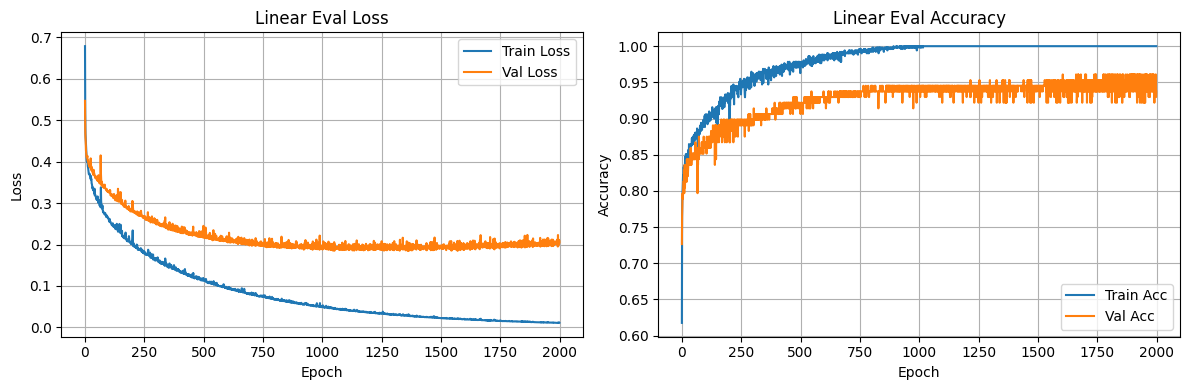

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.plot(lin_val_losses, label='Val Loss')
plt.title('Linear Eval Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.plot(lin_val_accs, label='Val Acc')
plt.title('Linear Eval Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


****Testing****

In [17]:
classifier.eval()
test_labels_all, test_probs_all = [], []
test_preds_all = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all = np.concatenate(test_preds_all)

print("\nTest Classification Report:")
print(classification_report(test_labels_all, test_preds_all, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.86      0.87      0.86      1142
   Others_augmented       0.89      0.89      0.89      1412

           accuracy                           0.88      2554
          macro avg       0.88      0.88      0.88      2554
       weighted avg       0.88      0.88      0.88      2554



****ROC curve****

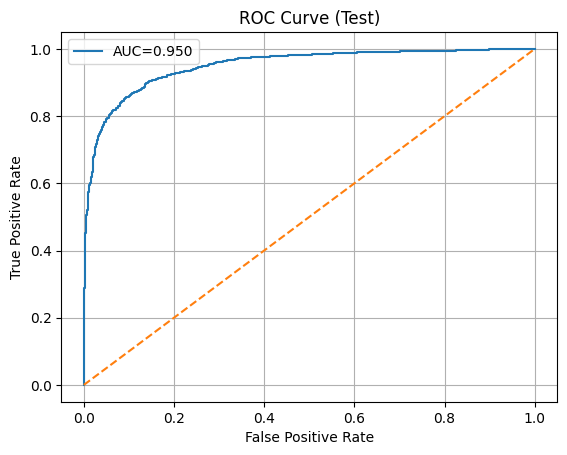

In [18]:
fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.grid(True); plt.legend(); plt.show()


Computing t-SNE on TEST features...


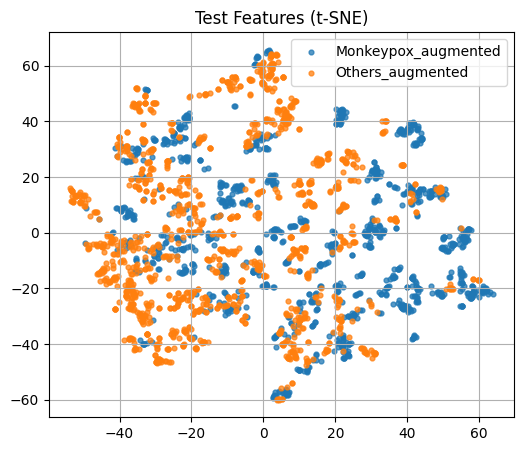

In [19]:
# t-SNE on TEST features (visual check of separability)
print("Computing t-SNE on TEST features...")
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("Test Features (t-SNE)"); plt.grid(True); plt.show()